In [1]:
## default libraries
from glob import glob
import numpy as np
import pandas as pd
import scipy as sp
import os, sys, logging
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import palettable.colorbrewer as cb
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannotations import Annotator
import h5py as h5
# import plotly.express as px
# import ipywidgets as widgets


#### My libraries
import pygwas.core as pygwas
import bshap.core as bshap
import pyquant.genopheno as pyquant
import snpmatch
from pygenome import genome
import pygenome.plotting as  genome_plotting


### Few settings
# setting to have text in pdf adjustable by illustrator (https://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/)
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style="white", color_codes=True, font_scale = 1.25)
log = logging.getLogger(__name__)

### Global variables
context_colors = cb.qualitative.Set2_3.hex_colors
temp_color = {'T4': cb.sequential.Blues_6.hex_colors[3], "T16": cb.sequential.Oranges_6.hex_colors[3]}
geno_color = {'AA': cb.diverging.BrBG_6.hex_colors[4], 'BB': cb.diverging.BrBG_6.hex_colors[1], 'AB': cb.sequential.Greys_5.hex_colors[2]}

home_dir = "/users/rahul.pisupati/"
proj_dir = "/groups/nordborg/projects/"
# home_dir = "/vol/HOME/"
# proj_dir = "/projects/"

tair10 = genome.GenomeClass(home_dir +  "/TAiR10_ARABIDOPSIS/TAIR10_wholeGenome.fasta")
tair10.centro_start = np.array([14364752, 3602775, 12674550, 2919690, 11668616, 0, 0])
tair10.centro_end   = np.array([15750321, 3735247, 13674767, 4011692, 12082583, 0, 0])
#### Centromeres are defined from the Science paper https://www.biorxiv.org/content/10.1101/2021.05.30.446350v2.full.pdf

tair10.centro_mid = ((tair10.centro_start + tair10.centro_end)/2).astype(int)
plotting_along_genome = genome_plotting.PlottingGenomeWide(tair10)

tair10.load_bed_ids_str(genes = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.protein_coding_genes.bed", gene_exon = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.protein_coding_gene_exons.bed", tes = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.transposable_elements.bed", tegene = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.transposable_element_genes.bed")
tair10.tes_cmt2_ids = pd.read_csv(proj_dir + "/cegs/rahul/013.alignMutants/CMT2_target_TEs.txt", header = None).iloc[:,0]
tair10.tes_rddm_ids = pd.read_csv(proj_dir + "/cegs/rahul/013.alignMutants/RdDM_target_TEs.txt", header = None).iloc[:,0]

filtering out genome scaffolds less than 1000000


In [2]:
### Filtering the genes with only gene body methylation in parents

gbm_only_genes = pd.read_csv("/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/araport_gbm_only_genes_6046_6191.csv", index_col=0)
tair10.gene_exon['parent_id'] = tair10.gene_exon.iloc[:,3].str.split(":", expand = True).iloc[:,0].values
print("total number of genes: %s" % tair10.gene_exon['parent_id'].unique().shape[0] )
tair10.gene_exon = tair10.gene_exon[tair10.gene_exon['parent_id'].isin( gbm_only_genes['geneid'] )]
tair10.genes = tair10.genes[tair10.genes.iloc[:,3].isin( gbm_only_genes['geneid'] )]
print("number of genes with gbm: %s" % tair10.gene_exon['parent_id'].unique().shape[0] )

tair10.genes.columns = ['chr', 'start', 'end', 'geneid', 'score', 'strand']
tair10.genes = pd.merge(tair10.genes, gbm_only_genes, left_on=['geneid'], right_on=['geneid'])

total number of genes: 27445
number of genes with gbm: 24841


# gbm changes in F2s

Assumptions: 
Cytosine gets either 0 or 1 methylation state through zygote.

Now, when you look at the individuals, what is the methylation state we see?
*   Compare this for sites with inherited 0's and inherited 1's
* Calculate the epimutation rate for the site which is inherited to be a 0.
* Now, does that explain the difference you see?





In [3]:
def get_deviations(bed_str, combined_mcs, qtl_map, map_key, return_all = False):
    inferred_geno_dict = qtl_map.get_genotype_dict_at_bed_str(map_key, bed_str)[1]
    inferred_geno_dict = inferred_geno_dict.reindex( combined_mcs.file_ids ).reset_index().groupby("geno").groups
    mcg_gbm_ix = combined_mcs.get_req_pos_bed_str( bed_str, req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )
    mc_data = combined_mcs.calculate_deviations_f2_populations( sub_populations=inferred_geno_dict, filter_cg_pos_ix = mcg_gbm_ix )
    mc_data.deviations = mc_data.deviations.reindex(combined_mcs.file_ids)
    return(mc_data)


def calc_residuals(y, x):
    ef_df = pd.DataFrame({"y": y, "x": x})
    if ef_df.dropna().shape[0] > 0:
        model = ols('y ~ x', data= pd.DataFrame({"y": y, "x": x}) ).fit()
        return( model.resid )
    else:
        return(np.nan)
    
def derive_pheno_h5_values(dev_aragenes, gene_ix):
    y_min=50
    ef_data = pd.DataFrame(index = np.array(dev_aragenes['accessions']).astype('U'))
    
    mc_total_0_nonpoly = dev_aragenes['mc_total_0_nonpoly'][gene_ix,:]
    ef_data['mc_total_0_nonpoly'] = np.nansum(mc_total_0_nonpoly, 0)
    ef_data['deviation_0_nonpoly'] = bshap.combinemeths.np_get_fraction(np.nansum(dev_aragenes['deviation_0_nonpoly'][gene_ix,:] * mc_total_0_nonpoly, 0), ef_data['mc_total_0_nonpoly'].values, y_min=y_min)
    
    mc_total_0_poly = dev_aragenes['mc_total_0_poly'][gene_ix,:]
    ef_data['mc_total_0_poly'] = np.nansum(mc_total_0_poly, 0)
    ef_data['deviation_0_poly'] = bshap.combinemeths.np_get_fraction(np.nansum(dev_aragenes['deviation_0_poly'][gene_ix,:] * mc_total_0_nonpoly, 0), ef_data['mc_total_0_poly'].values, y_min=y_min)
    
    mc_total_1_nonpoly = dev_aragenes['mc_total_1_nonpoly'][gene_ix,:]
    ef_data['mc_total_1_nonpoly'] = np.nansum(mc_total_1_nonpoly, 0)
    ef_data['deviation_1_nonpoly'] = bshap.combinemeths.np_get_fraction( np.nansum(dev_aragenes['deviation_1_nonpoly'][gene_ix,:] * mc_total_1_nonpoly, 0), ef_data['mc_total_1_nonpoly'].values, y_min=y_min)
    
    
    mc_total_1_poly = dev_aragenes['mc_total_1_poly'][gene_ix,:]
    ef_data['mc_total_1_poly'] = np.nansum(mc_total_1_poly, 0)
    ef_data['deviation_1_poly'] = bshap.combinemeths.np_get_fraction(np.nansum(dev_aragenes['deviation_1_poly'][gene_ix,:] * mc_total_1_nonpoly, 0), ef_data['mc_total_1_poly'].values, y_min=y_min)
    return(ef_data)



In [4]:
%%time
cross_data = pyquant.qtl_maps.GeneticMap( {'d1_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D1.csv", 'd2_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D2.csv" } )

cross_data.pheno = bshap.the1001g.ContextsHDF51001gTable( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/wmas_cds_genes/" )
cross_data.parent_ids = pyquant.parsers.split_ids(cross_data.pheno.cg.accessions).iloc[pd.Series(cross_data.pheno.cg.accessions).str.contains( "P_" ).values,:].sort_values( "dir_temp_plate" )

perc_meths_folder = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/" 
combined_mcs_f2s = {}
combined_mcs_f2s['samples'] = cross_data.sample_ids.copy() #.sample(300, random_state = 15 )

# # combined_mcs_f2s['meths'] = combinemeths.CombinedMethsTable( perc_meths_folder + "/hdf5/allc_" + combined_mcs_f2s['samples'].index + ".hdf5", file_ids =  combined_mcs_f2s['samples'].index.values)
# # combined_mcs_f2s['mcs'] = combined_mcs_f2s['meths'].derive_most_common_positions( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/mcs_F2s_D2_min50ind.hdf5", num_lines_with_info=50)
combined_mcs_f2s['meths'] = bshap.combinemeths.EpiMutations( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/combine_meths/mcs_F2_D1_min20ind.hdf5" )
combined_mcs_f2s['meths'].file_ids = pd.Series(combined_mcs_f2s['meths'].file_ids).str.replace("allc_", "").str.replace(".hdf5", "", regex=True)
combined_mcs_f2s['devs'] = h5.File( perc_meths_folder + "/calculate_deviations/deviations_aragene_exons_d1_v2.hdf5", 'r' )

# combined_mcs_f2s['meths'] = bshap.combinemeths.EpiMutations( perc_meths_folder + "/hdf5/allc_" + cross_data.ids_d1_2020.index + ".hdf5", proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/combine_meths/mcs_F2s_D1_min50ind.hdf5", file_ids =  cross_data.ids_d1_2020.index.values )


#### Reciprocal direction
# combined_mcs_f2s['meths'] = combinemeths.CombinedMethsTable( perc_meths_folder + "/hdf5/allc_" + combined_mcs_f2s['samples'].index + ".hdf5", file_ids =  combined_mcs_f2s['samples'].index.values)
# combined_mcs_f2s['mcs'] = combined_mcs_f2s['meths'].derive_most_common_positions( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/mcs_F2s_D2_min50ind.hdf5", num_lines_with_info=50)
combined_mcs_f2s['meths_d2'] = bshap.combinemeths.EpiMutations( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/combine_meths/mcs_F2s_D2_min50ind.hdf5" )
combined_mcs_f2s['meths_d2'].file_ids = pd.Series(combined_mcs_f2s['meths_d2'].file_ids).str.replace("allc_", "", regex=True).str.replace(".hdf5", "")
combined_mcs_f2s['devs_d2'] = h5.File( perc_meths_folder + "/calculate_deviations/deviations_aragene_exons_d2_v3.hdf5", 'r' )


## conversion rate for samples
conv_rate = pd.read_csv(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/sample_conversion_rate_chrc.csv", index_col=0).groupby("sample_id").mean()
combined_mcs_f2s['samples'] = pd.merge(combined_mcs_f2s['samples'], conv_rate, right_index=True, left_index=True)

CPU times: user 408 ms, sys: 132 ms, total: 540 ms
Wall time: 1.68 s


<timed exec>:23: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
%%time
combined_mcs_all = {}

combined_mcs_all['meths'] = bshap.combinemeths.EpiMutations( perc_meths_folder + "/combine_meths/mcs_F2s_min200ind_min3depth.hdf5" )
combined_mcs_all['samples'] = pyquant.parsers.split_ids( pd.Series(combined_mcs_all['meths'].file_ids).str.replace("allc_", "", regex=True).str.replace(".hdf5", "",regex=True).values )
combined_mcs_all['meths'].file_ids = pd.Series(combined_mcs_all['meths'].file_ids).str.replace("allc_", "").str.replace(".hdf5", "",regex=True).values

combined_mcs_all['accs_ix'] = combined_mcs_all['meths'].search_file_ids( pd.Series(combined_mcs_all['samples'].index.values, combined_mcs_all['samples']['dir_temp']) )
combined_mcs_all['accs_ix'].update( combined_mcs_all['meths'].search_file_ids( pd.Series(combined_mcs_all['samples'].index.values, combined_mcs_all['samples']['geno_dir']) ) )


# ## conversion rate for samples
conv_rate = pd.read_csv(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/sample_conversion_rate_chrc.csv", index_col=0).groupby("sample_id").mean()
combined_mcs_all['samples'] = pd.merge(combined_mcs_all['samples'], conv_rate, right_index=True, left_index=True)

CPU times: user 1.29 s, sys: 17.9 ms, total: 1.3 s
Wall time: 1.4 s


In [6]:


#### Load in the plate design
plate_design = pd.read_csv( perc_meths_folder + "../plates_repeat_crosses_modified.csv", sep = ";" )
plate_design.index = plate_design['plate'] + "." + plate_design['row'] + plate_design['col'].astype(str) + "_" + plate_design['genotype']
plate_design['replicated_id'] = plate_design.index.values
for ef_sample_id in plate_design.iterrows():
    if ef_sample_id[1]['replicated_genotype'] is not np.nan:
        plate_design.loc[ef_sample_id[0],"replicated_id"] = ef_sample_id[1]['replicated_genotype'] + "_" + ef_sample_id[1]['genotype']

In [7]:
cross_data.ids_d1_2020['temp'].value_counts()

T4     174
T16    134
Name: temp, dtype: int64

In [8]:
cross_data.ids_d2_2020['temp'].value_counts()

T4     174
T16    132
Name: temp, dtype: int64

In [9]:
cross_data.ids_d1_2020.shape

(308, 11)

In [10]:
cross_data.ids_d2_2020.shape

(306, 11)

## Conversion rates

In [75]:
combined_mcs_f2s['samples']['conv_rate_per'].describe()

count    614.000000
mean       0.289124
std        0.098763
min        0.062511
25%        0.227695
50%        0.263153
75%        0.354110
max        0.536947
Name: conv_rate_per, dtype: float64

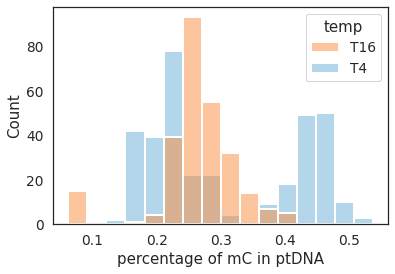

In [76]:
sns.histplot( data = combined_mcs_f2s['samples'], x = 'conv_rate_per', hue = "temp", palette=temp_color , linewidth = 2)
plt.xlabel("percentage of mC in ptDNA")
# plt.legend(title= "")


plt.show()

## Calculating deviations

In [40]:
%%time
req_mc_data = {}

req_mc_data['bed_str'] = "Chr1,1,2000000"  #,3500000" #"Chr1,1,2000000"



req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)

# req_mc_data['sample_data'] = combined_mcs_f2s['samples'].copy()
# req_mc_data['sample_data'] = pd.merge(req_mc_data['sample_data'],req_mc_data['mc_data'].deviations, left_index=True, right_index=True )

CPU times: user 15 s, sys: 7.5 s, total: 22.5 s
Wall time: 25.8 s


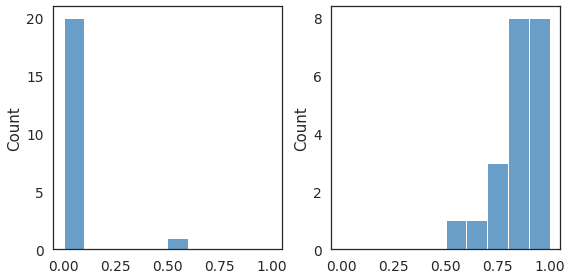

In [112]:
req_pop = req_mc_data['mc_data'].deviations.reset_index().groupby('subpop').groups['AA']

fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))

ef_bins = (req_mc_data['mc_data'].mc_meths['AA'] < 0.2) & (req_mc_data['mc_data'].mc_meths['AA'] > 0.01)
req_permeths = bshap.stats.np_get_fraction(req_mc_data['mc_data'].mc_count[np.where(ef_bins)[0],:][:,req_pop], req_mc_data['mc_data'].mc_total[np.where(ef_bins)[0],:][:,req_pop], 5)

sns.histplot(req_permeths[np.where((req_permeths.shape[1] - np.isnan(req_permeths).sum(1) ) > 20 )[0][1],:] , color="#377eb8", binwidth = 0.1, binrange = (0,1), ax = ax.flat[0])


ef_bins = (req_mc_data['mc_data'].mc_meths['AA'] < 0.95) & (req_mc_data['mc_data'].mc_meths['AA'] > 0.5)
req_permeths = bshap.stats.np_get_fraction(req_mc_data['mc_data'].mc_count[np.where(ef_bins)[0],:][:,req_pop], req_mc_data['mc_data'].mc_total[np.where(ef_bins)[0],:][:,req_pop], 5)


sns.histplot(req_permeths[np.where((req_permeths.shape[1] - np.isnan(req_permeths).sum(1) ) > 20 )[0][4],:] , color="#377eb8", binwidth = 0.1, binrange = (0,1), ax = ax.flat[1])

fig.tight_layout()
fig.savefig("test_mcs.pdf")

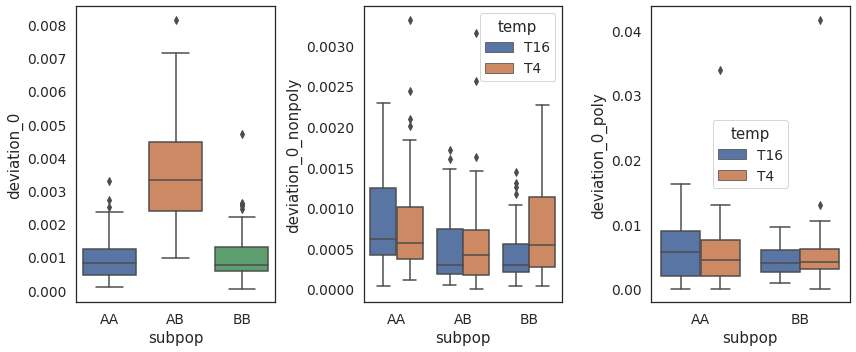

In [17]:
fig, axs = plt.subplots(figsize = (12, 5), ncols =3)
sns.boxplot(data = req_mc_data['sample_data'], x = "subpop", y = "deviation_0", order = ['AA', 'AB', 'BB'], ax = axs.flat[0])

sns.boxplot(data = req_mc_data['sample_data'], hue = "temp", x = "subpop", y = "deviation_0_nonpoly", order = ['AA', 'AB', 'BB'], ax = axs.flat[1])

sns.boxplot(data = req_mc_data['sample_data'], hue = "temp", x = "subpop", y = "deviation_0_poly", order = ['AA', 'BB'], ax = axs.flat[2])


fig.tight_layout()

plt.show()

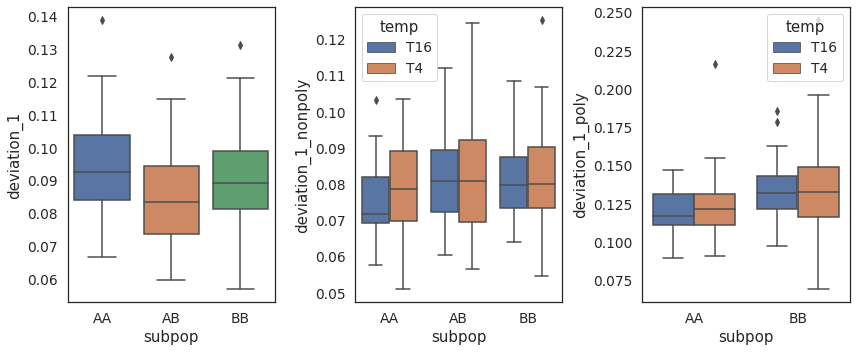

In [19]:
fig, axs = plt.subplots(figsize = (12, 5), ncols =3)
sns.boxplot(data = req_mc_data['sample_data'], x = "subpop", y = "deviation_1", order = ['AA', 'AB', 'BB'], ax = axs.flat[0])

sns.boxplot(data = req_mc_data['sample_data'], hue = "temp", x = "subpop", y = "deviation_1_nonpoly", order = ['AA', 'AB', 'BB'], ax = axs.flat[1])

sns.boxplot(data = req_mc_data['sample_data'], hue = "temp", x = "subpop", y = "deviation_1_poly", order = ['AA', 'BB'], ax = axs.flat[2])


fig.tight_layout()

plt.show()

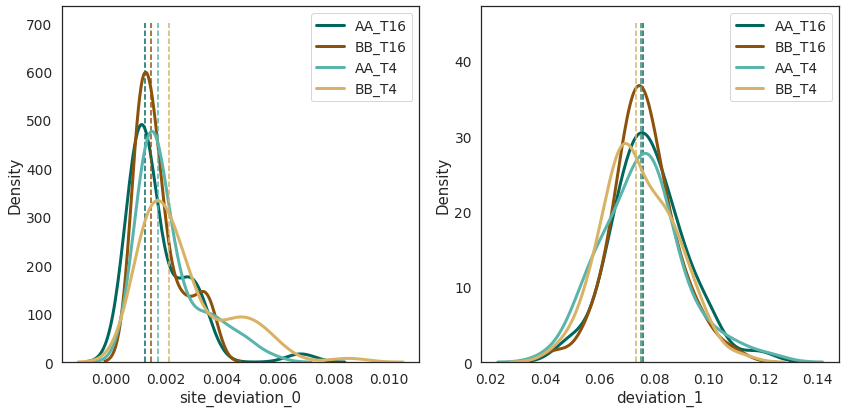

In [16]:
fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))


axs.flat[0] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'AA') & (req_mc_data['sample_data']['temp'] == 'T16')]['site_deviation_0'] , ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[6], linewidth = 3, label = 'AA_T16', line_limits = (0, 700))
axs.flat[0] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'BB') & (req_mc_data['sample_data']['temp'] == 'T16')]["site_deviation_0"], ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[0], linewidth = 3, label = 'BB_T16', line_limits = (0, 700))
axs.flat[0] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'AA') & (req_mc_data['sample_data']['temp'] == 'T4')]["site_deviation_0"], ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[5], linewidth = 3, label = 'AA_T4', line_limits = (0, 700))
axs.flat[0] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'BB') & (req_mc_data['sample_data']['temp'] == 'T4')]["site_deviation_0"], ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[1], linewidth = 3, label = 'BB_T4', line_limits = (0, 700))

axs.flat[0].legend()



axs.flat[1] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'AA') & (req_mc_data['sample_data']['temp'] == 'T16')]['deviation_1'] , ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[6], linewidth = 3, label = 'AA_T16', line_limits = (0, 45))
axs.flat[1] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'BB') & (req_mc_data['sample_data']['temp'] == 'T16')]["deviation_1"], ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[0], linewidth = 3, label = 'BB_T16', line_limits = (0, 45))
axs.flat[1] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'AA') & (req_mc_data['sample_data']['temp'] == 'T4')]["deviation_1"], ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[5], linewidth = 3, label = 'AA_T4', line_limits = (0, 45))
axs.flat[1] = bshap.plotting.add_kdeplot(x = req_mc_data['sample_data'][(req_mc_data['sample_data']['subpop'] == 'BB') & (req_mc_data['sample_data']['temp'] == 'T4')]["deviation_1"], ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[1], linewidth = 3, label = 'BB_T4', line_limits = (0, 45))

axs.flat[1].legend()

fig.tight_layout()


plt.show()

## Average deviations per gene. 

Working more on the _cis_ effects. 

Do denes with high gbM difference have high gain/loss rates?

In [8]:
def cis_joint_plot(x, y, common_reqcond, pie_options ):
    p = sns.JointGrid(marginal_ticks=False)    
    p.ax_joint.set(xlim=common_reqcond['xlim'],ylim = common_reqcond['ylim'])
    sns.scatterplot(x = x, y = y, color = common_reqcond['color'], ax = p.ax_joint, alpha = 0.4,rasterized = True)
    sns.regplot(x = x, y = y, color = common_reqcond['color'], ax = p.ax_joint,scatter = False)
    
    
    sns.kdeplot(x= x, linewidth=2, ax=p.ax_marg_x, color=common_reqcond['color'])
    p.ax_marg_x.vlines(x = 0, ymin = 0, ymax = p.ax_marg_x.get_ylim()[1], linestyle = '--', color = "#636363" )
    p.ax_marg_x.set_ylabel("")
    sns.kdeplot(y= y, linewidth=2, ax=p.ax_marg_y, color=common_reqcond['color'])
    p.ax_marg_y.hlines(y = 0, xmin = 0, xmax = p.ax_marg_y.get_xlim()[1], linestyle = '--', color = "#636363" )
    p.ax_marg_y.set_xlabel("")
    
    pie_ax  = p.fig.add_axes(p.ax_joint.get_position(), frameon=False )
    bshap.plotting._quadrant_plot_yolk(x = x, y = y, axs =  pie_ax, plt_options=pie_options )
    pie_ax.set_yticklabels([])
    pie_ax.set_xticklabels([])
    return(p)

In [9]:
%%time
# devs_output_pergene = {}
# devs_output_pergene['subpop'] = np.array(combined_mcs_f2s['devs']['subpop']).astype('U')
# devs_output_pergene['total_dev_0'] = np.array(combined_mcs_f2s['devs']['mc_total_0_nonpoly'])
# devs_output_pergene['total_dev_0'][np.isnan( devs_output_pergene['total_dev_0'] )] = 0
# devs_output_pergene['total_dev_1'] = np.array(combined_mcs_f2s['devs']['mc_total_1_nonpoly'])
# devs_output_pergene['total_dev_1'][np.isnan( devs_output_pergene['total_dev_1'] )] = 0
# devs_output_pergene['count_dev_0'] = devs_output_pergene['total_dev_0'] * np.array(combined_mcs_f2s['devs']['deviation_0_nonpoly'])
# devs_output_pergene['count_dev_0'][np.isnan( devs_output_pergene['count_dev_0'] )] = 0
# devs_output_pergene['count_dev_1'] = devs_output_pergene['total_dev_1'] * np.array(combined_mcs_f2s['devs']['deviation_1_nonpoly'])
# devs_output_pergene['count_dev_1'][np.isnan( devs_output_pergene['count_dev_1'] )] = 0

# avg_dev_per_gene = pd.DataFrame(index = np.array(combined_mcs_f2s['devs']['gene_ids']).astype('U'), columns=['dev_0_AA','dev_0_BB','dev_1_AA','dev_1_BB'] )
# for ef_row in enumerate(avg_dev_per_gene.index):
#     ef_data = pd.DataFrame({"subpop": devs_output_pergene['subpop'][ef_row[0],:], "total_dev_0": devs_output_pergene['total_dev_0'][ef_row[0],:], "total_dev_1": devs_output_pergene['total_dev_1'][ef_row[0],:], "count_dev_0": devs_output_pergene['count_dev_0'][ef_row[0],:], "count_dev_1": devs_output_pergene['count_dev_1'][ef_row[0],:]})
#     ef_data = ef_data.groupby('subpop').sum()
#     avg_dev_per_gene.loc[ef_row[1], 'dev_0_AA'] = bshap.stats.np_get_fraction(ef_data.loc['AA','count_dev_0'], ef_data.loc['AA','total_dev_0'], y_min=20 )
#     avg_dev_per_gene.loc[ef_row[1], 'dev_0_BB'] = bshap.stats.np_get_fraction(ef_data.loc['BB','count_dev_0'], ef_data.loc['BB','total_dev_0'], y_min=20 )
#     avg_dev_per_gene.loc[ef_row[1], 'dev_1_AA'] = bshap.stats.np_get_fraction(ef_data.loc['AA','count_dev_1'], ef_data.loc['AA','total_dev_1'], y_min=20 )
#     avg_dev_per_gene.loc[ef_row[1], 'dev_1_BB'] = bshap.stats.np_get_fraction(ef_data.loc['BB','count_dev_1'], ef_data.loc['BB','total_dev_1'], y_min=20 )
    
# avg_dev_per_gene = pd.merge(tair10.genes.set_index("geneid"), avg_dev_per_gene, left_index=True, right_index=True)
# avg_dev_per_gene.to_csv("cache_data/STable_average_deviations_per_gene.csv")

# pd.DataFrame(dict(sample_id = np.array(combined_mcs_f2s['devs']['accessions']).astype('U'), avg_gains = bshap.stats.np_get_fraction(devs_output_pergene['count_dev_0'].sum(0), devs_output_pergene['total_dev_0'].sum(0) ), avg_losses = bshap.stats.np_get_fraction(devs_output_pergene['count_dev_0'].sum(0), devs_output_pergene['total_dev_0'].sum(0) ) ) ).to_csv( "cache_data/STable_average_deviations_per_sample.csv" )

combined_mcs_f2s['avg_dev_gene'] = pd.read_csv("cache_data/STable_average_deviations_per_gene.csv", index_col=0)


req_data = {}
req_data['diff_mcg_soma'] = combined_mcs_f2s['avg_dev_gene'].copy()
req_data['diff_mcg_soma'] = req_data['diff_mcg_soma'].loc[~req_data['diff_mcg_soma']['dev_1_AA'].isna() & ~req_data['diff_mcg_soma']['dev_1_BB'].isna(),:]
### Only take methylated genes in both AA and BB
req_data['diff_mcg_soma']['gbm_diff'] = req_data['diff_mcg_soma']['CG_P_6046'] - req_data['diff_mcg_soma']['CG_P_6191']
req_data['diff_mcg_soma']['dev_0_diff'] = req_data['diff_mcg_soma']['dev_0_AA'] - req_data['diff_mcg_soma']['dev_0_BB']
req_data['diff_mcg_soma']['dev_1_diff'] = req_data['diff_mcg_soma']['dev_1_AA'] - req_data['diff_mcg_soma']['dev_1_BB']


CPU times: user 67.7 ms, sys: 15.8 ms, total: 83.5 ms
Wall time: 156 ms


In [10]:
%%time
# devs_output_pergene = {}
# devs_output_pergene['subpop'] = np.array(combined_mcs_f2s['devs_d2']['subpop']).astype('U')
# devs_output_pergene['total_dev_0'] = np.array(combined_mcs_f2s['devs_d2']['mc_total_0_nonpoly'])
# devs_output_pergene['total_dev_0'][np.isnan( devs_output_pergene['total_dev_0'] )] = 0
# devs_output_pergene['total_dev_1'] = np.array(combined_mcs_f2s['devs_d2']['mc_total_1_nonpoly'])
# devs_output_pergene['total_dev_1'][np.isnan( devs_output_pergene['total_dev_1'] )] = 0
# devs_output_pergene['count_dev_0'] = devs_output_pergene['total_dev_0'] * np.array(combined_mcs_f2s['devs_d2']['deviation_0_nonpoly'])
# devs_output_pergene['count_dev_0'][np.isnan( devs_output_pergene['count_dev_0'] )] = 0
# devs_output_pergene['count_dev_1'] = devs_output_pergene['total_dev_1'] * np.array(combined_mcs_f2s['devs_d2']['deviation_1_nonpoly'])
# devs_output_pergene['count_dev_1'][np.isnan( devs_output_pergene['count_dev_1'] )] = 0

# avg_dev_per_gene = pd.DataFrame(index = np.array(combined_mcs_f2s['devs_d2']['gene_ids']).astype('U'), columns=['dev_0_AA','dev_0_BB','dev_1_AA','dev_1_BB'] )
# for ef_row in enumerate(avg_dev_per_gene.index):
#     ef_data = pd.DataFrame({"subpop": devs_output_pergene['subpop'][ef_row[0],:], "total_dev_0": devs_output_pergene['total_dev_0'][ef_row[0],:], "total_dev_1": devs_output_pergene['total_dev_1'][ef_row[0],:], "count_dev_0": devs_output_pergene['count_dev_0'][ef_row[0],:], "count_dev_1": devs_output_pergene['count_dev_1'][ef_row[0],:]})
#     ef_data = ef_data.groupby('subpop').sum()
#     avg_dev_per_gene.loc[ef_row[1], 'dev_0_AA'] = bshap.stats.np_get_fraction(ef_data.loc['AA','count_dev_0'], ef_data.loc['AA','total_dev_0'], y_min=20 )
#     avg_dev_per_gene.loc[ef_row[1], 'dev_0_BB'] = bshap.stats.np_get_fraction(ef_data.loc['BB','count_dev_0'], ef_data.loc['BB','total_dev_0'], y_min=20 )
#     avg_dev_per_gene.loc[ef_row[1], 'dev_1_AA'] = bshap.stats.np_get_fraction(ef_data.loc['AA','count_dev_1'], ef_data.loc['AA','total_dev_1'], y_min=20 )
#     avg_dev_per_gene.loc[ef_row[1], 'dev_1_BB'] = bshap.stats.np_get_fraction(ef_data.loc['BB','count_dev_1'], ef_data.loc['BB','total_dev_1'], y_min=20 )
    
# avg_dev_per_gene = pd.merge(tair10.genes.set_index("geneid"), avg_dev_per_gene, left_index=True, right_index=True)
# avg_dev_per_gene.to_csv("cache_data/STable_average_deviations_per_gene_d2.csv")


combined_mcs_f2s['avg_dev_gene_d2'] = pd.read_csv( "cache_data/STable_average_deviations_per_gene_d2.csv", index_col=0)

CPU times: user 64.1 ms, sys: 18.9 ms, total: 83 ms
Wall time: 203 ms


In [11]:
%%time
# devs_output_pergene = {}
# devs_output_pergene['subpop'] = np.array(combined_mcs_f2s['devs']['subpop']).astype('U')
# devs_output_pergene['total_dev_0'] = np.array(combined_mcs_f2s['devs']['mc_total_0_nonpoly'])
# devs_output_pergene['total_dev_0'][np.isnan( devs_output_pergene['total_dev_0'] )] = 0
# devs_output_pergene['total_dev_1'] = np.array(combined_mcs_f2s['devs']['mc_total_1_nonpoly'])
# devs_output_pergene['total_dev_1'][np.isnan( devs_output_pergene['total_dev_1'] )] = 0
# devs_output_pergene['count_dev_0'] = devs_output_pergene['total_dev_0'] * np.array(combined_mcs_f2s['devs']['deviation_0_nonpoly'])
# devs_output_pergene['count_dev_0'][np.isnan( devs_output_pergene['count_dev_0'] )] = 0
# devs_output_pergene['count_dev_1'] = devs_output_pergene['total_dev_1'] * np.array(combined_mcs_f2s['devs']['deviation_1_nonpoly'])
# devs_output_pergene['count_dev_1'][np.isnan( devs_output_pergene['count_dev_1'] )] = 0
# devs_output_pergene['samples'] = combined_mcs_all['samples'].reindex(np.array(combined_mcs_f2s['devs']['accessions']).astype('U'))

# avg_dev_per_gene = pd.DataFrame(index = np.array(combined_mcs_f2s['devs']['gene_ids']).astype('U'), columns=['dev_0_AA','dev_0_BB','dev_1_AA','dev_1_BB'] )
# for ef_row in enumerate(avg_dev_per_gene.index):
#     ef_data = pd.DataFrame({"subpop": devs_output_pergene['subpop'][ef_row[0],:], "total_dev_0": devs_output_pergene['total_dev_0'][ef_row[0],:], "total_dev_1": devs_output_pergene['total_dev_1'][ef_row[0],:], "count_dev_0": devs_output_pergene['count_dev_0'][ef_row[0],:], "count_dev_1": devs_output_pergene['count_dev_1'][ef_row[0],:]})
#     ef_data['temp'] = devs_output_pergene['samples']['temp'].values
#     ef_data = ef_data[ef_data['subpop'] != 'nan']
#     ef_data['subtemp'] = ef_data['subpop'] + '_' + ef_data['temp']
#     ef_data = ef_data.groupby('subtemp').sum()
#     avg_dev_per_gene.loc[ef_row[1], 'dev_0_' + pd.Series(ef_data.index)] = bshap.stats.np_get_fraction(ef_data['count_dev_0'].values, ef_data['total_dev_0'].values, y_min=20) 
#     avg_dev_per_gene.loc[ef_row[1], 'dev_1_' + pd.Series(ef_data.index)] = bshap.stats.np_get_fraction(ef_data['count_dev_1'].values, ef_data['total_dev_1'].values, y_min=20) 

    
# avg_dev_per_gene = pd.merge(tair10.genes.set_index("geneid"), avg_dev_per_gene, left_index=True, right_index=True)
# avg_dev_per_gene.to_csv("cache_data/STable_average_deviations_per_gene_pertemp.csv")


combined_mcs_f2s['avg_dev_gene'] = pd.read_csv("cache_data/STable_average_deviations_per_gene_pertemp.csv", index_col=0)



CPU times: user 85.1 ms, sys: 24.9 ms, total: 110 ms
Wall time: 223 ms


In [12]:
%%time
# devs_output_pergene = {}
# devs_output_pergene['subpop'] = np.array(combined_mcs_f2s['devs_d2']['subpop']).astype('U')
# devs_output_pergene['total_dev_0'] = np.array(combined_mcs_f2s['devs_d2']['mc_total_0_nonpoly'])
# devs_output_pergene['total_dev_0'][np.isnan( devs_output_pergene['total_dev_0'] )] = 0
# devs_output_pergene['total_dev_1'] = np.array(combined_mcs_f2s['devs_d2']['mc_total_1_nonpoly'])
# devs_output_pergene['total_dev_1'][np.isnan( devs_output_pergene['total_dev_1'] )] = 0
# devs_output_pergene['count_dev_0'] = devs_output_pergene['total_dev_0'] * np.array(combined_mcs_f2s['devs_d2']['deviation_0_nonpoly'])
# devs_output_pergene['count_dev_0'][np.isnan( devs_output_pergene['count_dev_0'] )] = 0
# devs_output_pergene['count_dev_1'] = devs_output_pergene['total_dev_1'] * np.array(combined_mcs_f2s['devs_d2']['deviation_1_nonpoly'])
# devs_output_pergene['count_dev_1'][np.isnan( devs_output_pergene['count_dev_1'] )] = 0
# devs_output_pergene['samples'] = combined_mcs_all['samples'].loc[np.array(combined_mcs_f2s['devs_d2']['accessions']).astype('U'),:]

# avg_dev_per_gene = pd.DataFrame(index = np.array(combined_mcs_f2s['devs_d2']['gene_ids']).astype('U') )
# for ef_row in enumerate(avg_dev_per_gene.index):
#     ef_data = pd.DataFrame({"subpop": devs_output_pergene['subpop'][ef_row[0],:], "total_dev_0": devs_output_pergene['total_dev_0'][ef_row[0],:], "total_dev_1": devs_output_pergene['total_dev_1'][ef_row[0],:], "count_dev_0": devs_output_pergene['count_dev_0'][ef_row[0],:], "count_dev_1": devs_output_pergene['count_dev_1'][ef_row[0],:]})
#     ef_data['temp'] = devs_output_pergene['samples']['temp'].values
#     ef_data = ef_data[ef_data['subpop'] != 'nan']
#     ef_data['subtemp'] = ef_data['subpop'] + '_' + ef_data['temp']
#     ef_data = ef_data.groupby('subtemp').sum()
#     avg_dev_per_gene.loc[ef_row[1], 'dev_0_' + pd.Series(ef_data.index)] = bshap.stats.np_get_fraction(ef_data['count_dev_0'].values, ef_data['total_dev_0'].values, y_min=20) 
#     avg_dev_per_gene.loc[ef_row[1], 'dev_1_' + pd.Series(ef_data.index)] = bshap.stats.np_get_fraction(ef_data['count_dev_1'].values, ef_data['total_dev_1'].values, y_min=20) 
    
# avg_dev_per_gene = pd.merge(tair10.genes.set_index("geneid"), avg_dev_per_gene, left_index=True, right_index=True)
# avg_dev_per_gene.to_csv("cache_data/STable_average_deviations_per_gene_pertemp_d2.csv")


combined_mcs_f2s['avg_dev_gene_d2'] = pd.read_csv( "cache_data/STable_average_deviations_per_gene_pertemp_d2.csv", index_col=0)

CPU times: user 88.1 ms, sys: 15.5 ms, total: 104 ms
Wall time: 187 ms


NN x SS_T16    a
NN x SS_T4     b
SS x NN_T16    a
SS x NN_T4     b
dtype: object

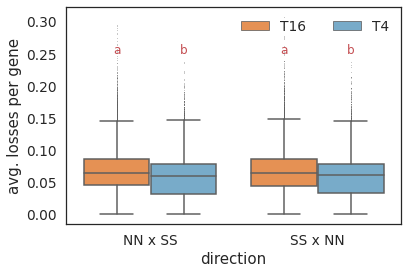

In [117]:
ef_data = pd.DataFrame( dict(direction = "NN x SS", temp = 'T16', dev_1= combined_mcs_f2s['avg_dev_gene']['dev_1_AA_T16'] ) )
ef_data = pd.concat([ef_data, pd.DataFrame( dict(direction = "NN x SS", temp = 'T4', dev_1= combined_mcs_f2s['avg_dev_gene']['dev_1_AA_T4'] ) ) ])

ef_data = pd.concat([ef_data, pd.DataFrame( dict(direction = "SS x NN", temp = 'T16', dev_1= combined_mcs_f2s['avg_dev_gene_d2']['dev_1_AA_T16'] ) ) ])
ef_data = pd.concat([ef_data, pd.DataFrame( dict(direction = "SS x NN", temp = 'T4', dev_1= combined_mcs_f2s['avg_dev_gene_d2']['dev_1_AA_T4'] ) ) ])
ef_data = ef_data.dropna()
# ef_data = ef_data[ef_data['dev_1'] > 0]




anno_args = dict(horizontalalignment='center', size='large', weight='normal', color='r')

fig_args = dict(data = ef_data, y = "dev_1", x = "direction", order = ['NN x SS', 'SS x NN'], hue = "temp", hue_order=['T16','T4'])

ax = sns.boxplot( **fig_args, palette=temp_color, fliersize=0.1 )
ax.legend(frameon = False, ncol = 2)
ax.set_ylabel("avg. losses per gene")
Annotator.add_tukeyletter(fig_args=fig_args, axs=ax, text_y_pos = 0.25, anno_args = anno_args )

NN x SS_T16     b
NN x SS_T4      a
SS x NN_T16     c
SS x NN_T4     bc
dtype: object

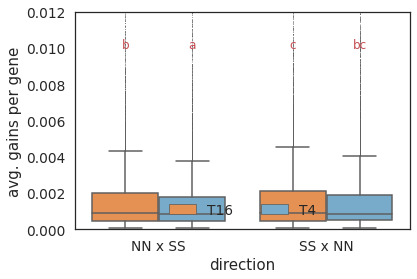

In [116]:
ef_data = pd.DataFrame( dict(direction = "NN x SS", temp = 'T16', dev_1= combined_mcs_f2s['avg_dev_gene']['dev_0_AA_T16'] ) )
ef_data = pd.concat([ef_data, pd.DataFrame( dict(direction = "NN x SS", temp = 'T4', dev_1= combined_mcs_f2s['avg_dev_gene']['dev_0_AA_T4'] ) ) ])

ef_data = pd.concat([ef_data, pd.DataFrame( dict(direction = "SS x NN", temp = 'T16', dev_1= combined_mcs_f2s['avg_dev_gene_d2']['dev_0_AA_T16'] ) ) ])
ef_data = pd.concat([ef_data, pd.DataFrame( dict(direction = "SS x NN", temp = 'T4', dev_1= combined_mcs_f2s['avg_dev_gene_d2']['dev_0_AA_T4'] ) ) ])
ef_data = ef_data.dropna()
ef_data = ef_data[ef_data['dev_1'] > 0]




anno_args = dict(horizontalalignment='center', size='large', weight='normal', color='r')

fig_args = dict(data = ef_data, y = "dev_1", x = "direction", order = ['NN x SS', 'SS x NN'], hue = "temp", hue_order=['T16','T4'])

ax = sns.boxplot( **fig_args, palette=temp_color, fliersize=0.1 )
ax.legend(frameon = False, ncol = 2)
ax.set_ylabel("avg. gains per gene")
ax.set_ylim(0, 0.012)
Annotator.add_tukeyletter(fig_args=fig_args, axs=ax, text_y_pos = 0.01, anno_args = anno_args )

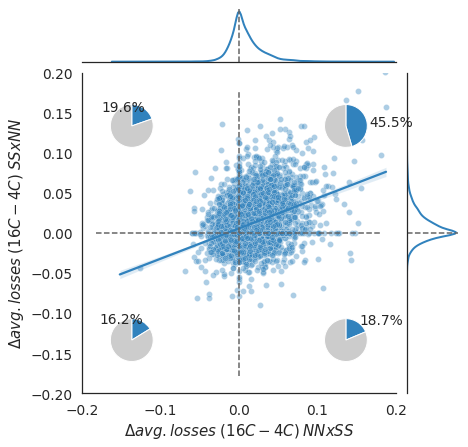

In [33]:

# print(sp.stats.spearmanr(req_data['diff_mcg_soma'].dropna()['gbm_diff'], req_data['diff_mcg_soma'].dropna()['dev_0_diff']  ))
# print(req_data['diff_mcg_soma'].dropna().shape)
common_reqcond = dict(xlim=(-0.2, 0.2), ylim=(-0.2, 0.2), color = cb.sequential.Blues_6.hex_colors[4], center = 0)
pie_options = dict(xlim=(-1, 1), ylim=(-1,1), center = 0, xpie = (-0.75,0.75), ypie = (-0.75, 0.75), pie_rad = 0.15, color = common_reqcond['color'] ) 


ef_data = combined_mcs_f2s['avg_dev_gene'].copy()
ef_data['gbm_diff'] = ef_data['CG_P_6046'] - ef_data['CG_P_6191']

ef_data['dev_1_temp'] = ef_data['dev_1_AA_T16'] - ef_data['dev_1_AA_T4']
ef_data['dev_1_temp_d2'] = combined_mcs_f2s['avg_dev_gene_d2']['dev_1_AA_T16'] - combined_mcs_f2s['avg_dev_gene_d2']['dev_1_AA_T4']


p = cis_joint_plot( x = ef_data['dev_1_temp'], y = ef_data['dev_1_temp_d2'], common_reqcond=common_reqcond, pie_options=pie_options )
p.ax_joint.set_xlabel(r'${\Delta} avg. losses\;(16C - 4C)\: NN x SS $')
p.ax_joint.set_ylabel(r'${\Delta}avg. losses\; (16C - 4C)\; SS x NN $')

plt.show()

SpearmanrResult(correlation=0.2036684502476269, pvalue=1.5317388192315467e-95)
(10155, 21)


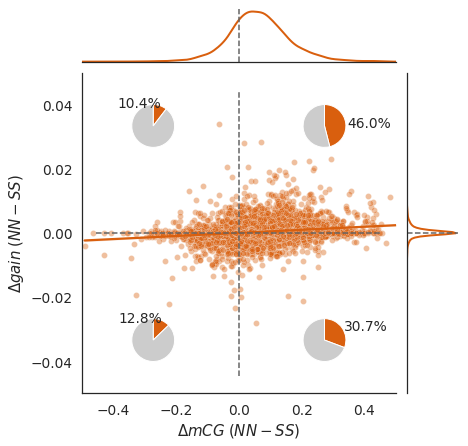

In [26]:
print(sp.stats.spearmanr(req_data['diff_mcg_soma'].dropna()['gbm_diff'], req_data['diff_mcg_soma'].dropna()['dev_0_diff']  ))
print(req_data['diff_mcg_soma'].dropna().shape)
common_reqcond = dict(xlim=(-0.5, 0.5), ylim=(-0.05, 0.05), color = cb.sequential.YlOrBr_6.hex_colors[4], center = 0)
pie_options = dict(xlim=(-1, 1), ylim=(-1,1), center = 0, xpie = (-0.6,0.6), ypie = (-0.75, 0.75), pie_rad = 0.15, color = common_reqcond['color'] ) 


p = cis_joint_plot( x = req_data['diff_mcg_soma'].dropna()['gbm_diff'], y = req_data['diff_mcg_soma'].dropna()['dev_0_diff'], common_reqcond=common_reqcond, pie_options=pie_options )
p.ax_joint.set_xlabel(r'${\Delta}mCG \; (NN - SS) $')
p.ax_joint.set_ylabel(r'${\Delta}gain \; (NN - SS) $')


plt.savefig("gbm_gains_ns.pdf", bbox_inches='tight', dpi = 300)

plt.show()


SpearmanrResult(correlation=-0.12592470699662964, pvalue=3.596059245614722e-37)


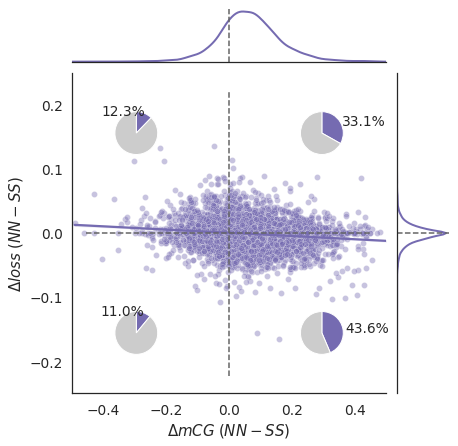

In [27]:
print(sp.stats.spearmanr(req_data['diff_mcg_soma'].dropna()['gbm_diff'], req_data['diff_mcg_soma'].dropna()['dev_1_diff'] ))
common_reqcond = dict(xlim=(-0.5, 0.5), ylim=(-0.25, 0.25), color = cb.sequential.Purples_5.hex_colors[3],  center = 0)
pie_options = dict(xlim=(-1, 1), ylim=(-1,1), center = 0, xpie = (-0.65,0.65), ypie = (-0.7, 0.7), pie_rad = 0.15, color = common_reqcond['color'] ) 


p1 = cis_joint_plot( x = req_data['diff_mcg_soma'].dropna()['gbm_diff'], y = req_data['diff_mcg_soma'].dropna()['dev_1_diff'], common_reqcond=common_reqcond, pie_options=pie_options )
p1.ax_joint.set_xlabel(r'${\Delta}mCG \; (NN - SS) $')
p1.ax_joint.set_ylabel(r'${\Delta}loss \; (NN - SS) $')

plt.savefig("gbm_losses_ns.pdf", bbox_inches='tight', dpi = 300)

plt.show()

In [14]:
results = sm.formula.ols('dev_0_diff ~ gbm_diff', data = req_data['diff_mcg_soma'].dropna() ).fit()

req_data['diff_mcg_soma']['dev_0_diff_resid'] = results.resid
req_data['diff_mcg_soma']['gbm_grp'] = (req_data['diff_mcg_soma']['gbm_diff'] > 0).astype(int)


pyquant.stats.perform_tukey_hsd(req_data['diff_mcg_soma'].dropna()['dev_0_diff_resid'], req_data['diff_mcg_soma'].dropna()['gbm_grp'], groups_order=[0,1]  )

group1 group2  meandiff  p-adj   lower   upper  reject
1_2      1      2    0.0001  0.171 -0.0001  0.0002   False

In [59]:
results = sm.formula.ols('dev_1_diff ~ gbm_diff', data = req_data['diff_mcg_soma'].dropna() ).fit()
req_data['diff_mcg_soma']['dev_1_diff_resid'] = results.resid

pyquant.stats.perform_tukey_hsd(req_data['diff_mcg_soma'].dropna()['dev_1_diff_resid'], req_data['diff_mcg_soma'].dropna()['gbm_grp'], groups_order=[0,1]  )

group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0002  0.6174 -0.0012  0.0008   False

In [17]:
print(sp.stats.pearsonr(req_data['diff_mcg_soma'].dropna()['gbm_diff'], req_data['diff_mcg_soma'].dropna()['dev_0_diff_resid'] ))

(5.5077470362263625e-17, 1.0000000000152824)


<AxesSubplot:xlabel='gbm_diff', ylabel='dev_0_diff_resid'>

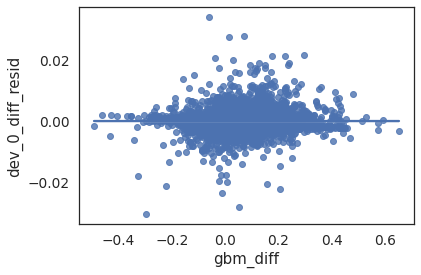

In [15]:
sns.regplot(data = req_data['diff_mcg_soma'], y = 'dev_0_diff_resid', x = 'gbm_diff' )



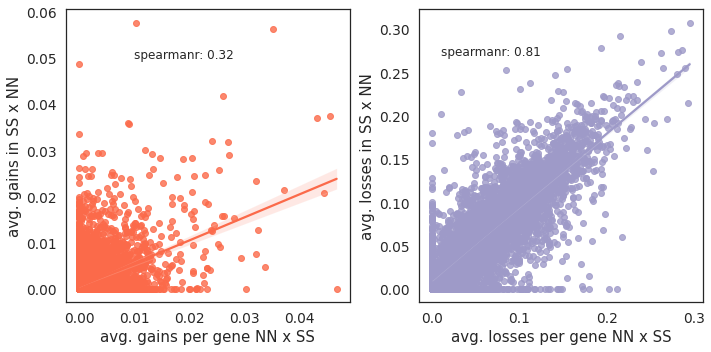

CPU times: user 2.21 s, sys: 227 ms, total: 2.43 s
Wall time: 2.12 s


In [167]:
%%time
ef_data = combined_mcs_f2s['avg_dev_gene'].copy()
ef_data = pd.merge( ef_data, combined_mcs_f2s['avg_dev_gene_d2'].loc[:, combined_mcs_f2s['avg_dev_gene_d2'].columns.str.startswith('dev')], suffixes=['_d1','_d2'], left_index=True, right_index=True )

fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))

def plt_dist(data, x, y, ax, reg_args = dict(), txt_args = dict()):
    e_data = data.loc[:,[x,y]].dropna()
    sns.regplot(x = e_data[x], y = e_data[y], ax = ax, scatter_kws = dict(rasterized = True), **reg_args)
    t_anno = "spearmanr: %.2f" % (sp.stats.spearmanr(e_data[x], e_data[y])[0])
    ax.text(**txt_args, s = t_anno, size = 12)
    
    
plt_dist(ef_data, 'dev_0_AA_T16_d1', 'dev_0_AA_T16_d2', axs.flat[0], reg_args = dict(color = cb.sequential.Reds_5.hex_colors[2]  ), txt_args = dict(x = 0.01, y = 0.05)  )
axs.flat[0].set_xlabel("avg. gains per gene NN x SS")
axs.flat[0].set_ylabel("avg. gains in SS x NN")


plt_dist(ef_data, 'dev_1_AA_T16_d1', 'dev_1_AA_T16_d2', axs.flat[1], reg_args = dict(color = cb.sequential.Purples_5.hex_colors[2] ), txt_args = dict(x = 0.01, y = 0.27)  )
axs.flat[1].set_xlabel("avg. losses per gene NN x SS")
axs.flat[1].set_ylabel("avg. losses in SS x NN")
# plt.text( 0.1, 0.9, "asd", transform=axs.flat[1].transAxes, size = 12 )


fig.tight_layout()

plt.savefig("gene_deviations_reciprocal.pdf")

plt.show()

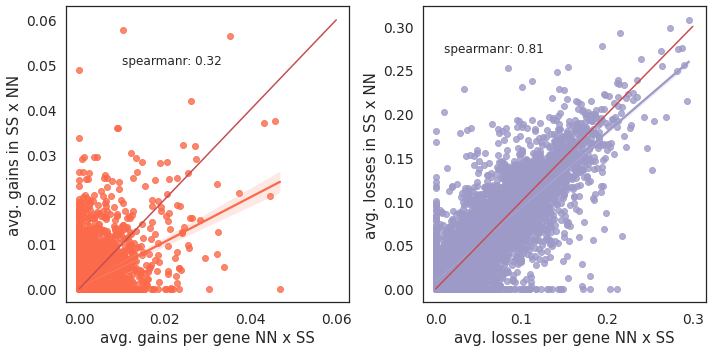

CPU times: user 1.71 s, sys: 153 ms, total: 1.86 s
Wall time: 1.62 s


In [ ]:
%%time
ef_data = combined_mcs_f2s['avg_dev_gene'].copy()
ef_data = pd.merge( ef_data, combined_mcs_f2s['avg_dev_gene_d2'].loc[:, combined_mcs_f2s['avg_dev_gene_d2'].columns.str.startswith('dev')], suffixes=['_d1','_d2'], left_index=True, right_index=True )

fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))

def plt_dist(data, x, y, ax, plt_lmts = (0,1), reg_args = dict(), txt_args = dict()):
    e_data = data.loc[:,[x,y]].dropna()
    sns.regplot(x = e_data[x], y = e_data[y], ax = ax, scatter_kws = dict(rasterized = True), **reg_args)
    ax.plot(plt_lmts, plt_lmts,'r-')
    t_anno = "spearmanr: %.2f" % (sp.stats.spearmanr(e_data[x], e_data[y])[0])
    ax.text(**txt_args, s = t_anno, size = 12)
    
    
plt_dist(ef_data, 'dev_0_AA_T16_d1', 'dev_0_AA_T16_d2', axs.flat[0], reg_args = dict(color = cb.sequential.Reds_5.hex_colors[2]  ), txt_args = dict(x = 0.01, y = 0.05), plt_lmts = (0, 0.06)  )
axs.flat[0].set_xlabel("avg. gains per gene NN x SS")
axs.flat[0].set_ylabel("avg. gains in SS x NN")


plt_dist(ef_data, 'dev_1_AA_T16_d1', 'dev_1_AA_T16_d2', axs.flat[1], reg_args = dict(color = cb.sequential.Purples_5.hex_colors[2] ), txt_args = dict(x = 0.01, y = 0.27), plt_lmts = (0, 0.3)  )
axs.flat[1].set_xlabel("avg. losses per gene NN x SS")
axs.flat[1].set_ylabel("avg. losses in SS x NN")
# plt.text( 0.1, 0.9, "asd", transform=axs.flat[1].transAxes, size = 12 )


fig.tight_layout()

# plt.savefig("gene_deviations_reciprocal.pdf")

plt.show()

### Generate phenos in specific gene clusters


* 1: House keeping
* 2: Expressed with H2AZ and low CG
* 3: Intron less with H2AZ GB
* 4: Bivalent (active + repressive marks)
* 5,6,7: Polycomb
* 8: Genes with H2AW (heterochromatic)

In [75]:
%%time 
newSetPCG = pd.read_csv( "/groups/nordborg/projects/cegs/rahul/011.states.bhagyshree/002.GeneClusters/nCL.bed", sep = "\t", header=None )
newSetPCG.columns = ['chr_x', 'start_x', 'end_x', 'geneid', 'score_x', 'strand_x', 'newSetPCG']
newSetPCG = newSetPCG.loc[:,['geneid', 'newSetPCG']].set_index("geneid")
combined_mcs_f2s['avg_dev_gene']['newSetPCG'] = newSetPCG['newSetPCG']



h2az_chip = pd.read_csv( "/groups/nordborg/projects/cegs//rahul/011.states.bhagyshree/003.CHIP/gene_avgs/Araport11_genes_h2az_chip_RY.bed", header=None,sep = "\t" )
h2az_chip.columns = ['chr_x', 'start_x', 'end_x', 'geneid', 'score_x', 'strand_x', 'text', 'h2az']
combined_mcs_f2s['avg_dev_gene']['h2az'] = h2az_chip.set_index('geneid')['h2az']

CPU times: user 66.1 ms, sys: 20.1 ms, total: 86.2 ms
Wall time: 274 ms


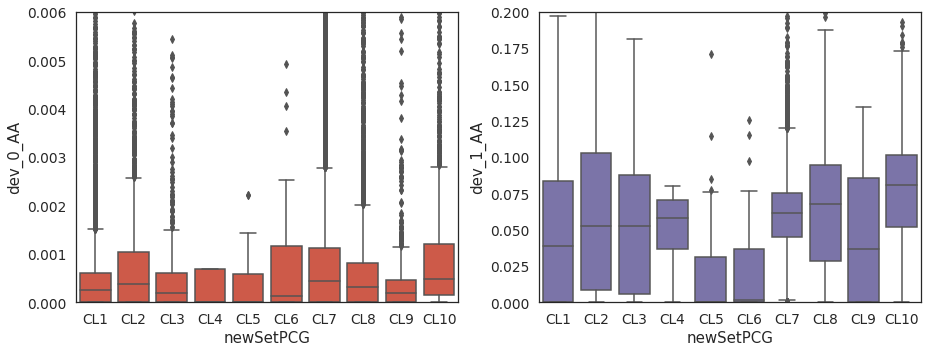

In [50]:
fig_args = dict(order = "CL" + pd.Series(range(1,11)).astype(str) )

fig, axs = plt.subplots(ncols = 2, figsize = (13, 5))


sns.boxplot(data = combined_mcs_f2s['avg_dev_gene'], x = "newSetPCG", y = "dev_0_AA", order = fig_args['order'], ax = axs.flat[0], color = cb.sequential.OrRd_6.hex_colors[4])
axs.flat[0].set_ylim(0, 0.006)


sns.boxplot(data = combined_mcs_f2s['avg_dev_gene'], x = "newSetPCG", y = "dev_1_AA", order = fig_args['order'], ax = axs.flat[1], color = cb.sequential.Purples_6.hex_colors[4])
axs.flat[1].set_ylim(0, 0.2)


fig.tight_layout()
plt.show()

In [53]:
sp.stats.spearmanr(combined_mcs_f2s['avg_dev_gene'].loc[combined_mcs_f2s['avg_dev_gene']['dev_1_AA'] > 0, 'h2az'],combined_mcs_f2s['avg_dev_gene'].loc[combined_mcs_f2s['avg_dev_gene']['dev_1_AA'] > 0, 'dev_1_AA'])

SpearmanrResult(correlation=0.13717159926661102, pvalue=1.3403121090365406e-40)

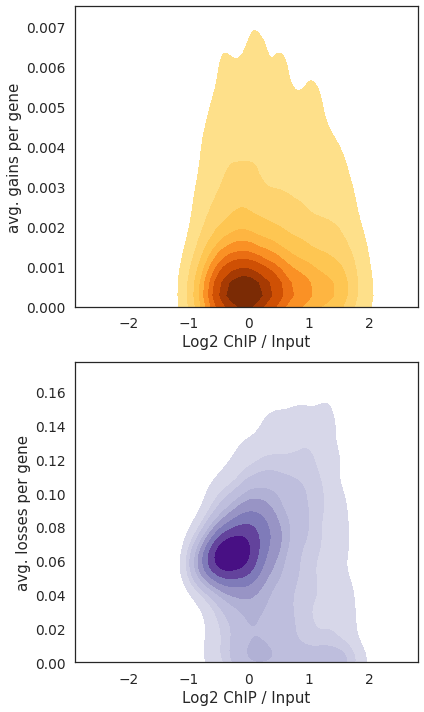

In [48]:
ef_data = combined_mcs_f2s['avg_dev_gene'].loc[:,["h2az","dev_0_AA", "dev_1_AA"]].dropna()


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 10))


sns.kdeplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], ax = axs.flat[0], fill = True, cmap = matplotlib.colors.ListedColormap( matplotlib.cm.YlOrBr(np.linspace(0, 1, 20))[5:,:-1] ), levels = 10) #color=cb.sequential.YlOrBr_5.hex_colors[2])
# axs.flat[0].set_xlabel(r'$ log_2{\frac{ChIP \; H2A.Z}{Input}} \; Col-0 $')
axs.flat[0].set_xlabel('Log2 ChIP / Input')
axs.flat[0].set_ylabel('avg. gains per gene')
axs.flat[0].set_ylim(0, 0.0075)


sns.kdeplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], ax = axs.flat[1], fill = True, cmap = matplotlib.colors.ListedColormap( matplotlib.cm.Purples(np.linspace(0, 1, 20))[5:,:-1] ), levels = 10 ) #color=cb.sequential.Purples_5.hex_colors[2])
# axs.flat[1].set_xlabel(r'$ log_2{\frac{ChIP \; H2A.Z}{Input}} \; Col-0 $')
axs.flat[1].set_xlabel('Log2 ChIP / Input')
axs.flat[1].set_ylabel('avg. losses per gene')
axs.flat[1].set_ylim(0, 0.178)


fig.tight_layout()


plt.savefig("h2az_epimutations.pdf", bbox_inches='tight', dpi = 300)

plt.show()

SpearmanrResult(correlation=-0.12688788968236056, pvalue=7.451570858028125e-38)


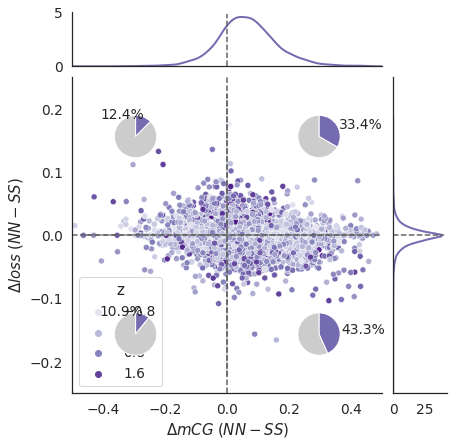

In [262]:
ef_data = combined_mcs_f2s['avg_dev_gene'].copy()
ef_data = ef_data.loc[~ef_data['dev_1_AA'].isna() & ~ef_data['dev_1_BB'].isna(),:]
ef_data = pd.DataFrame(dict(x = ef_data['CG_P_6046'] - ef_data['CG_P_6191'], y = ef_data['dev_1_AA'] - ef_data['dev_1_BB'], z = ef_data['h2az']  ) ).dropna()
# ef_data = ef_data[ef_data.index.str.contains("^AT[23]G", regex = True)]
print(sp.stats.spearmanr(ef_data.iloc[:,0], ef_data.iloc[:,1]  ))
common_reqcond = dict(xlim=(-0.5, 0.5), ylim=(-0.25, 0.25), color = cb.sequential.Purples_5.hex_colors[3],  center = 0)
pie_options = dict(xlim=(-1, 1), ylim=(-1,1), center = 0, xpie = (-0.65,0.65), ypie = (-0.7, 0.7), pie_rad = 0.15, color = common_reqcond['color'] ) 



p = sns.JointGrid(marginal_ticks=True)
p.ax_joint.plot((common_reqcond['center'],common_reqcond['center']), common_reqcond['ylim'], '--', color = "#636363")
p.ax_joint.plot(common_reqcond['xlim'], (common_reqcond['center'], common_reqcond['center']), '--', color = "#636363")

p.ax_joint.set(xlim=common_reqcond['xlim'],ylim = common_reqcond['ylim'])
sns.scatterplot(x = ef_data['x'], y = ef_data['y'], hue = ef_data['z'], palette="Purples", ax = p.ax_joint, rasterized =True)
sns.kdeplot(x= ef_data['x'], linewidth=2, ax=p.ax_marg_x, color=common_reqcond['color'])
p.ax_marg_x.vlines(x = 0, ymin = 0, ymax = p.ax_marg_x.get_ylim()[1], linestyle = '--', color = "#636363" )
p.ax_marg_x.set_ylabel("")
sns.kdeplot(y= ef_data['y'], linewidth=2, ax=p.ax_marg_y, color=common_reqcond['color'])
p.ax_marg_y.hlines(y = 0, xmin = 0, xmax = p.ax_marg_y.get_xlim()[1], linestyle = '--', color = "#636363" )
p.ax_marg_y.set_xlabel("")

pie_ax  = p.fig.add_axes(p.ax_joint.get_position(), frameon=False )
bshap.plotting._quadrant_plot_yolk(x = ef_data['x'], y = ef_data['y'], axs =  pie_ax, plt_options=pie_options )
pie_ax.set_yticklabels([])
pie_ax.set_xticklabels([])

p.ax_joint.set_xlabel(r'${\Delta}mCG \; (NN - SS) $')
p.ax_joint.set_ylabel(r'${\Delta}loss \; (NN - SS) $')


plt.show()



In [20]:
%%time
newSetPCG = pd.read_csv( "/groups/nordborg/projects/cegs/rahul/011.states.bhagyshree/002.GeneClusters/nCL.bed", sep = "\t", header=None )
newSetPCG = newSetPCG.loc[newSetPCG.iloc[:,3].isin( tair10.genes.iloc[:,3] ),:]
# deviations_aragenes = h5.File( perc_meths_folder + "/calculate_deviations/deviations_aragene_exons_d1.h5", 'r' )
req_data = {}


# req_data['data'] = pd.DataFrame(index = combined_mcs_f2s['meths'].file_ids )
# for ef_gene_cl in newSetPCG.groupby(6):
#     ef_gene_ix = np.where(np.isin(np.array(combined_mcs_f2s['devs']['gene_ids']).astype('U'), ef_gene_cl[1].iloc[:,3].values ))[0]
#     ef_devs = derive_pheno_h5_values(combined_mcs_f2s['devs'], ef_gene_ix)
#     req_data['data'] = pd.merge(req_data['data'], ef_devs.add_suffix( ":" + ef_gene_cl[0] ), left_index=True, right_index=True )    
# req_data['data'].to_csv("cache_data/epimutation_rates_gene_ncls.csv")

req_data['data'] = pd.read_csv("cache_data/epimutation_rates_gene_ncls.csv", index_col=0) 


req_data['dev_0'] = req_data['data'].loc[:,req_data['data'].columns.str.contains("deviation_0_nonpoly")]
req_data['dev_0'] = req_data['dev_0'][req_data['dev_0'].isna().sum(1) < 3 ]#.sample(frac = 1 )
req_data['dev_0'].columns = pd.Series(req_data['dev_0'].columns).str.replace("deviation_0_nonpoly:", "")
req_data['dev_0'] = req_data['dev_0'].loc[:,'CL' + pd.Series(np.arange(1,11)).astype(str)]

req_data['dev_1'] = req_data['data'].loc[:,req_data['data'].columns.str.contains("deviation_1_nonpoly")]
req_data['dev_1'] = req_data['dev_1'][req_data['dev_1'].isna().sum(1) < 3 ]#.sample(frac = 1 )
req_data['dev_1'].columns = pd.Series(req_data['dev_1'].columns).str.replace("deviation_1_nonpoly:", "")
req_data['dev_1'] = req_data['dev_1'].loc[:,'CL' + pd.Series(np.arange(1,11)).astype(str)]

CPU times: user 40.7 ms, sys: 1.03 ms, total: 41.7 ms
Wall time: 41.1 ms


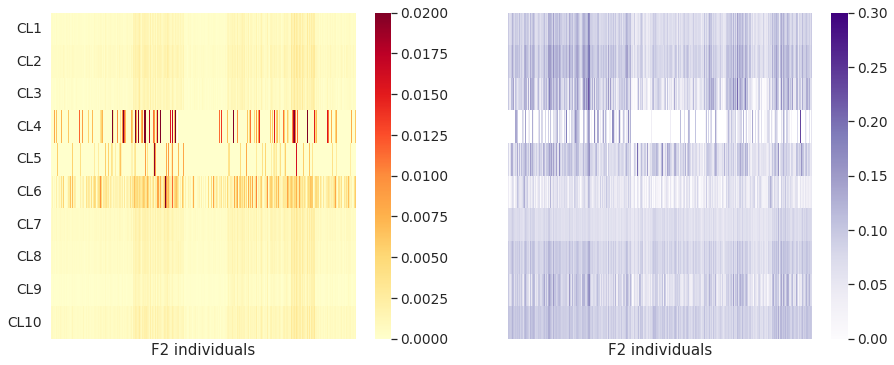

In [38]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 6), sharey=True)

sns.heatmap(req_data['dev_0'].T, cmap = "YlOrRd", vmin=0, vmax = 0.02, ax=axs.flat[0], xticklabels=False)#, cbar_kws = dict(use_gridspec=False,location="bottom"))
axs.flat[0].set_xlabel("F2 individuals")
axs.flat[0].set_yticklabels(axs.flat[0].get_yticklabels(), rotation=0)
# , rotation = 0, fontsize = 8

sns.heatmap(req_data['dev_1'].T, cmap = "Purples", vmin=0, vmax = 0.3, ax=axs.flat[1], xticklabels=False) #, cbar_kws = dict(use_gridspec=False,location="bottom"))
axs.flat[1].set_xlabel("F2 individuals")



# fig.tight_layout()
plt.show()

In [63]:
Annotator._get_tukeyLetters(ef_data['value'], ef_data['variable'] , alpha=0.01 )

CL1     bc
CL10    ab
CL2      a
CL3     cd
CL4     de
CL5     cd
CL6      f
CL7      e
CL8     bc
CL9     cd
dtype: object

CL1     bc
CL10    ab
CL2      a
CL3      c
CL4     df
CL5      c
CL6      e
CL7      d
CL8     bc
CL9     cf
dtype: object

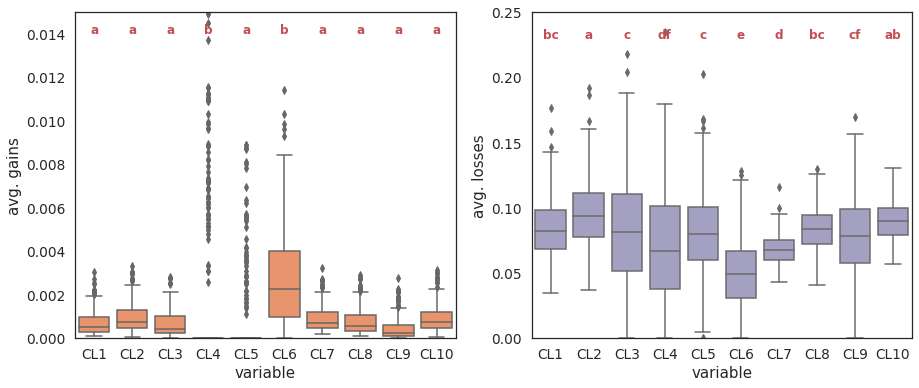

In [ ]:
fig_args = dict(xorder = "CL" + pd.Series(range(1,11)).astype(str) )
anno_args = dict(horizontalalignment='center', size='large', weight='semibold', color='r')

fig, axs = plt.subplots(ncols = 2, figsize = (15, 6))
 # scale = "width", cut = 0

ef_data = pd.melt(req_data['dev_0'].reset_index(), id_vars=['index'], value_vars=fig_args['xorder'])
sns.boxplot( data = ef_data, x = "variable", y = "value", ax=axs.flat[0], color=cb.sequential.OrRd_5.hex_colors[2])
axs.flat[0].set_ylim(0, 0.015)
axs.flat[0].set_ylabel("avg. gains")
Annotator.add_tukeyletter(fig_args=dict(data = ef_data, x = 'variable', y =  "value", order = fig_args['xorder'] ), axs=axs.flat[0], text_y_pos = 0.014, **anno_args)


ef_data = pd.melt(req_data['dev_1'].reset_index(), id_vars=['index'], value_vars=fig_args['xorder'])
sns.boxplot( data = ef_data, x = "variable", y = "value", ax=axs.flat[1], color=cb.sequential.Purples_5.hex_colors[2])
axs.flat[1].set_ylim(0, 0.25)
axs.flat[1].set_ylabel("avg. losses")
Annotator.add_tukeyletter(fig_args=dict(data = ef_data, x = 'variable', y =  "value", order = fig_args['xorder'] ), axs=axs.flat[1], text_y_pos = 0.23, **anno_args)

# print(Annotator._get_tukeyLetters(ef_data['value'], ef_data['variable'] , alpha=0.01 ))

In [31]:
print((-ef_data.loc[ef_data['variable'] == 'nSetPCG_1','value'].mean() + ef_data.loc[ef_data['variable'] == 'nSetPCG_8','value'].mean()) / ef_data.loc[ef_data['variable'] == 'nSetPCG_1','value'].mean())

print((ef_data.loc[ef_data['variable'] == 'nSetPCG_8','value'].mean()) / ef_data.loc[ef_data['variable'] == 'nSetPCG_1','value'].mean())

1.832529612693044
2.832529612693044


In [10]:
pyquant.stats.perform_tukey_hsd(ef_data['value'], ef_data['variable'], groups_order=['nSetPCG_1','nSetPCG_8'] )

group1 group2  meandiff  p-adj   lower  upper  reject
1_2      1      2    0.0016   -0.0  0.0013  0.002    True

CL1     bc
CL10    ab
CL2      a
CL3     cd
CL4     de
CL5     cd
CL6      f
CL7      e
CL8     bc
CL9     cd
dtype: object


<AxesSubplot:xlabel='variable', ylabel='value'>

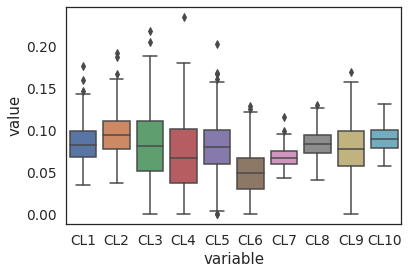

In [32]:
ef_data = pd.melt(req_data['dev_1'].reset_index(), id_vars=['index'], value_vars="CL" + pd.Series(range(1,11)).astype(str))
print(Annotator._get_tukeyLetters(ef_data['value'], ef_data['variable'] , alpha=0.01 ))
sns.boxplot( data = ef_data, x = "variable", y = "value")

In [ ]:
pyquant.stats.perform_tukey_hsd(ef_data['value'], ef_data['variable'], groups_order=['nSetPCG_1','nSetPCG_2'] )

group1 group2  meandiff  p-adj   lower   upper  reject
1_2      1      2    0.0156   -0.0  0.0127  0.0186    True

In [33]:
print((-ef_data.loc[ef_data['variable'] == 'nSetPCG_1','value'].mean() + ef_data.loc[ef_data['variable'] == 'nSetPCG_2','value'].mean()) / ef_data.loc[ef_data['variable'] == 'nSetPCG_1','value'].mean())

print((ef_data.loc[ef_data['variable'] == 'nSetPCG_2','value'].mean()) / ef_data.loc[ef_data['variable'] == 'nSetPCG_1','value'].mean())

0.22979911324852179
1.2297991132485218


## Calculate deviations for 0 and 1 across genome

In [103]:
%%time

# mc_data = pd.DataFrame( index = combined_mcs_f2s['meths'].file_ids )

# for ef_window in tair10.iter_positions_in_windows( tair10.genes, 500000 ):
#     ef_window_str = ef_window[0] + ',' + str(ef_window[1][0]) + "," + str(ef_window[1][1])
#     if ef_window[2].shape[0] > 0:
#         ef_gene_ix = np.where(np.isin(np.array(combined_mcs_f2s['devs']['gene_ids']).astype('U'), tair10.genes.iloc[ef_window[2], 3] ))[0]
#         ef_devs = derive_pheno_h5_values(combined_mcs_f2s['devs'], ef_gene_ix)
#         ef_devs['subpop'] = cross_data.get_genotype_dict_at_bed_str("d1_2020",ef_window_str)[1]['geno']
#         mc_data = pd.merge(mc_data, ef_devs.add_suffix(":" + ef_window_str), left_index=True, right_index=True )
# mc_data.to_csv("cache_data/epimutation_rates_500Kb_rep2.csv")

mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb_rep2.csv", index_col=0)

mc_data = pd.merge(combined_mcs_f2s['samples'], mc_data, left_index=True, right_index=True)

CPU times: user 188 ms, sys: 8.87 ms, total: 197 ms
Wall time: 305 ms


In [104]:
%%time

# mc_data = pd.DataFrame( index = combined_mcs_f2s['meths_d2'].file_ids )

# for ef_window in tair10.iter_positions_in_windows( tair10.genes, 500000 ):
#     ef_window_str = ef_window[0] + ',' + str(ef_window[1][0]) + "," + str(ef_window[1][1])
#     if ef_window[2].shape[0] > 0:
#         ef_gene_ix = np.where(np.isin(np.array(combined_mcs_f2s['devs_d2']['gene_ids']).astype('U'), tair10.genes.iloc[ef_window[2], 3] ))[0]
#         ef_devs = derive_pheno_h5_values(combined_mcs_f2s['devs_d2'], ef_gene_ix)
#         ef_devs['subpop'] = cross_data.get_genotype_dict_at_bed_str("d2_2020",ef_window_str)[1]['geno']
#         mc_data = pd.merge(mc_data, ef_devs.add_suffix(":" + ef_window_str), left_index=True, right_index=True )
# mc_data.to_csv("cache_data/epimutation_rates_500Kb_d2_rep2.csv")

mc_data_d2 = pd.read_csv("cache_data/epimutation_rates_500Kb_d2_rep2.csv", index_col=0)

mc_data_d2 = pd.merge(cross_data.ids_d2_2020, mc_data_d2, left_index=True, right_index=True)

CPU times: user 167 ms, sys: 14.9 ms, total: 182 ms
Wall time: 393 ms


In [105]:
%%time

# mc_data = pd.DataFrame( index = combined_mcs_f2s['meths'].file_ids )
# for ef_bin in enumerate(tair10.iter_windows(window_size=500000)):
#     ef_bin_str = ef_bin[1][0] + "," + str(ef_bin[1][1])
#     ef_bin_str = ef_bin_str + "," + str(min(pd.Series(tair10.golden_chrlen, tair10.chrs).loc[ef_bin[1][0]], ef_bin[1][2] ))
#     try:
#         ef_bin_deviations = get_deviations(ef_bin_str, combined_mcs_f2s['meths'], cross_data, "d1_2020").deviations
#         ef_bin_deviations.columns = ef_bin_deviations.columns + ":" + ef_bin_str
#         mc_data = pd.merge(mc_data, ef_bin_deviations, how = "left", right_index=True, left_index=True )
#     except:
#         continue

# mc_data.to_csv("cache_data/epimutation_rates_500Kb_rep2.csv")
# mc_data.to_csv("cache_data/epimutation_rates_onlyGBM_500Kb.csv")


# mc_data = pd.DataFrame( index = combined_mcs_f2s['meths_d2'].file_ids )
# for ef_bin in enumerate(tair10.iter_windows(window_size=500000)):
#     ef_bin_str = ef_bin[1][0] + "," + str(ef_bin[1][1])
#     ef_bin_str = ef_bin_str + "," + str(min(pd.Series(tair10.golden_chrlen, tair10.chrs).loc[ef_bin[1][0]], ef_bin[1][2] ))
#     try:
#         ef_bin_deviations = get_deviations(ef_bin_str, combined_mcs_f2s['meths_d2'], cross_data, "d2_2020")
#         ef_bin_deviations.columns = ef_bin_deviations.columns + ":" + ef_bin_str
#         mc_data = pd.merge(mc_data, ef_bin_deviations, how = "left", right_index=True, left_index=True )
#     except:
#         continue 

# ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0")].apply(lambda x: calc_residuals(x, 100 - combined_mcs_f2s['samples']['conv_rate'].reindex( mc_data.index )), axis = 0)
# ef_data.columns = ef_data.columns.str.replace("deviation_0", "resid_0")
# mc_data = pd.merge(mc_data, ef_data, left_index=True, right_index=True)

# ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1")].apply(lambda x: calc_residuals(x, 100 - combined_mcs_f2s['samples']['conv_rate'].reindex( mc_data.index )), axis = 0)
# ef_data.columns = ef_data.columns.str.replace("deviation_1", "resid_1")
# mc_data = pd.merge(mc_data, ef_data, left_index=True, right_index=True)
# mc_data.to_csv("cache_data/epimutation_rates_d2_500Kb.csv")



# mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb.csv", index_col=0)
# mc_data = pd.read_csv("cache_data/epimutation_rates_onlyGBM_500Kb.csv", index_col=0)

# mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb_rep2.csv", index_col = 0)
# mc_data = pd.read_csv("cache_data/epimutation_rates_d2_500Kb.csv", index_col=0)
# mc_data = pd.read_csv("cache_data/epimutation_rates_d2_2mb.csv", index_col=0)


# mc_data = pd.merge(combined_mcs_f2s['samples'], mc_data, left_index=True, right_index=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


/tmp/ipykernel_30073/1735332673.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


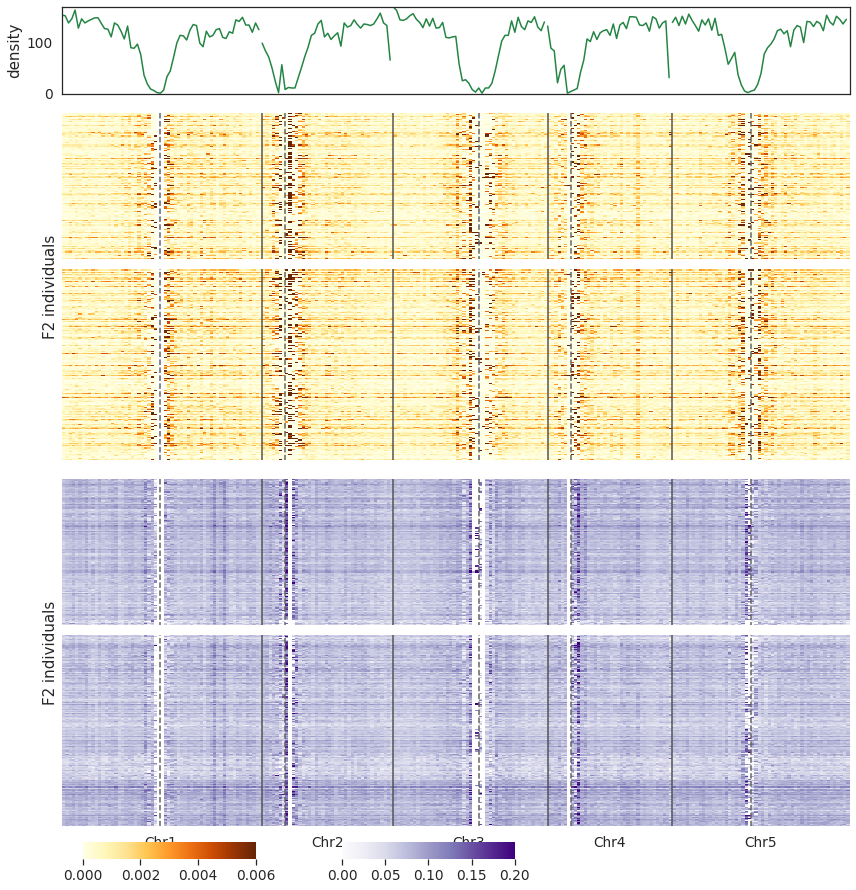

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols=1, sharex = True, gridspec_kw={'height_ratios': [0.5, 2, 2]}, figsize = (12, 12))
cbar_gain_ax = fig.add_axes([0.1, .001, .2, .02])
cbar_loss_ax = fig.add_axes([0.4, .001, .2, .02])

plotting_along_genome.density_line_plot_positions( tair10.genes, axs= axes.flat[0], plt_options={'nsmooth': 0, "window_size": 500000, "plt_xindex": True, "gap": 0, "xlabel": "" } )


ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")].copy()
ef_data.columns = tair10.get_genomewide_inds(pd.Series(ef_data.columns.str.replace("deviation_0_nonpoly:", "")))
ef_data = ef_data[((ef_data.isna().sum(1) / ef_data.shape[1]) < 0.3)]
ef_order = pyquant.utils.marker_to_int(mc_data['temp'].sample(frac=1),marker_ids=['T16','T4'] ).sort_values()

# ef_data = ef_data.sample(frac=1)

plotting_along_genome.generate_heatmap_genomewide(ef_data.loc[ef_order.index,:], axs=axes.flat[1], plt_options = {"lims": (0, 0.006), "cmap": "YlOrBr", "title": "", "ylabel": "F2 individuals" }, cbar_ax = cbar_gain_ax, cbar_kws={"orientation": "horizontal"})
axes.flat[1].axhline(np.where(ef_data.index.str.startswith('T4'))[0][0], color='white', lw=10)


ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")].copy()
ef_data.columns = tair10.get_genomewide_inds(pd.Series(ef_data.columns.str.replace("deviation_1_nonpoly:", "")))
ef_data = ef_data[((ef_data.isna().sum(1) / ef_data.shape[1]) < 0.3)]
ef_order = pyquant.utils.marker_to_int(mc_data['temp'].sample(frac=1),marker_ids=['T16','T4'] ).sort_values()
# ef_data = ef_data.sample(frac=1)

plotting_along_genome.generate_heatmap_genomewide(ef_data, axs=axes.flat[2], plt_options = {"lims": (0, 0.2), "cmap": "Purples", "title": "", "ylabel": "F2 individuals" }, cbar_ax = cbar_loss_ax, cbar_kws={"orientation": "horizontal"})
axes.flat[2].axhline(np.where(ef_data.index.str.startswith('T4'))[0][0], color='white', lw=10)


plt.tight_layout()
plt.savefig("gains_losses_genome.pdf",bbox_inches='tight', dpi = 300 )
plt.show()

In [30]:
def provide_means(part_mc_data):
    ef_data = part_mc_data.loc[:,part_mc_data.columns.str.startswith("deviation_0_nonpoly")].copy()
    ef_data.columns = pd.Series(ef_data.columns.str.replace("deviation_0_nonpoly:", ""))
    ef_data = ef_data[((ef_data.isna().sum(1) / ef_data.shape[1]) < 0.3)]
    ef_data = ef_data.sample(frac=1)
    print( "mean gain: %s" % ef_data.mean(1).mean() )
    ef_gains = ef_data
    centro_gains = ef_data.iloc[:,bshap.run_bedtools.get_intersect_bed_ix( reference_bed=pd.DataFrame({"chr": tair10.chrs, "start": tair10.centro_start, "end": tair10.centro_end}), query_bed=pd.Series(ef_data.columns).str.split(",", expand = True), just_names=False)['query_ix'].values]
    print( "mean gain at centromere: %s" % centro_gains.mean(1).mean() )
    
    ef_data = part_mc_data.loc[:,part_mc_data.columns.str.startswith("deviation_1_nonpoly")].copy()
    ef_data.columns = pd.Series(ef_data.columns.str.replace("deviation_1_nonpoly:", ""))
    ef_data = ef_data[((ef_data.isna().sum(1) / ef_data.shape[1]) < 0.3)]
    ef_data = ef_data.sample(frac=1)
    ef_losses = ef_data
    print( "mean loss: %s" % ef_data.mean(1).mean() )
    centro_losses = ef_data.iloc[:,bshap.run_bedtools.get_intersect_bed_ix( reference_bed=pd.DataFrame({"chr": tair10.chrs, "start": tair10.centro_start, "end": tair10.centro_end}), query_bed=pd.Series(ef_data.columns).str.split(",", expand = True), just_names=False)['query_ix'].values]
    print( "mean loss at centromere: %s" % centro_losses.mean(1).mean() )
    return((ef_gains, ef_losses, centro_gains, centro_losses))

def scale(x):
    return((x - np.nanmean(x))/np.nanstd(x))

    

In [14]:
_ = provide_means( mc_data )

mean gain: 0.0009765407236077141
mean gain at centromere: 0.0010936673839066502
mean loss: 0.07331738606294998
mean loss at centromere: 0.0831897715279584


In [42]:
ef_t16 = provide_means( mc_data_d2.loc[mc_data_d2['temp'] == 'T16'] )

mean gain: 0.0009734986535652645
mean gain at centromere: 0.0015352466221161133
mean loss: 0.07656812820198271
mean loss at centromere: 0.08864967074223812


In [43]:
ef_t4 = provide_means( mc_data_d2.loc[mc_data_d2['temp'] == 'T4']  )

mean gain: 0.0012475801903905478
mean gain at centromere: 0.0019123511909184263
mean loss: 0.0719603264279747
mean loss at centromere: 0.07984159548028212


In [92]:
ef_data = pd.DataFrame({'stat': ef_t16[0].loc[:,~ef_t16[0].columns.isin(ef_t16[2].columns)].mean(0).dropna(), "group": "random"})
ef_data = pd.concat([ef_data, pd.DataFrame({'stat': ef_t16[2].mean(0).dropna(), "group": "centro"})])
print(pyquant.stats.perform_tukey_hsd(ef_data['stat'], ef_data['group'], groups_order=['centro','random'] ))


ef_data = pd.DataFrame({'stat': ef_t16[1].loc[:,~ef_t16[1].columns.isin(ef_t16[3].columns)].mean(0).dropna(), "group": "random"})
ef_data = pd.concat([ef_data, pd.DataFrame({'stat': ef_t16[3].mean(0).dropna(), "group": "centro"})])
print(pyquant.stats.perform_tukey_hsd(ef_data['stat'], ef_data['group'], groups_order=['centro','random'] ))

    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0002  0.5144 -0.0008  0.0005   False
    group1 group2  meandiff  p-adj   lower   upper  reject
1_2      1      2    -0.022    0.0 -0.0313 -0.0127    True


In [56]:
(0.08718439503926043 - 0.07446855116415943)/ 0.07446855116415943

0.17075454908569426

In [55]:
(0.001083679696438289 -  0.0009258662078001361)/ 0.0009258662078001361

0.17044956097179387

In [22]:
ef_t4 = provide_means( mc_data.loc[mc_data['temp'] == 'T4'] )

mean gain: 0.0010155659254365386
mean gain at centromere: 0.0011013590512673423
mean loss: 0.07243085661719097
mean loss at centromere: 0.08011345227212809


In [57]:
pyquant.stats.perform_tukey_hsd(np.append(ef_t16[0].mean(1).values, ef_t4[0].mean(1).values), pd.Series(np.append(np.repeat("T16", ef_t16[0].shape[0]), np.repeat("T4", ef_t4[0].shape[0]))), groups_order=['T16','T4'] )

group1 group2  meandiff  p-adj   lower   upper  reject
1_2      1      2    0.0003  0.039 -0.0001  0.0006   False

In [15]:
pyquant.stats.perform_tukey_hsd(np.append(ef_t16[1].values, ef_t4[1].values), pd.Series(np.append(np.repeat("T16", ef_t16[1].shape), np.repeat("T4", ef_t4[1].shape))), groups_order=['T16','T4'] )

group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2    -0.002  0.1508 -0.0057  0.0016   False

In [58]:
(0.0010155659254365386 - 0.0009258662078001361)/0.0009258662078001361

0.09688194350405076

In [59]:
(0.07243085661719097 - 0.07446855116415943) / 0.07446855116415943

-0.02736315552153745

/tmp/ipykernel_66892/2898766290.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


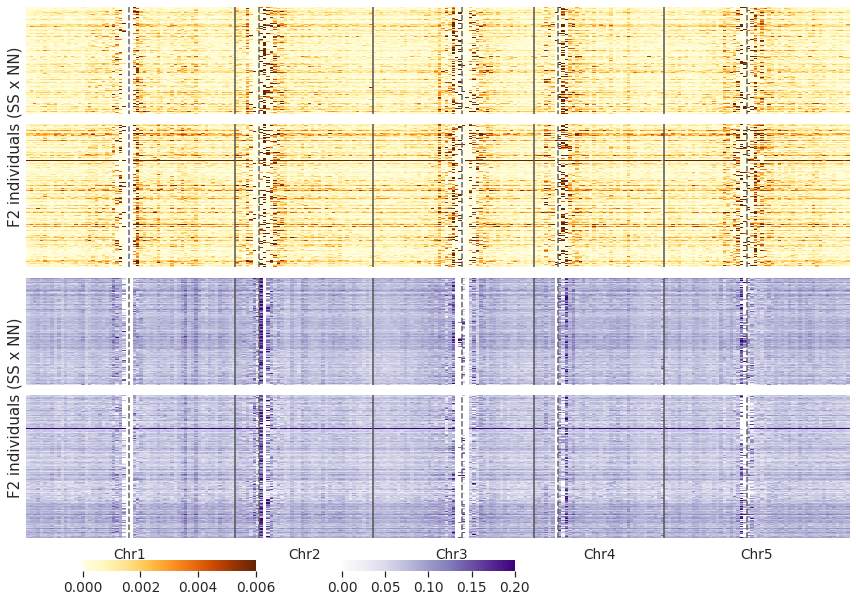

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols=1, sharex = True, gridspec_kw={'height_ratios': [1,1]}, figsize = (12, 8))
cbar_gain_ax = fig.add_axes([0.1, .001, .2, .02])
cbar_loss_ax = fig.add_axes([0.4, .001, .2, .02])


ef_data = mc_data_d2.loc[:,mc_data_d2.columns.str.startswith("deviation_0_nonpoly")].copy()
ef_data.columns = tair10.get_genomewide_inds(pd.Series(ef_data.columns.str.replace("deviation_0_nonpoly:", "")))
ef_data = ef_data[((ef_data.isna().sum(1) / ef_data.shape[1]) < 0.3)]
ef_order = pyquant.utils.marker_to_int(mc_data_d2['temp'].sample(frac=1),marker_ids=['T16','T4'] ).sort_values()

# ef_data = ef_data.sample(frac=1)

plotting_along_genome.generate_heatmap_genomewide(ef_data.loc[ef_order.index,:], axs=axes.flat[0], plt_options = {"lims": (0, 0.006), "cmap": "YlOrBr", "title": "", "ylabel": "F2 individuals (SS x NN)" }, cbar_ax = cbar_gain_ax, cbar_kws={"orientation": "horizontal"})
axes.flat[0].axhline(np.where(ef_data.index.str.startswith('T4'))[0][0], color='white', lw=10)


ef_data = mc_data_d2.loc[:,mc_data_d2.columns.str.startswith("deviation_1_nonpoly")].copy()
ef_data.columns = tair10.get_genomewide_inds(pd.Series(ef_data.columns.str.replace("deviation_1_nonpoly:", "")))
ef_data = ef_data[((ef_data.isna().sum(1) / ef_data.shape[1]) < 0.3)]
ef_order = pyquant.utils.marker_to_int(mc_data_d2['temp'].sample(frac=1),marker_ids=['T16','T4'] ).sort_values()
# ef_data = ef_data.sample(frac=1)

plotting_along_genome.generate_heatmap_genomewide(ef_data, axs=axes.flat[1], plt_options = {"lims": (0, 0.2), "cmap": "Purples", "title": "", "ylabel": "F2 individuals (SS x NN)" }, cbar_ax = cbar_loss_ax, cbar_kws={"orientation": "horizontal"})
axes.flat[1].axhline(np.where(ef_data.index.str.startswith('T4'))[0][0], color='white', lw=10)


plt.tight_layout()
plt.show()

NNxSS_T16    ab
NNxSS_T4     ac
SSxNN_T16     b
SSxNN_T4      c
dtype: object

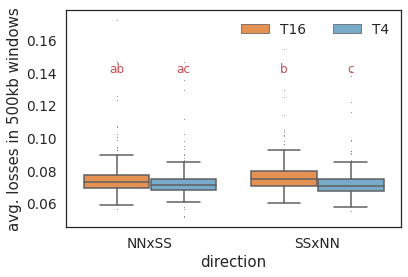

In [96]:
ef_data = {}

ef_data['1'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")].copy()
ef_data['1'].columns = pd.Series(ef_data['1'].columns.str.replace("deviation_1_nonpoly:", ""))
ef_data['1'] = ef_data['1'][((ef_data['1'].isna().sum(1) / ef_data['1'].shape[1]) < 0.3)]
ef_data['1']['temp'] = mc_data['temp']

ef_data['1'] = pd.melt(ef_data['1'].groupby('temp').mean(1).T)
ef_data['1']['direction'] = 'NNxSS'

ef_data['2'] = mc_data_d2.loc[:,mc_data_d2.columns.str.startswith("deviation_1_nonpoly")].copy()
ef_data['2'].columns = pd.Series(ef_data['2'].columns.str.replace("deviation_1_nonpoly:", ""))
ef_data['2'] = ef_data['2'][((ef_data['2'].isna().sum(1) / ef_data['2'].shape[1]) < 0.3)]
ef_data['2']['temp'] = mc_data_d2['temp']
ef_data['2'] = pd.melt(ef_data['2'].groupby('temp').mean(1).T)
ef_data['2']['direction'] = 'SSxNN'


ef_data = pd.concat([ef_data['1'], ef_data['2']])



anno_args = dict(horizontalalignment='center', size='large', weight='normal', color='r')

fig_args = dict(data = ef_data, y = "value", x = "direction", order = ['NNxSS', 'SSxNN'], hue = "temp", hue_order=['T16','T4'])

ax = sns.boxplot( **fig_args, palette=temp_color, fliersize=0.2 )
ax.legend(frameon = False, ncol = 2)
ax.set_ylabel("avg. losses in 500kb windows")
Annotator.add_tukeyletter(fig_args=fig_args, axs=ax, text_y_pos = 0.14, anno_args = anno_args )

NNxSS_T16    a
NNxSS_T4     a
SSxNN_T16    a
SSxNN_T4     b
dtype: object

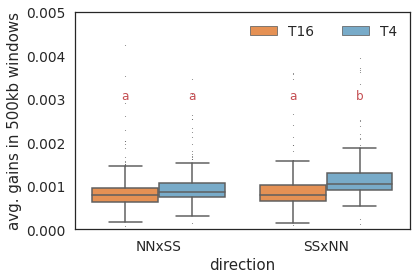

In [103]:
ef_data = {}

ef_data['1'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")].copy()
ef_data['1'].columns = pd.Series(ef_data['1'].columns.str.replace("deviation_0_nonpoly:", ""))
ef_data['1'] = ef_data['1'][((ef_data['1'].isna().sum(1) / ef_data['1'].shape[1]) < 0.3)]
ef_data['1']['temp'] = mc_data['temp']

ef_data['1'] = pd.melt(ef_data['1'].groupby('temp').mean(1).T)
ef_data['1']['direction'] = 'NNxSS'

ef_data['2'] = mc_data_d2.loc[:,mc_data_d2.columns.str.startswith("deviation_0_nonpoly")].copy()
ef_data['2'].columns = pd.Series(ef_data['2'].columns.str.replace("deviation_0_nonpoly:", ""))
ef_data['2'] = ef_data['2'][((ef_data['2'].isna().sum(1) / ef_data['2'].shape[1]) < 0.3)]
ef_data['2']['temp'] = mc_data_d2['temp']
ef_data['2'] = pd.melt(ef_data['2'].groupby('temp').mean(1).T)
ef_data['2']['direction'] = 'SSxNN'


ef_data = pd.concat([ef_data['1'], ef_data['2']])



anno_args = dict(horizontalalignment='center', size='large', weight='normal', color='r')

fig_args = dict(data = ef_data, y = "value", x = "direction", order = ['NNxSS', 'SSxNN'], hue = "temp", hue_order=['T16','T4'])

ax = sns.boxplot( **fig_args, palette=temp_color, fliersize=0.2 )
ax.legend(frameon = False, ncol = 2)
ax.set_ylabel("avg. gains in 500kb windows")
ax.set_ylim(0,0.005)
Annotator.add_tukeyletter(fig_args=fig_args, axs=ax, text_y_pos = 0.003, anno_args = anno_args )

In [24]:
pyquant.stats.perform_tukey_hsd(ef_data.iloc[:,1], ef_data.iloc[:,0], groups_order=['T16','T4'] )

group1 group2  meandiff  p-adj   lower   upper  reject
1_2      1      2   -0.0094    0.0 -0.0147 -0.0041    True

In [26]:
pyquant.stats.perform_tukey_hsd(ef_data.iloc[:,1], ef_data.iloc[:,0], groups_order=['T16','T4'] )

group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0052  0.0027 -0.0097 -0.0007    True

## QTL effect plots


With the given QTLs make the effect plots

In [24]:
%%time
# ns_genetic_map = pyquant.qtl_maps.readQTLresults(proj_dir + "/snps_bcftools/genotyper_final_D1.csv", proj_dir + "/epimutation_rates/qtl_maps_deviations_500Kb_rep1.hdf5", tair10 )
ns_genetic_map = pyquant.qtl_maps.readQTLresults(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D1.csv", proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/epimutation_rates/qtl_maps_deviations_500Kb_rep2.hdf5", tair10 )



def get_model(ns_qtl_maps_output, model_name):
    ef_data = ns_qtl_maps_output.get_matrix( model_name, ns_qtl_maps_output.gene_str.index.values )
    ef_data = ef_data.iloc[np.argsort(tair10.get_genomewide_inds(pd.Series(ef_data.index)))[::-1],:]
    return(ef_data)
    

ns_genetic_map.dev_0_f = get_model(ns_genetic_map, "deviation_0_nonpoly_intT")
ns_genetic_map.dev_0_a = get_model(ns_genetic_map, "deviation_0_nonpoly_addT")
ns_genetic_map.dev_0_0 = get_model(ns_genetic_map, "deviation_0_nonpoly")
ns_genetic_map.dev_1_f = get_model(ns_genetic_map, "deviation_1_nonpoly_intT")
ns_genetic_map.dev_1_a = get_model(ns_genetic_map, "deviation_1_nonpoly_addT")
ns_genetic_map.dev_1_0 = get_model(ns_genetic_map, "deviation_1_nonpoly")


CPU times: user 183 ms, sys: 56.4 ms, total: 239 ms
Wall time: 383 ms


In [39]:
%%time
def get_pheno_for_qtl(pheno_df, lod_matrix, qtl_markers, pheno_to_pick = "deviation_0_nonpoly", qtl_name_in_pheno= 'qtl_gain_'):
    req_lods = lod_matrix.loc[:,ns_genetic_map.markers_map.loc[qtl_markers, "genome_ix"].values].values
    qtl_pheno_df = pd.DataFrame()
    for ef_qtl_ix in range( len(qtl_markers) ):
        sig_regions = lod_matrix.index[np.where(req_lods[:,ef_qtl_ix] > 3)[0]]
        req_phenos = pd.melt(pheno_df.reset_index(), id_vars=["temp", 'index', qtl_name_in_pheno + str(ef_qtl_ix)], value_vars=pheno_to_pick + ":" + sig_regions, value_name="dev_" )
        req_phenos.columns = ["temp", 'sample_id', "genotype", "variable", pheno_to_pick]
        req_phenos['variable'] = req_phenos['variable'].str.replace(pheno_to_pick + ":", "")
        req_phenos['qtl_ix'] = qtl_name_in_pheno + str(ef_qtl_ix)
        qtl_pheno_df = pd.concat([qtl_pheno_df, req_phenos], ignore_index = True)
    return(qtl_pheno_df)


mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb_rep2.csv", index_col = 0)
qtl_genotypes_data = {}

## QTLs for CG gain 
qtls_gain = ["Chr1:5038757", "Chr3:11460783", "Chr5:15932197"]
qtl_genotypes_data['pheno'] = cross_data.get_genotype_marker("d1_2020", marker_id=pd.Series(qtls_gain) ).reset_index(drop = True).rename('qtl_gain_{}'.format).T

# ## QTLs for CG losses
qtls_loss = ["Chr1:21740818", "Chr4:5929511", "Chr5:16445720"]
qtl_genotypes_data['pheno'] = pd.merge(qtl_genotypes_data['pheno'], cross_data.get_genotype_marker("d1_2020", marker_id=pd.Series(qtls_loss) ).reset_index(drop = True).rename('qtl_loss_{}'.format).T, left_index=True, right_index=True )


qtl_genotypes_data['pheno_all'] = pd.merge(mc_data, qtl_genotypes_data['pheno'], left_index=True, right_index=True)
qtl_genotypes_data['pheno_all']['temp'] = combined_mcs_f2s['samples']['temp']
qtl_genotypes_data['pheno']['temp'] = combined_mcs_f2s['samples']['temp']


##### Take only the phenotypes(regions) where QTL is significant
qtl_genotypes_data['dev_0_nonpoly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_all'],ns_genetic_map.dev_0_f, qtls_gain, pheno_to_pick = "deviation_0_nonpoly", qtl_name_in_pheno= 'qtl_gain_' )
qtl_genotypes_data['dev_0_poly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_all'],ns_genetic_map.dev_0_f, qtls_gain, pheno_to_pick = "deviation_0_poly", qtl_name_in_pheno= 'qtl_gain_' )

qtl_genotypes_data['dev_1_nonpoly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_all'],ns_genetic_map.dev_1_f, qtls_loss, pheno_to_pick = "deviation_1_nonpoly", qtl_name_in_pheno= 'qtl_loss_' )
qtl_genotypes_data['dev_1_poly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_all'],ns_genetic_map.dev_1_f, qtls_loss, pheno_to_pick = "deviation_1_poly", qtl_name_in_pheno= 'qtl_loss_' )



##### Take average of all regions for each individual
#  = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")].mean(1)
# qtl_genotypes_data['pheno']['deviation_0_poly'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_poly")].mean(1)
# qtl_genotypes_data['pheno']['deviation_1_nonpoly'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")].mean(1)
# qtl_genotypes_data['pheno']['deviation_1_poly'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_poly")].mean(1)
for ef_qtl in ['qtl_gain_0', 'qtl_gain_1','qtl_gain_2']:
    qtl_genotypes_data['pheno']['deviation_0_nonpoly_' + ef_qtl ] = qtl_genotypes_data['dev_0_nonpoly'][qtl_genotypes_data['dev_0_nonpoly']['qtl_ix'] == ef_qtl].groupby("sample_id").mean()['deviation_0_nonpoly']
    qtl_genotypes_data['pheno']['deviation_0_poly_' + ef_qtl ] = qtl_genotypes_data['dev_0_poly'][qtl_genotypes_data['dev_0_poly']['qtl_ix'] == ef_qtl].groupby("sample_id").mean()['deviation_0_poly']
    
for ef_qtl in ['qtl_loss_0', 'qtl_loss_1','qtl_loss_2']:
    ef_data = qtl_genotypes_data['dev_1_nonpoly'][qtl_genotypes_data['dev_1_nonpoly']['qtl_ix'] == ef_qtl].groupby("sample_id")
    qtl_genotypes_data['pheno']['deviation_1_nonpoly_' + ef_qtl ] = ef_data.mean()['deviation_1_nonpoly']
    qtl_genotypes_data['pheno']['deviation_1_poly_' + ef_qtl ] = qtl_genotypes_data['dev_1_poly'][qtl_genotypes_data['dev_1_poly']['qtl_ix'] == ef_qtl].groupby("sample_id").mean()['deviation_1_poly']
    

CPU times: user 548 ms, sys: 22.5 ms, total: 571 ms
Wall time: 570 ms


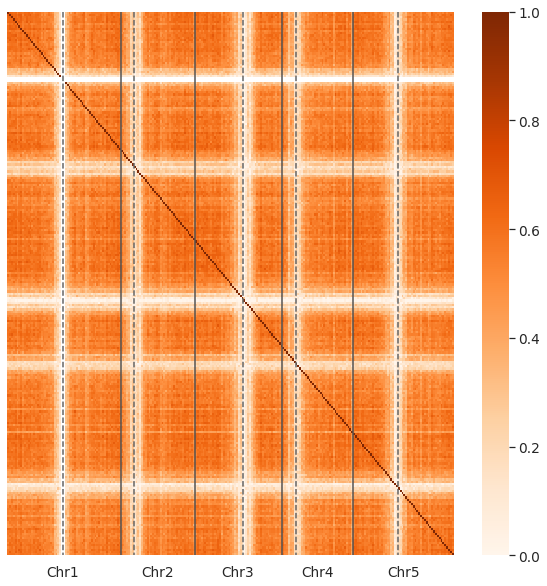

In [47]:
ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly:Chr")].dropna(how = "all").corr(method = "spearman")
ef_data.columns = pd.Series(ef_data.columns).str.replace("deviation_0_nonpoly:","")
ef_data.index = tair10.get_genomewide_inds( pd.Series(ef_data.index).str.replace("deviation_0_nonpoly:","") )


fig, axs = plt.subplots(figsize = (10,10))
plotting_along_genome.generate_heatmap_genomewide( ef_data, plt_options=dict(cmap="Oranges", chr_line_horizontal=False,chr_line_vertical=True, chr_line_centro=True, lims=(0, 1) ), axs=axs )

# plt.matshow( mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly:Chr")].dropna(how = "all").corr() )

plt.show()

In [11]:
# qtl_genotypes_data['pheno'].to_csv("cache_data/STable_average_deviations_across_windows.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AA vs. AB: Mann-Whitney-Wilcoxon test two-sided, P_val:9.898e-06 U_stat=7.904e+03
AB vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:1.497e-01 U_stat=5.343e+03
AA vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:5.980e-03 U_stat=3.588e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AA vs. AB: Mann-Whitney-Wilcoxon test two-sided, P_val:7.568e-04 U_stat=4.584e+03
AB vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:3.027e-04 U_stat=3.869e+03
AA vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:5.764e-08 U_stat=1.248e+03


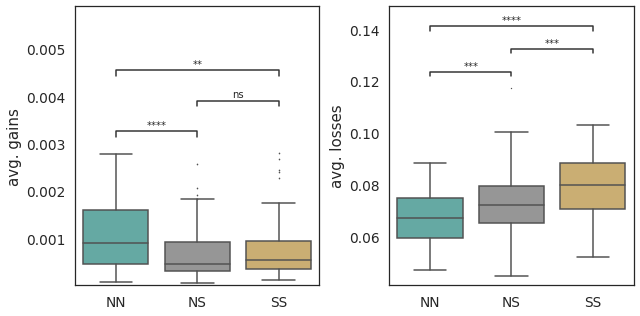

In [39]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside'
}
anno_args = dict(horizontalalignment='center', size='large', weight='semibold', color='r')


fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (9, 4.5))

fig_args = dict(
    data = qtl_genotypes_data['pheno'],
    x = "qtl_gain_0",
    y = "deviation_0_nonpoly_qtl_gain_0", 
    palette=geno_color, 
    order=['AA','AB','BB'],
    # order = ['T16', 'T4'],
    fliersize = 0.8,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, ax = axs  )
axs.set_ylim((0.00001, 0.0059))
axs.set_xlabel("")
# axs.legend(frameon = False, title = "", ncol = 3)
axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_ylabel("avg. gains")
# axs.set_xticks([0, 1], ['16C', '4C'])
# Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos=0.0045, anno_args=anno_args)
anno = Annotator.Annotator(axs, [('AA','BB'), ('AA','AB'), ('AB','BB')], data=fig_args['data'], x=fig_args['x'], y=fig_args['y'], order=fig_args['order'])
anno.configure(test='Mann-Whitney', text_format='star', loc='inside')
anno.apply_and_annotate()


fig_args = dict(
    data = qtl_genotypes_data['pheno'],
    x = "qtl_loss_1",
    y = "deviation_1_nonpoly_qtl_loss_1", 
    palette=geno_color, 
    order=['AA','AB','BB'],
    # order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[1]
sns.boxplot(**fig_args, ax = axs  )
# axs.set_ylim((0.00001, 0.0059))
axs.set_xlabel("")
# axs.legend(frameon = False, title = "", ncol = 3)
axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_ylabel("avg. losses")
anno = Annotator.Annotator(axs, [('AA','BB'), ('AA','AB'), ('AB','BB')], data=fig_args['data'], x=fig_args['x'], y=fig_args['y'], order=fig_args['order'])
anno.configure(test='Mann-Whitney', text_format='star', loc='inside')
anno.apply_and_annotate()

fig.tight_layout()

fig.savefig("test_qtls.pdf")

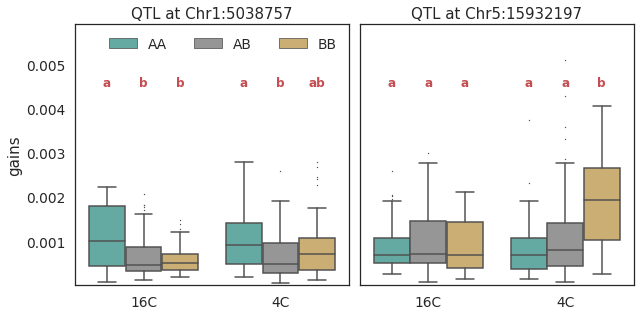

In [38]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside',
    "y_pos":0.0045
}
anno_args = dict(horizontalalignment='center', size='large', weight='semibold', color='r')


fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (9, 4.5), sharey='row', sharex = False)

fig_args = dict(
    data = qtl_genotypes_data['pheno'],
    hue = "qtl_gain_0",
    y = "deviation_0_nonpoly_qtl_gain_0", 
    x = "temp",
    palette=geno_color, 
    hue_order=['AA','AB','BB'],
    order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, ax = axs  )
axs.set_ylim((0.00001, 0.0059))
axs.set_xlabel("")
axs.legend(frameon = False, title = "", ncol = 3)
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])

axs.set_ylabel("gains")
axs.set_title( "QTL at " + qtls_gain[0] )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos=configuration['y_pos'], anno_args=anno_args)

# annotator = Annotator.Annotator(**fig_args, x = "qtl_gain_0", ax = axs, pairs = [ (('AA', 'T16'), ('AA', 'T4')), (('BB', 'T16'), ('BB', 'T4')) ], plot='violinplot')
# annotator.configure(**configuration).apply_and_annotate()


fig_args['hue'] = 'qtl_gain_2'
fig_args['y'] = 'deviation_0_nonpoly_qtl_gain_2'

axs = axes.flat[1]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos=configuration['y_pos'], anno_args=anno_args)
# axs.set_ylim((0, 0.005))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_gain[2] )



# handles, labels = axes.flat[0].get_legend_handles_labels()
# # When creating the legend, only use the first two elements
# # to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes.flat[0].get_legend().remove()


fig.tight_layout()

plt.savefig("qtl_effects_gains.pdf")

plt.show()

In [39]:
4.5 * 3

13.5

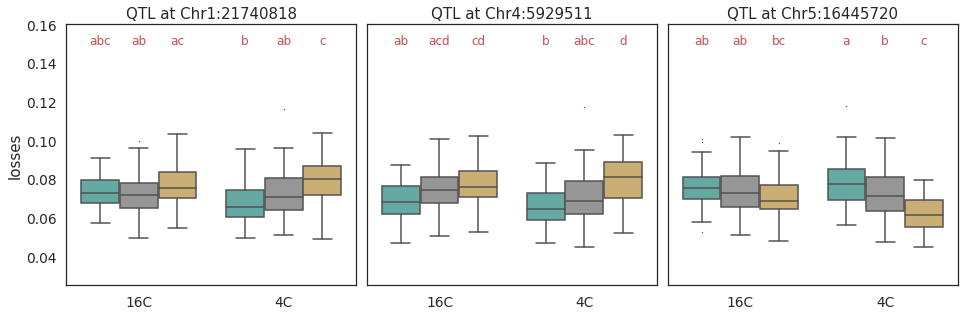

In [40]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside',
    "y_pos": 0.15
}
anno_args = dict(horizontalalignment='center', size='large', weight='normal', color='r')


fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (13.5, 4.5), sharey='row', sharex = False)

fig_args = dict(
    data = qtl_genotypes_data['pheno'],
    hue = "qtl_loss_0",
    y = "deviation_1_nonpoly_qtl_loss_0", 
    x = "temp",
    palette=geno_color, 
    hue_order=['AA','AB','BB'],
    order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, ax = axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], anno_args = anno_args )
axs.set_ylim((0.025, 0.16))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("losses")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_loss[0] )


fig_args['hue'] = 'qtl_loss_1'
fig_args['y'] = 'deviation_1_nonpoly_qtl_loss_1'


axs = axes.flat[1]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'],anno_args = anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_loss[1] )

fig_args['hue'] = 'qtl_loss_2'
fig_args['y'] = 'deviation_1_nonpoly_qtl_loss_2'
axs = axes.flat[2]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], anno_args = anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_loss[2] )



# handles, labels = axes.flat[0].get_legend_handles_labels()
# # When creating the legend, only use the first two elements
# # to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes.flat[0].get_legend().remove()

plt.savefig("qtl_effects_losses.pdf")
fig.tight_layout()
plt.show()

### reciprocal cross


In [43]:
ns_genetic_map_d2 = pyquant.qtl_maps.readQTLresults(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D2.csv", proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/epimutation_rates/qtl_maps_deviations_500Kb_d2_rep3.hdf5", tair10 )


ns_genetic_map_d2.dev_0_f = get_model(ns_genetic_map_d2, "deviation_0_nonpoly_intT")
ns_genetic_map_d2.dev_0_a = get_model(ns_genetic_map_d2, "deviation_0_nonpoly_addT")
ns_genetic_map_d2.dev_0_0 = get_model(ns_genetic_map_d2, "deviation_0_nonpoly")
ns_genetic_map_d2.dev_1_f = get_model(ns_genetic_map_d2, "deviation_1_nonpoly_intT")
ns_genetic_map_d2.dev_1_a = get_model(ns_genetic_map_d2, "deviation_1_nonpoly_addT")
ns_genetic_map_d2.dev_1_0 = get_model(ns_genetic_map_d2, "deviation_1_nonpoly")

In [44]:
%%time
mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb_d2_rep2.csv", index_col = 0)

## QTLs for CG gain 
qtls_gain = ["Chr2:11740264", "Chr5:8811039"] #["Chr1:5038757", "Chr3:11460783", "Chr5:15932197"]
qtl_genotypes_data['pheno_d2'] = cross_data.get_genotype_marker("d2_2020", marker_id=pd.Series(qtls_gain) ).reset_index(drop = True).rename('qtl_gain_{}'.format).T

# ## QTLs for CG losses
qtls_loss = ["Chr1:9931617", "Chr4:5365727","Chr5:15585328"] # ["Chr1:21740818", "Chr4:5929511", "Chr5:16445720"]
qtl_genotypes_data['pheno_d2'] = pd.merge(qtl_genotypes_data['pheno_d2'], cross_data.get_genotype_marker("d2_2020", marker_id=pd.Series(qtls_loss) ).reset_index(drop = True).rename('qtl_loss_{}'.format).T, left_index=True, right_index=True )


qtl_genotypes_data['pheno_d2_all'] = pd.merge(mc_data, qtl_genotypes_data['pheno_d2'], left_index=True, right_index=True)
qtl_genotypes_data['pheno_d2_all']['temp'] = combined_mcs_f2s['samples']['temp']
qtl_genotypes_data['pheno_d2']['temp'] = combined_mcs_f2s['samples']['temp']


# ##### Take only the phenotypes(regions) where QTL is significant
qtl_genotypes_data['dev_0_nonpoly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_d2_all'], ns_genetic_map_d2.dev_0_f, qtls_gain, pheno_to_pick = "deviation_0_nonpoly", qtl_name_in_pheno= 'qtl_gain_' )
qtl_genotypes_data['dev_0_poly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_d2_all'], ns_genetic_map_d2.dev_0_f, qtls_gain, pheno_to_pick = "deviation_0_poly", qtl_name_in_pheno= 'qtl_gain_' )

qtl_genotypes_data['dev_1_nonpoly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_d2_all'], ns_genetic_map_d2.dev_1_f, qtls_loss, pheno_to_pick = "deviation_1_nonpoly", qtl_name_in_pheno= 'qtl_loss_' )
qtl_genotypes_data['dev_1_poly'] = get_pheno_for_qtl(qtl_genotypes_data['pheno_d2_all'], ns_genetic_map_d2.dev_1_f, qtls_loss, pheno_to_pick = "deviation_1_poly", qtl_name_in_pheno= 'qtl_loss_' )



##### Take average of all regions for each individual
qtl_genotypes_data['pheno_d2']['deviation_0_nonpoly'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")].mean(1)
qtl_genotypes_data['pheno_d2']['deviation_1_nonpoly'] = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")].mean(1)


for ef_qtl in ['qtl_gain_0', 'qtl_gain_1','qtl_gain_2']:
    qtl_genotypes_data['pheno_d2']['deviation_0_nonpoly_' + ef_qtl ] = qtl_genotypes_data['dev_0_nonpoly'][qtl_genotypes_data['dev_0_nonpoly']['qtl_ix'] == ef_qtl].groupby("sample_id").mean()['deviation_0_nonpoly']
    qtl_genotypes_data['pheno_d2']['deviation_0_poly_' + ef_qtl ] = qtl_genotypes_data['dev_0_poly'][qtl_genotypes_data['dev_0_poly']['qtl_ix'] == ef_qtl].groupby("sample_id").mean()['deviation_0_poly']
    
for ef_qtl in ['qtl_loss_0', 'qtl_loss_1','qtl_loss_2']:
    ef_data = qtl_genotypes_data['dev_1_nonpoly'][qtl_genotypes_data['dev_1_nonpoly']['qtl_ix'] == ef_qtl].groupby("sample_id")
    qtl_genotypes_data['pheno_d2']['deviation_1_nonpoly_' + ef_qtl ] = ef_data.mean()['deviation_1_nonpoly']
    qtl_genotypes_data['pheno_d2']['deviation_1_poly_' + ef_qtl ] = qtl_genotypes_data['dev_1_poly'][qtl_genotypes_data['dev_1_poly']['qtl_ix'] == ef_qtl].groupby("sample_id").mean()['deviation_1_poly']
    

CPU times: user 405 ms, sys: 14.5 ms, total: 419 ms
Wall time: 418 ms


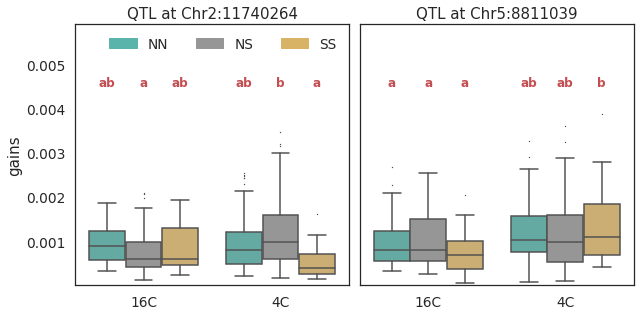

In [206]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside',
    "y_pos":0.0045,
    "alpha": 0.05
}
anno_args = dict(horizontalalignment='center', size='large', weight='semibold', color='r')


fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (9, 4.5), sharey='row', sharex = False)

fig_args = dict(
    data = qtl_genotypes_data['pheno_d2'],
    hue = "qtl_gain_0",
    y = "deviation_0_nonpoly_qtl_gain_0", 
    x = "temp",
    palette=geno_color, 
    hue_order=['AA','AB','BB'],
    order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, ax = axs  )
axs.set_ylim((0.00001, 0.0059))
axs.set_xlabel("")
axs.legend([matplotlib.patches.Patch(color=geno_color[ef]) for ef in ['AA','AB','BB']], ['NN','NS','SS'], frameon = False, title = "", ncol = 3)
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])

axs.set_ylabel("gains")
axs.set_title( "QTL at " + qtls_gain[0] )
Annotator.add_tukeyletter(fig_args=fig_args, alpha = configuration['alpha'], axs=axs, text_y_pos=configuration['y_pos'], anno_args=anno_args)

# annotator = Annotator.Annotator(**fig_args, x = "qtl_gain_0", ax = axs, pairs = [ (('AA', 'T16'), ('AA', 'T4')), (('BB', 'T16'), ('BB', 'T4')) ], plot='violinplot')
# annotator.configure(**configuration).apply_and_annotate()


fig_args['hue'] = 'qtl_gain_1'
fig_args['y'] = 'deviation_0_nonpoly_qtl_gain_1'

axs = axes.flat[1]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs,  alpha = configuration['alpha'], text_y_pos=configuration['y_pos'], anno_args=anno_args)
# axs.set_ylim((0, 0.005))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_gain[1] )



# handles, labels = axes.flat[0].get_legend_handles_labels()
# # When creating the legend, only use the first two elements
# # to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes.flat[0].get_legend().remove()


fig.tight_layout()

# plt.savefig("qtl_effects_gains.pdf")

plt.show()

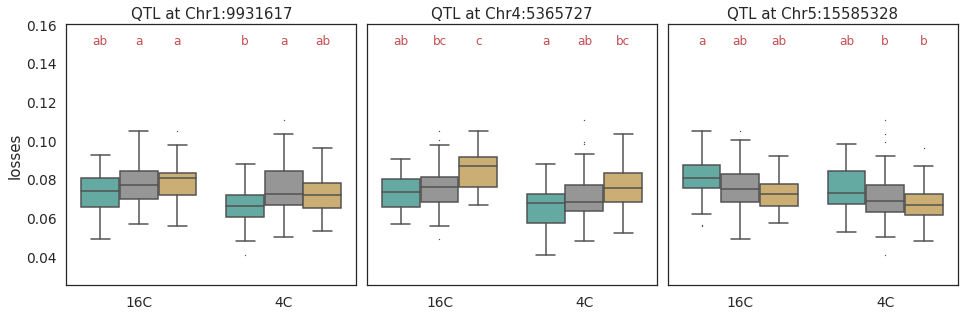

In [45]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside',
    "y_pos": 0.15
}
anno_args = dict(horizontalalignment='center', size='large', weight='normal', color='r')

fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (13.5, 4.5), sharey='row', sharex = False)

fig_args = dict(
    data = qtl_genotypes_data['pheno_d2'],
    hue = "qtl_loss_0",
    y = "deviation_1_nonpoly", #"deviation_1_nonpoly_qtl_loss_0", 
    x = "temp",
    palette=geno_color, 
    hue_order=['AA','AB','BB'],
    order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, ax = axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], anno_args = anno_args )
axs.set_ylim((0.025, 0.16))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("losses")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_loss[0] )


fig_args['hue'] = 'qtl_loss_1'
fig_args['y'] = "deviation_1_nonpoly"# 'deviation_1_nonpoly_qtl_loss_1'


axs = axes.flat[1]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'],anno_args = anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_loss[1] )

fig_args['hue'] = 'qtl_loss_2'
fig_args['y'] = "deviation_1_nonpoly"#'deviation_1_nonpoly_qtl_loss_2'
axs = axes.flat[2]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], anno_args = anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
# axs.set_xticks([0, 1, 2], ['NN', 'NS', 'SS'])
axs.set_xticks([0, 1], ['16C', '4C'])
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL at " + qtls_loss[2] )



# handles, labels = axes.flat[0].get_legend_handles_labels()
# # When creating the legend, only use the first two elements
# # to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes.flat[0].get_legend().remove()

plt.savefig("qtl_effects_losses.pdf")
fig.tight_layout()
plt.show()

In [69]:
print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T4','deviation_0_nonpoly_qtl_gain_0'], qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T4','qtl_gain_0'], groups_order=['AA','AB','BB']  ) )


print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T16','deviation_0_nonpoly_qtl_gain_0'], qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T16','qtl_gain_0'], groups_order=['AA','AB','BB']  ) )

print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[:,'deviation_0_nonpoly_qtl_gain_0'], qtl_genotypes_data['pheno'].loc[:,'qtl_gain_0'], groups_order=['AA','AB','BB']  ) )

    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0004  0.0014 -0.0007 -0.0001    True
1_3      1      3   -0.0002  0.3111 -0.0006  0.0002   False
2_3      2      3    0.0002  0.1580 -0.0001  0.0006   False
    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0004  0.0026 -0.0008 -0.0001    True
1_3      1      3   -0.0005  0.0044 -0.0009 -0.0000    True
2_3      2      3   -0.0000  0.9105 -0.0004  0.0003   False
    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0004  0.0000 -0.0006 -0.0002    True
1_3      1      3   -0.0003  0.0057 -0.0006 -0.0000    True
2_3      2      3    0.0001  0.3614 -0.0001  0.0003   False


In [53]:
-0.0004 / qtl_genotypes_data['pheno']['deviation_0_nonpoly_qtl_gain_0'].values.mean()

-0.5091952772534535

In [68]:
print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T4','deviation_0_nonpoly_qtl_gain_2'], qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T4','qtl_gain_2'], groups_order=['AA','AB','BB']  ) )

print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T16','deviation_0_nonpoly_qtl_gain_2'], qtl_genotypes_data['pheno'].loc[qtl_genotypes_data['pheno']['temp'] == 'T16','qtl_gain_2'], groups_order=['AA','AB','BB']  ) )


print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[:,'deviation_0_nonpoly_qtl_gain_2'], qtl_genotypes_data['pheno'].loc[:,'qtl_gain_2'], groups_order=['AA','AB','BB']  ) )

    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2    0.0003  0.1957 -0.0002  0.0007   False
1_3      1      3    0.0011  0.0000  0.0005  0.0017    True
2_3      2      3    0.0008  0.0001  0.0003  0.0014    True
    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2    0.0001  0.6510 -0.0003  0.0005   False
1_3      1      3   -0.0000  0.9889 -0.0005  0.0004   False
2_3      2      3   -0.0001  0.6438 -0.0006  0.0003   False
    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2    0.0002  0.1428 -0.0001  0.0005   False
1_3      1      3    0.0005  0.0003  0.0001  0.0009    True
2_3      2      3    0.0003  0.0207 -0.0000  0.0007   False


In [71]:
0.0011 / qtl_genotypes_data['pheno'].loc[:,'deviation_0_nonpoly_qtl_gain_2'].mean()

1.0385680719536123

In [75]:
print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[:,'deviation_1_nonpoly_qtl_loss_2'], qtl_genotypes_data['pheno'].loc[:,'qtl_loss_2'], groups_order=['AA','AB','BB']  ) )

    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2   -0.0047  0.0045 -0.0091 -0.0004    True
1_3      1      3   -0.0115  0.0000 -0.0172 -0.0058    True
2_3      2      3   -0.0068  0.0006 -0.0120 -0.0015    True


In [76]:
-0.0115 / qtl_genotypes_data['pheno'].loc[:,'deviation_1_nonpoly_qtl_loss_2'].mean()

-0.15855274946186035

In [77]:
print( pyquant.stats.perform_tukey_hsd(qtl_genotypes_data['pheno'].loc[:,'deviation_1_nonpoly_qtl_loss_1'], qtl_genotypes_data['pheno'].loc[:,'qtl_loss_1'], groups_order=['AA','AB','BB']  ) )

    group1 group2  meandiff   p-adj   lower   upper  reject
1_2      1      2    0.0055  0.0019  0.0008  0.0101    True
1_3      1      3    0.0119  0.0000  0.0063  0.0175    True
2_3      2      3    0.0064  0.0004  0.0015  0.0113    True


In [78]:
0.0119 / qtl_genotypes_data['pheno'].loc[:,'deviation_1_nonpoly_qtl_loss_1'].mean()

0.1640190469362213

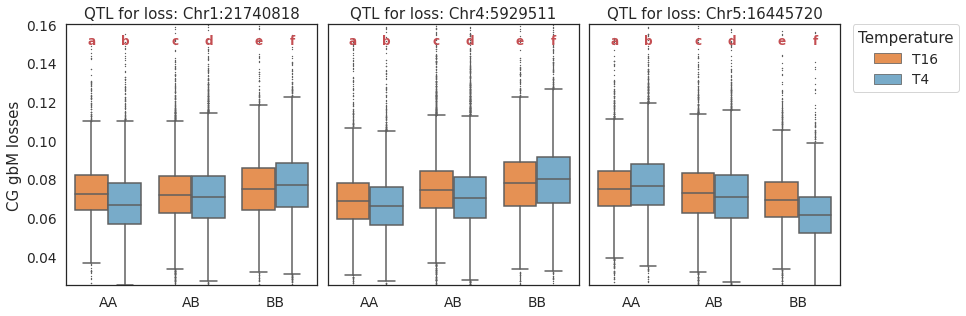

In [181]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside',
    "y_pos": 0.15
}
anno_args = dict(horizontalalignment='center', size='large', weight='semibold', color='r')


fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (13.5, 4.5), sharey='row', sharex = False)

fig_args = dict(
    data = qtl_genotypes_data['dev_1'][qtl_genotypes_data['dev_1']['qtl_ix'] == 'qtl_loss_0'].dropna(),
    x = "genotype",
    y = "deviation_1_nonpoly", 
    hue = "temp",
    palette=temp_color, 
    order=['AA','AB','BB'],
    hue_order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, ax = axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], **anno_args )
axs.set_ylim((0.025, 0.16))
axs.set_xlabel("")
axs.set_ylabel("CG gbM losses")
# axs.get_legend().remove()
axs.set_title( "QTL for loss: " + qtls_loss[0] )


fig_args['data'] = qtl_genotypes_data['dev_1'][qtl_genotypes_data['dev_1']['qtl_ix'] == 'qtl_loss_1'].dropna()

axs = axes.flat[1]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], **anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL for loss: " + qtls_loss[1] )

fig_args['data'] = qtl_genotypes_data['dev_1'][qtl_genotypes_data['dev_1']['qtl_ix'] == 'qtl_loss_2'].dropna()
axs = axes.flat[2]
sns.boxplot(**fig_args, ax=axs )
Annotator.add_tukeyletter(fig_args=fig_args, axs=axs, text_y_pos = configuration['y_pos'], **anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL for loss: " + qtls_loss[2] )



handles, labels = axes.flat[0].get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.flat[0].get_legend().remove()


fig.tight_layout()
plt.show()

### Effect plots for polymorphic sites

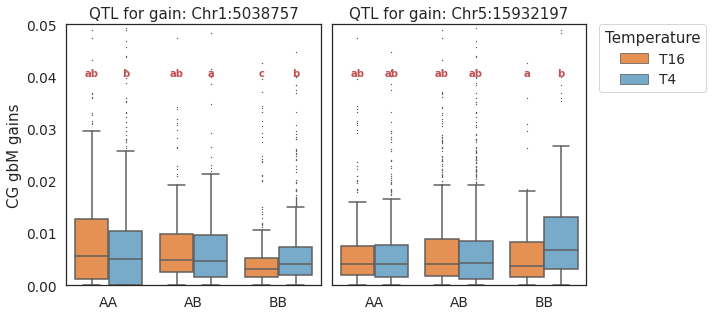

In [21]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside'
}
anno_args = dict(horizontalalignment='center', size='medium', weight='semibold', color='r')


fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 4.5), sharey='row', sharex = False)

fig_args = dict(
    data = qtl_genotypes_data['dev_0_poly'],
    y = "deviation_0", 
    hue = "temp",
    palette=temp_color, 
    order=['AA','AB','BB'],
    hue_order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, x = "qtl_gain_0", ax = axs  )
axs.set_xlabel("")
axs.set_ylabel("CG gbM gains")
axs.set_title( "QTL for gain: " + qtls_gain[0] )
Annotator.add_tukeyletter({**fig_args, **{"x": "qtl_gain_0"}}, axs, text_y_pos = 0.04, **anno_args)

# annotator = Annotator.Annotator(**fig_args, x = "qtl_gain_0", ax = axs, pairs = [ (('AA', 'T16'), ('AA', 'T4')), (('BB', 'T16'), ('BB', 'T4')) ], plot='violinplot')
# annotator.configure(**configuration).apply_and_annotate()


# axs = axes.flat[1]
# sns.boxplot(**fig_args, x = "qtl_gain_1", ax=axs )
# Annotator.add_tukeyletter({**fig_args, **{"x": "qtl_gain_1"}}, axs, text_y_pos = 0.009, **anno_args )

# axs.set_ylim((0, 0.01))
# axs.set_xlabel("")
# axs.set_ylabel("")
# axs.get_legend().remove()
# axs.set_title( "QTL for gain: " + qtls_gain[1] )

axs = axes.flat[1]
sns.boxplot(**fig_args, x = "qtl_gain_2", ax=axs )
Annotator.add_tukeyletter({**fig_args, **{"x": "qtl_gain_2"}}, axs, text_y_pos = 0.04, **anno_args )
axs.set_ylim((0, 0.05))
axs.set_xlabel("")
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL for gain: " + qtls_gain[2] )



handles, labels = axes.flat[0].get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.flat[0].get_legend().remove()


fig.tight_layout()
plt.show()

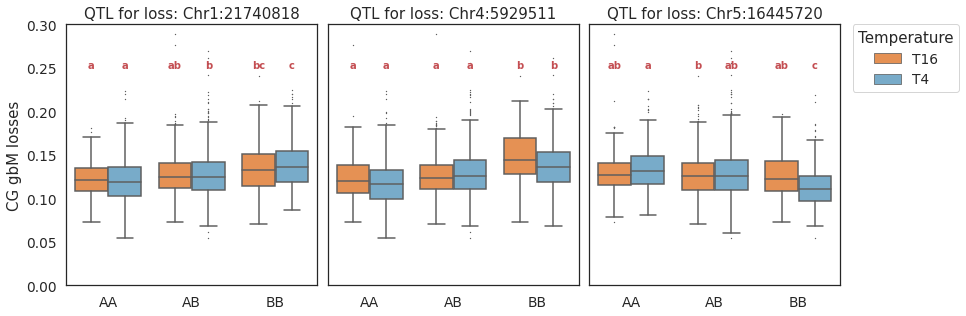

In [20]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":1,
    "loc":'inside'
}
anno_args = dict(horizontalalignment='center', size='medium', weight='semibold', color='r')


fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (13.5, 4.5), sharey='row', sharex = False)


fig_args = dict(
    data = qtl_genotypes_data['dev_1_poly'],
    y = "deviation_1", 
    hue = "temp",
    palette=temp_color, 
    order=['AA','AB','BB'], 
    hue_order = ['T16', 'T4'],
    fliersize = 0.5,
)

axs = axes.flat[0]
sns.boxplot(**fig_args, x = "qtl_loss_0", ax = axs )
Annotator.add_tukeyletter({**fig_args, **{"x": "qtl_loss_0"}}, axs, text_y_pos = 0.25, **anno_args )
axs.set_ylim((0, 0.3))
axs.set_xlabel("")
axs.set_ylabel("CG gbM losses")
# axs.get_legend().remove()
axs.set_title( "QTL for loss: " + qtls_loss[0] )

axs = axes.flat[1]
sns.boxplot(**fig_args, x = "qtl_loss_1", ax=axs )
Annotator.add_tukeyletter({**fig_args, **{"x": "qtl_loss_1"}}, axs, text_y_pos = 0.25, **anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL for loss: " + qtls_loss[1] )

axs = axes.flat[2]
sns.boxplot(**fig_args, x = "qtl_loss_2", ax=axs )
Annotator.add_tukeyletter({**fig_args, **{"x": "qtl_loss_2"}}, axs, text_y_pos = 0.25, **anno_args )
# axs.set_ylim((0, 0.01))
axs.set_xlabel("")
axs.set_ylabel("")
axs.get_legend().remove()
axs.set_title( "QTL for loss: " + qtls_loss[2] )



handles, labels = axes.flat[0].get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],title="Temperature", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.flat[0].get_legend().remove()


fig.tight_layout()
plt.show()

## Epimutation rates vs GC content

In [20]:
%%time


combined_mcs_f2s['gc_vs_deviation'] = pd.DataFrame(index = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0")].columns.str.replace("deviation_0:", "") )
combined_mcs_f2s['gc_vs_deviation']['gc_content'] = pd.Series(combined_mcs_f2s['gc_vs_deviation'].index).apply( tair10.getGC ).values

ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0")].copy()
ef_data.columns = pd.Series(ef_data.columns.str.replace("deviation_0:", ""))
ef_data = ef_data.loc[:,combined_mcs_f2s['gc_vs_deviation'].index]
combined_mcs_f2s['gc_vs_deviation']['deviation_0'] = ef_data.mean(0)


ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1")].copy()
ef_data.columns = pd.Series(ef_data.columns.str.replace("deviation_1:", ""))
ef_data = ef_data.loc[:,combined_mcs_f2s['gc_vs_deviation'].index]
combined_mcs_f2s['gc_vs_deviation']['deviation_1'] = ef_data.mean(0)

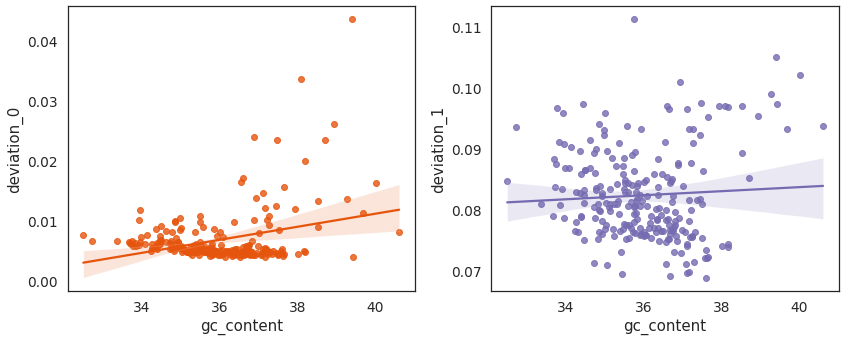

In [46]:
fig, axes = plt.subplots(ncols=2, figsize = (12, 5))

sns.regplot(data = combined_mcs_f2s['gc_vs_deviation'], x = "gc_content", y = "deviation_0", color=cb.sequential.Oranges_5.hex_colors[3], ax = axes.flat[0] )


sns.regplot(data = combined_mcs_f2s['gc_vs_deviation'], x = "gc_content", y = "deviation_1", color=cb.sequential.Purples_5.hex_colors[3], ax = axes.flat[1] )


plt.tight_layout()

## Epimutation signatures

In [7]:
%%time

req_mc_data = {}
req_mc_data['bed_str'] = "Chr1,1,2000000"
req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)

req_mc_data['mc_bed'] = pd.merge(combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['mc_data'].mc_meths.index.values), req_mc_data['mc_data'].mc_meths, left_index=True, right_index=True )
req_mc_data['mc_bed']['mc_class'] = combined_mcs_f2s['meths'].__getattr__("mc_class", req_mc_data['mc_data'].mc_meths.index.values )

req_mc_data['devs'] = req_mc_data['mc_data'].deviations.reset_index() 


for ef_mc_class in req_mc_data['mc_bed'].groupby('mc_class'):
    req_mc_data['mc_data']._calculate_deviations_subpop( 'AA', {"gain": ef_mc_class[1][ef_mc_class[1]['inherit_0_nonpoly_AA'].astype(bool)].index.values, "loss": ef_mc_class[1][ef_mc_class[1]['inherit_1_nonpoly_AA'].astype(bool)].index.values }, merge_deviations=req_mc_data['devs'], key= "_" + ef_mc_class[0] )
    req_mc_data['mc_data']._calculate_deviations_subpop( 'BB', {"gain": ef_mc_class[1][ef_mc_class[1]['inherit_0_nonpoly_BB'].astype(bool)].index.values, "loss": ef_mc_class[1][ef_mc_class[1]['inherit_1_nonpoly_BB'].astype(bool)].index.values }, merge_deviations=req_mc_data['devs'], key= "_" + ef_mc_class[0] )
    
req_mc_data['devs'] = pd.merge(combined_mcs_f2s['samples'], req_mc_data['devs'].set_index("index"), left_index=True, right_index=True)

CPU times: user 16.6 s, sys: 10.4 s, total: 27 s
Wall time: 27.2 s


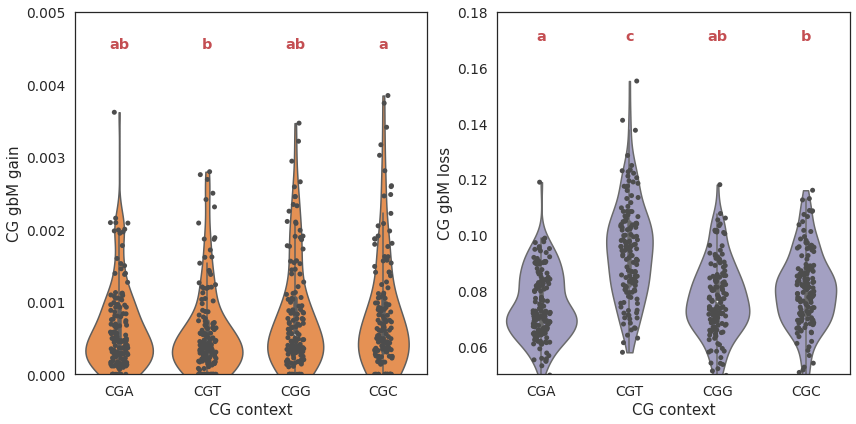

In [24]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}
anno_args = dict(horizontalalignment='center', size='x-large', weight='semibold', color='r')

fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))

# ef_data = req_mc_data['devs'][(req_mc_data['devs']['temp'] == 'T16') & (req_mc_data['devs']['subpop'] == 'AA')].copy()
# ef_data = req_mc_data['devs'][(req_mc_data['devs']['temp'] == 'T16')].copy()
ef_data = req_mc_data['devs'].copy()
ef_data = pd.melt(ef_data.loc[:,pd.Series(ef_data.columns).str.startswith("deviation_0_CG").values]).dropna()
ef_data['variable'] = ef_data['variable'].str.replace("deviation_0_", "")


fig_args = {
    "data": ef_data, 
    "y": "value",
    "x": "variable",
    "order": ['CGA', 'CGT', 'CGG', 'CGC'],
    "ax": axs.flat[0]
}
sns.violinplot(**fig_args, cut = 0, color=cb.sequential.Oranges_5.hex_colors[2],fliersize=0)
sns.stripplot(**fig_args, dodge=True, palette=[".3"] * 4, jitter=True)
fig_args['ax'].set_ylim( (0, 0.005) )
Annotator.add_tukeyletter(fig_args, fig_args['ax'], text_y_pos=0.0045, **anno_args)
fig_args['ax'].set_ylabel( "CG gbM gain" )
fig_args['ax'].set_xlabel( "CG context" )



# ef_data = req_mc_data['devs'][(req_mc_data['devs']['temp'] == 'T16') & (req_mc_data['devs']['subpop'] == 'AA')].copy()
# ef_data = req_mc_data['devs'][(req_mc_data['devs']['temp'] == 'T16')].copy()
ef_data = req_mc_data['devs'].copy()
ef_data = pd.melt(ef_data.loc[:,pd.Series(ef_data.columns).str.startswith("deviation_1_CG").values]).dropna()
ef_data['variable'] = ef_data['variable'].str.replace("deviation_1_", "")


fig_args = {
    "data": ef_data, 
    "y": "value",
    "x": "variable",
    "order": ['CGA', 'CGT', 'CGG', 'CGC'],
    'ax':axs.flat[1]
}
sns.violinplot(**fig_args, cut = 0, color=cb.sequential.Purples_5.hex_colors[2], fliersize=0)
sns.stripplot(**fig_args, dodge=True, palette=[".3"] * 4, jitter=True  )
fig_args['ax'].set_ylim( (0.05, 0.18) )
Annotator.add_tukeyletter(fig_args, fig_args['ax'], text_y_pos=0.17, **anno_args)
fig_args['ax'].set_ylabel( "CG gbM loss" )
fig_args['ax'].set_xlabel( "CG context" )



fig.tight_layout()
plt.show()



In [18]:
ef_data.groupby("variable").describe()

value                                                              \
          count      mean       std       min       25%       50%       75%   
variable                                                                      
CGA       141.0  0.075065  0.012085  0.049727  0.066083  0.072217  0.083937   
CGC       141.0  0.080669  0.013645  0.049283  0.071293  0.080402  0.088195   
CGG       141.0  0.077280  0.013472  0.044341  0.068682  0.076297  0.085149   
CGT       141.0  0.094583  0.017406  0.057897  0.081891  0.095027  0.104765   

                    
               max  
variable            
CGA       0.118917  
CGC       0.116022  
CGG       0.118027  
CGT       0.155203

In [19]:
(0.094583 - 0.077) / 0.077

0.22835064935064936

## Do C's nearby a methylated C' change more often?

Elizabeth and Zilberman et al. suggest there is higher epimutation rates around methylated sites. I want to test this from my data.

Data suggests:
There is higher epimutation rate on the cytosines that show differences between North and South. 

Two possible hypothesis.

1. Sites which are different between North and Southern lines have high propensity to change.
1. Since, they pass through F1, there is epimutation in F1

In [8]:
%%time

req_mc_data = {}

req_mc_data['bed_str'] = "Chr1,1,4000000"

req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)

req_mc_data['mc_bed'] = pd.merge(combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['mc_data'].mc_meths.index.values), req_mc_data['mc_data'].mc_meths, left_index=True, right_index=True )

CPU times: user 19 s, sys: 5.68 s, total: 24.7 s
Wall time: 29.1 s


In [61]:
%%time

ef_gains = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_0_AA'].astype(bool)]
ef_methylated = req_mc_data['mc_bed'].loc[(req_mc_data['mc_bed']['AA'] > 0.9),"start"]
# ef_methylated = req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_1_AA'].astype(bool),"start"]


req_mc_data['pivot_gains'] = bshap.stats.pivot_bed_to_req_positions(ef_gains.loc[:,['start','AA']], ef_methylated )
req_mc_data['pivot_gains'] = req_mc_data['pivot_gains'].loc[:,['min_dist','AA']].groupby('min_dist').describe(percentiles = [0.05,0.95])

CPU times: user 34.6 s, sys: 9.64 s, total: 44.2 s
Wall time: 44.2 s


In [62]:
%%time

ef_losses = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_AA'].astype(bool)]
ef_methylated = req_mc_data['mc_bed'].loc[(req_mc_data['mc_bed']['AA'] > 0.9),"start"]
# req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_1_AA'].astype(bool),"start"]


req_mc_data['pivot_losses'] = bshap.stats.pivot_bed_to_req_positions(ef_losses.loc[:,['start','AA']], ef_methylated)
req_mc_data['pivot_losses'] = req_mc_data['pivot_losses'].loc[:,['min_dist','AA']].groupby('min_dist').describe(percentiles = [0.05,0.95])

CPU times: user 5.58 s, sys: 2.09 s, total: 7.67 s
Wall time: 7.65 s


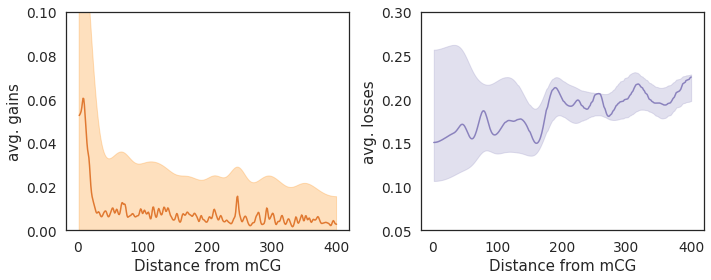

In [104]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4), sharex = False)

fig_args = dict(
    alpha = 0.8,
    ns_gains = 5,
    ns_losses = 80,
    lims = 400,
    n_smooth_patch = 300
)


sns.lineplot(x = req_mc_data['pivot_gains'].loc[2:fig_args['lims'],].index, y = pyquant.utils.smooth_sum(req_mc_data['pivot_gains'].loc[2:fig_args['lims'],('AA','mean')], fig_args['ns_gains']), color = cb.sequential.YlOrBr_6.hex_colors[4], ax = axs.flat[0], alpha  = fig_args['alpha'])

axs.flat[0].axes.fill_between(req_mc_data['pivot_gains'].loc[2:fig_args['lims'],].index, 0, pyquant.utils.smooth_sum(req_mc_data['pivot_gains'].loc[2:fig_args['lims'],('AA','95%')], fig_args['n_smooth_patch'] ), interpolate=True, color = cb.sequential.YlOrBr_6.hex_colors[3], alpha = 0.3, rasterized = True )
axs.flat[0].set_ylabel("avg. gains")
axs.flat[0].set_xlabel("Distance from mCG")
axs.flat[0].set_ylim(0, 0.1)



sns.lineplot(x = req_mc_data['pivot_losses'].loc[2:fig_args['lims'],].index, y = 1 - pyquant.utils.smooth_sum(req_mc_data['pivot_losses'].loc[2:fig_args['lims'],('AA','50%')], fig_args['ns_losses']), color = cb.sequential.Purples_6.hex_colors[4], ax = axs.flat[1], alpha  = fig_args['alpha'])

axs.flat[1].axes.fill_between(req_mc_data['pivot_losses'].loc[2:fig_args['lims'],].index, 1 - pyquant.utils.smooth_sum(req_mc_data['pivot_losses'].loc[2:fig_args['lims'],('AA','5%')], fig_args['n_smooth_patch'] ), 1 - pyquant.utils.smooth_sum(req_mc_data['pivot_losses'].loc[2:fig_args['lims'],('AA','95%')], fig_args['n_smooth_patch'] ), interpolate=True, color = cb.sequential.Purples_6.hex_colors[3], alpha = 0.3, rasterized = True )
axs.flat[1].set_ylabel("avg. losses")
axs.flat[1].set_xlabel("Distance from mCG")
axs.flat[1].set_ylim(0.05, 0.3)

fig.tight_layout()

plt.savefig("mcg_distance.pdf", bbox_inches='tight', dpi = 300)

plt.show()

In [20]:
%%time
ef_mc_permeths = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_0_nonpoly_AA'] == 1].loc[:,['start','AA']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_nonpoly_AA'] == 1].loc[:,['start','AA']].reset_index(drop = True)
req_mc_data['stat_pivot_mcg_AA'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )



ef_mc_permeths = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_0_nonpoly_BB'] == 1].loc[:,['start','BB']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_nonpoly_BB'] == 1].loc[:,['start','BB']].reset_index(drop = True)
req_mc_data['stat_pivot_mcg_BB'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 26.7 s, sys: 19.9 s, total: 46.7 s
Wall time: 46.6 s


In [10]:
%%time
ef_mc_permeths = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_nonpoly_AA'] == 1].loc[:,['start','AA']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_nonpoly_AA'] == 1].loc[:,['start','AA']].reset_index(drop = True)
req_mc_data['stat_pivot_mcg_loss_AA'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )



ef_mc_permeths = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_nonpoly_BB'] == 1].loc[:,['start','BB']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_bed'][req_mc_data['mc_bed']['inherit_1_nonpoly_BB'] == 1].loc[:,['start','BB']].reset_index(drop = True)
req_mc_data['stat_pivot_mcg_loss_BB'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 3.51 s, sys: 2.23 s, total: 5.73 s
Wall time: 5.74 s


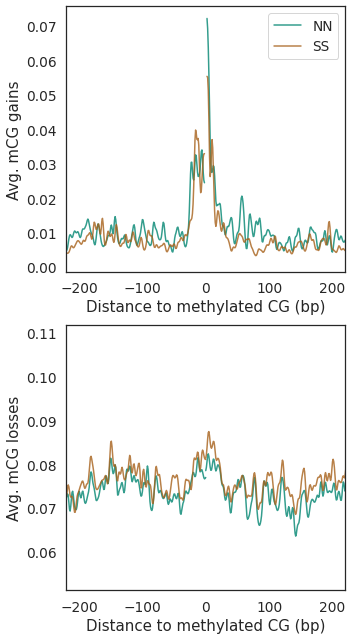

In [17]:
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (5,9), sharex = False)

fig_args = dict(
    alpha = 0.8,
    n_smooth = 5,
    col_AA = cb.diverging.BrBG_5.hex_colors[4],
    col_BB = cb.diverging.BrBG_5.hex_colors[0],
    lims = 220
)



sns.lineplot(x = req_mc_data['stat_pivot_mcg_AA'][0:].index, y = pyquant.utils.smooth_sum(req_mc_data['stat_pivot_mcg_AA'][0:]['pheno'], fig_args['n_smooth']), color = fig_args['col_AA'], ax = axs.flat[0], label="NN", alpha  = fig_args['alpha'])

sns.lineplot(x = req_mc_data['stat_pivot_mcg_AA'][:0].index, y = pyquant.utils.smooth_sum(req_mc_data['stat_pivot_mcg_AA'][:0]['pheno'], fig_args['n_smooth']), color = fig_args['col_AA'], ax = axs.flat[0], alpha  = fig_args['alpha'])

sns.lineplot(x = req_mc_data['stat_pivot_mcg_BB'][0:].index, y = pyquant.utils.smooth_sum(req_mc_data['stat_pivot_mcg_BB'][0:]['pheno'], fig_args['n_smooth']), color = fig_args['col_BB'], ax = axs.flat[0], label="SS", alpha  = fig_args['alpha'])

sns.lineplot(x = req_mc_data['stat_pivot_mcg_BB'][:0].index, y = pyquant.utils.smooth_sum(req_mc_data['stat_pivot_mcg_BB'][:0]['pheno'], fig_args['n_smooth']), color = fig_args['col_BB'], ax = axs.flat[0], alpha  = fig_args['alpha'])

axs.flat[0].set_xlabel("Distance to methylated CG (bp)")
axs.flat[0].set_ylabel("Avg. mCG gains")

axs.flat[0].set_xlim((-fig_args['lims'],fig_args['lims']))



sns.lineplot(x = req_mc_data['stat_pivot_mcg_loss_AA'][0:].index, y = pyquant.utils.smooth_sum(1 - req_mc_data['stat_pivot_mcg_loss_AA'][0:]['pheno'], fig_args['n_smooth']), color = fig_args['col_AA'], ax = axs.flat[1],  alpha  = fig_args['alpha'])

sns.lineplot(x = req_mc_data['stat_pivot_mcg_loss_AA'][:0].index, y = pyquant.utils.smooth_sum(1 - req_mc_data['stat_pivot_mcg_loss_AA'][:0]['pheno'], fig_args['n_smooth']), color = fig_args['col_AA'], ax = axs.flat[1], alpha  = fig_args['alpha'])

sns.lineplot(x = req_mc_data['stat_pivot_mcg_loss_BB'][0:].index, y = pyquant.utils.smooth_sum(1 - req_mc_data['stat_pivot_mcg_loss_BB'][0:]['pheno'], fig_args['n_smooth']), color = fig_args['col_BB'], ax = axs.flat[1], alpha  = fig_args['alpha'])

sns.lineplot(x = req_mc_data['stat_pivot_mcg_loss_BB'][:0].index, y = pyquant.utils.smooth_sum(1 - req_mc_data['stat_pivot_mcg_loss_BB'][:0]['pheno'], fig_args['n_smooth']), color = fig_args['col_BB'], ax = axs.flat[1], alpha  = fig_args['alpha'])


# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg'].index, y =  pyquant.qtl_maps.smooth_sum(req_mc_data['stat_pivot_mcg'][('P_6046',  'mean')], 3))

axs.flat[1].set_xlabel("Distance to methylated CG (bp)")
axs.flat[1].set_ylabel("Avg. mCG losses")

axs.flat[1].set_xlim((-fig_args['lims'],fig_args['lims']))


fig.tight_layout()


plt.savefig("epimutation_nearbyC.pdf", bbox_inches='tight')


plt.show()

## Autocorrelation for epimutations

In [39]:
%%time

req_mc_data = {}

req_mc_data['bed_str'] = "Chr1,1,2000000"

req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)

req_mc_data['mc_bed'] = combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['mc_data']['permeths_subpop'].index.values)

TypeError: 'CalculateEpimutations' object is not subscriptable

In [17]:
auto_corr = pd.DataFrame( index = np.arange(300), columns=['inherit_0', 'inherit_1']  )
for ef in auto_corr.index.values:
    auto_corr.loc[ef, "inherit_0"] = req_mc_data['mc_data']['permeths_subpop'].loc[req_mc_data['mc_data']['permeths_subpop']['inherit_0_AA'].astype(bool), 'AA'].autocorr(lag=ef)
    auto_corr.loc[ef, "inherit_1"] = req_mc_data['mc_data']['permeths_subpop'].loc[req_mc_data['mc_data']['permeths_subpop']['inherit_1_AA'].astype(bool), 'AA'].autocorr(lag=ef)

In [22]:
pd.Series(req_mc_data['mc_bed']['start'][1:].values - req_mc_data['mc_bed']['start'][:-1].values).describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

count    67269.000000
mean        29.621638
std        154.766148
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%         18.000000
80%         25.000000
95%        121.000000
max       9457.000000
dtype: float64

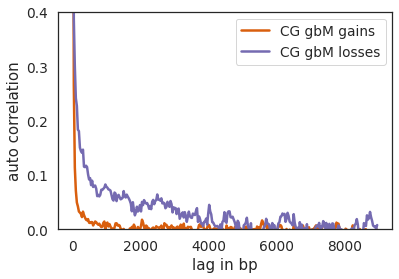

In [26]:
sns.lineplot(x = auto_corr.index.values * 30, y = auto_corr['inherit_0'].values, color = cb.sequential.YlOrBr_5.hex_colors[3], linewidth=2.5, label = "CG gbM gains" )
sns.lineplot(x = auto_corr.index.values * 30, y = auto_corr['inherit_1'].values, color = cb.sequential.Purples_5.hex_colors[3], linewidth=2.5, label = "CG gbM losses" )
plt.ylim((0, 0.4))
# plt.xlim( (-5, 3000 ) ) 
plt.xlabel("lag in bp")
plt.ylabel("auto correlation")
plt.legend()

## Scale of epimutations?

Can we get down to the level of genes?

In [2]:
req_mc_data = {}
req_mc_data['bed_str'] = "Chr1,1,200000"

In [146]:
%%time
req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)

req_mc_data['mc_bed'] = pd.merge(combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['mc_data'].mc_meths.index.values), req_mc_data['mc_data'].mc_meths, left_index=True, right_index=True )
req_mc_data['mc_bed']['genome_ix'] = tair10.get_genomewide_inds(req_mc_data['mc_bed'].loc[:,['chr','start','end']])


req_mc_data['devs'] = req_mc_data['mc_data'].deviations.reset_index()

for ef_bin in tair10.iter_positions_in_windows( req_mc_data['mc_bed'].iloc[:,[0,1,2]], window_size=1000 ):
    if len(ef_bin[2]) < 5:
        continue
    else:
        ef_bin_str = "bin_" + ef_bin[0] + ',' + str(ef_bin[1][0]) + ',' + str(ef_bin[1][1])
        ef_mc_data = req_mc_data['mc_data'].mc_meths.iloc[ef_bin[2],:]
        req_mc_data['mc_data']._calculate_deviations_subpop( 'AA', {"gain": ef_mc_data.index.values[ef_mc_data['inherit_0_nonpoly_AA'].astype(bool)], "loss": ef_mc_data.index.values[ef_mc_data['inherit_1_nonpoly_AA'].astype(bool)] }, merge_deviations=req_mc_data['devs'], key= "_" + ef_bin_str )
        req_mc_data['mc_data']._calculate_deviations_subpop( 'BB', {"gain": ef_mc_data.index.values[ef_mc_data['inherit_0_nonpoly_BB'].astype(bool)], "loss": ef_mc_data.index.values[ef_mc_data['inherit_1_nonpoly_BB'].astype(bool)] }, merge_deviations=req_mc_data['devs'], key= "_" + ef_bin_str )

req_mc_data['devs'] = pd.merge(combined_mcs_f2s['samples'], req_mc_data['devs'].set_index("index"), left_index=True, right_index=True)

CPU times: user 20 s, sys: 2.02 s, total: 22 s
Wall time: 22.1 s


In [215]:
%%time
req_mc_data['deviation_0'] = req_mc_data['devs'].reset_index().set_index(['index','subpop','temp']).copy()
# req_mc_data['deviation_0'] = req_mc_data['deviation_0'][(req_mc_data['deviation_0']['subpop'] == 'AA') & (req_mc_data['deviation_0']['subpop'] == "BB")].T
# req_mc_data['deviation_0'] = req_mc_data['deviation_0'][(req_mc_data['deviation_0']['geno'] == 'AA')].T
req_mc_data['deviation_0'] = req_mc_data['deviation_0'].loc[:,req_mc_data['deviation_0'].columns.str.startswith("deviation_0_bin_") ].astype(float).dropna(how = "all")
req_mc_data['deviation_0'].columns = req_mc_data['deviation_0'].columns.str.replace("deviation_0_bin_", "")

req_mc_data['deviation_1'] = req_mc_data['devs'].reset_index().set_index(['index','subpop','temp']).copy()
# req_mc_data['deviation_0'] = req_mc_data['deviation_0'][(req_mc_data['deviation_0']['subpop'] == 'AA') & (req_mc_data['deviation_0']['subpop'] == "BB")].T
# req_mc_data['deviation_0'] = req_mc_data['deviation_0'][(req_mc_data['deviation_0']['geno'] == 'AA')].T
req_mc_data['deviation_1'] = req_mc_data['deviation_1'].loc[:,req_mc_data['deviation_1'].columns.str.startswith("deviation_1_bin_") ].astype(float).dropna(how = "all")
req_mc_data['deviation_1'].columns = req_mc_data['deviation_1'].columns.str.replace("deviation_1_bin_", "")




req_mc_data['avg_devs'] = pd.DataFrame(columns=['genome_ix'], index = np.unique(np.append(req_mc_data['deviation_0'].columns, req_mc_data['deviation_1'].columns)))
req_mc_data['avg_devs']['genome_ix'] = tair10.get_genomewide_inds( pd.Series(req_mc_data['avg_devs'].index.values) )
req_mc_data['avg_devs'] = req_mc_data['avg_devs'].sort_values("genome_ix")
req_mc_data['avg_devs']['dev_0_AA'] = req_mc_data['deviation_0'].loc[(slice(None),'AA',slice(None)),:].mean(0)
req_mc_data['avg_devs']['dev_0_BB'] = req_mc_data['deviation_0'].loc[(slice(None),'BB',slice(None)),:].mean(0)
req_mc_data['avg_devs']['dev_1_AA'] = req_mc_data['deviation_1'].loc[(slice(None),'AA',slice(None)),:].mean(0)
req_mc_data['avg_devs']['dev_1_BB'] = req_mc_data['deviation_1'].loc[(slice(None),'BB',slice(None)),:].mean(0)

CPU times: user 43 ms, sys: 4.02 ms, total: 47 ms
Wall time: 45.3 ms


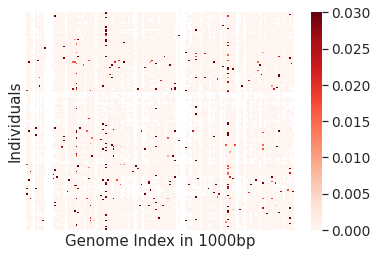

In [115]:
p = sns.heatmap( req_mc_data['deviation_0'], cmap = "Reds", vmin=0, vmax=0.03, yticklabels=False, xticklabels=False )
p.set_xlabel("Genome Index in 1000bp")
p.set_ylabel("Individuals")

plt.show()

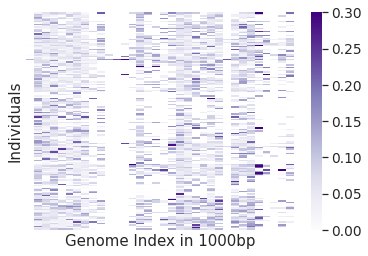

In [126]:
p = sns.heatmap( req_mc_data['deviation_1'].T.dropna(how= "all").T, cmap = "Purples", vmin=0, vmax=0.3,yticklabels=False, xticklabels=False  )
p.set_xlabel("Genome Index in 1000bp")
p.set_ylabel("Individuals")

plt.show()

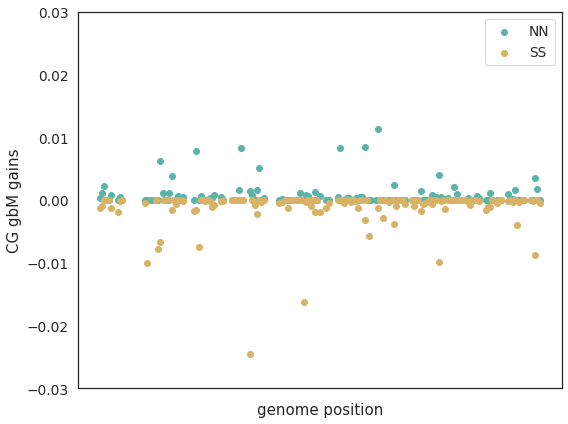

In [223]:
fig, axs = plt.subplots(figsize = (8,6))

# axs.scatter(req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_0_nonpoly_AA'].astype(bool),"genome_ix"].values, pyquant.utils.smooth_sum(req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_0_nonpoly_AA'].astype(bool),"AA"].values, 10  ),  color = geno_color['AA'], label= 'NN' )
axs.scatter(data = req_mc_data['avg_devs'], x = "genome_ix", y = "dev_0_AA",  color = geno_color['AA'], label= 'NN' )



# axs.scatter(req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_0_nonpoly_BB'].astype(bool),"genome_ix"].values, -pyquant.utils.smooth_sum(req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_0_nonpoly_BB'].astype(bool),"BB"].values, 10 ),  color = geno_color['BB'], label = 'SS' )
axs.scatter(x = req_mc_data['avg_devs']["genome_ix"], y = -req_mc_data['avg_devs']["dev_0_BB"],  color = geno_color['BB'], label= 'SS' )

plt.legend()
axs.set_xticklabels("")
axs.set_xlabel("genome position")
axs.set_ylabel("CG gbM gains")
axs.set_ylim((-0.03, 0.03))

fig.tight_layout()

plt.show()

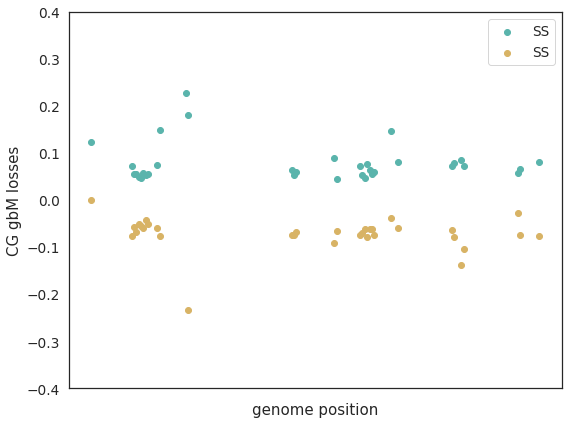

In [226]:
fig, axs = plt.subplots(figsize = (8,6))

# axs.scatter(req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_1_nonpoly_AA'].astype(bool),"genome_ix"].values, pyquant.utils.smooth_sum(1 -req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_1_nonpoly_AA'].astype(bool),"AA"].values, 10  ),  color = geno_color['AA'], label= 'NN' )
axs.scatter(x = req_mc_data['avg_devs']["genome_ix"], y = req_mc_data['avg_devs']["dev_1_AA"],  color = geno_color['AA'], label= 'SS' )

# axs.scatter(req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_1_nonpoly_BB'].astype(bool),"genome_ix"].values, -pyquant.utils.smooth_sum(1 -req_mc_data['mc_bed'].loc[req_mc_data['mc_bed']['inherit_1_nonpoly_BB'].astype(bool),"BB"].values, 10 ),  color = geno_color['BB'], label = 'SS' )
axs.scatter(x = req_mc_data['avg_devs']["genome_ix"], y = -req_mc_data['avg_devs']["dev_1_BB"],  color = geno_color['BB'], label= 'SS' )

plt.legend()
axs.set_xticklabels("")
axs.set_xlabel("genome position")
axs.set_ylabel("CG gbM losses")
axs.set_ylim((-0.4, 0.4))

fig.tight_layout()

plt.show()

In [234]:
%%time

pd.merge(pd.Series(req_mc_data['avg_devs'].index).str.split(",", expand = True), req_mc_data['avg_devs'].loc[:,['dev_0_AA']].reset_index(drop = True), left_index=True, right_index=True).to_csv("cache_data/deviations_0_AA_mean.bed", sep = "\t", header=None, index=None)
pd.merge(pd.Series(req_mc_data['avg_devs'].index).str.split(",", expand = True), req_mc_data['avg_devs'].loc[:,['dev_0_BB']].reset_index(drop = True), left_index=True, right_index=True).to_csv("cache_data/deviations_0_BB_mean.bed", sep = "\t", header=None, index=None)

pd.merge(pd.Series(req_mc_data['avg_devs'].index).str.split(",", expand = True), req_mc_data['avg_devs'].loc[:,['dev_1_AA']].reset_index(drop = True), left_index=True, right_index=True).to_csv("cache_data/deviations_1_AA_mean.bed", sep = "\t", header=None, index=None)
pd.merge(pd.Series(req_mc_data['avg_devs'].index).str.split(",", expand = True), req_mc_data['avg_devs'].loc[:,['dev_1_AA']].reset_index(drop = True), left_index=True, right_index=True).to_csv("cache_data/deviations_1_BB_mean.bed", sep = "\t", header=None, index=None)

CPU times: user 12.9 ms, sys: 4.12 ms, total: 17 ms
Wall time: 39.9 ms


In [235]:
%%time

# ##### Calculate methylation averages for parents
# req_mc_data['parent_idx_dict'] = {ef: combined_mcs_all['samples'].reset_index().groupby('dir_temp').groups[ef] for ef in ['6046_T16', '6046_T4', '6191_T16', '6191_T4']}
# req_mc_data['parent_idx_dict'].update( {ef: combined_mcs_all['samples'].reset_index().groupby('geno_dir').groups[ef] for ef in ['P_6046', 'P_6191']} )

# for ef_dict in req_mc_data['parent_idx_dict'].keys():
#     req_mc_data['mcg_data'].loc[:,ef_dict] = bshap.combinemeths.np_get_fraction(req_mc_data['mc_count'][:,req_mc_data['parent_idx_dict'][ef_dict]].sum(1), req_mc_data['mc_total'][:,req_mc_data['parent_idx_dict'][ef_dict]].sum(1), y_min = 10 )



# req_mc_data['mcg_data'].loc[:,['chr','start','end','P_6046']].to_csv("cache_data/deviations_mcs_P_6046.bed", sep = "\t", header=None, index=None)

# req_mc_data['mcg_data'].loc[:,['chr','start','end','P_6191']].to_csv("cache_data/deviations_mcs_P_6191.bed", sep = "\t", header=None, index=None)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16.2 µs


In [3]:
import igv
# import palettable.colorbrewer as cb
# geno_color = {'AA': cb.diverging.BrBG_6.hex_colors[4], 'BB': cb.diverging.BrBG_6.hex_colors[1], 'AB': cb.sequential.Greys_5.hex_colors[2]}

b = igv.Browser({"reference": "tair10"})
# b = igv.Browser(
#     {"reference": {
#         "id": "tair10",
#         "fastaURL": "araport_annotations/TAIR10_wholeGenome.fasta",
#         "indexed": False,
#         # "cytobandURL": "araport_annotations/cytoband.txt",
#         "tracks": [
#             {
#                 "name": "PC genes",
#                 "url": "araport_annotations/Araport11_GFF3_201606.protein_coding_genes.bed",
#                 "color": "#2166ac"
#             },
#             {
#                 "name": "TEs",
#                 "url": "araport_annotations/Araport11_GFF3_201606.transposable_elements.bed",
#                 "color": "#ef8a62"
#             }
#         ]
#     }}
# )

b.show()

In [2]:
b.show()

In [5]:
b.search(req_mc_data['bed_str'].split(",")[0] + ":" + req_mc_data['bed_str'].split(",")[1] + "-" + req_mc_data['bed_str'].split(",")[2])


# b.load_track({
#     "name": "mCG in P_6046",
#     "url": "cache_data/deviations_mcs_P_6046.bed",
#     "format": "bedGraph",
#     "indexed": False,
#     "color": "#8c510a",
#     # "min": 0,
#     # "max": 1
# })


# b.load_track({
#     "name": "mCG in P_6191",
#     "url": "cache_data/deviations_mcs_P_6191.bed",
#     "format": "bedGraph",
#     "indexed": False,
#     "color": "#01665e",
#     "min": 0,
#     "max": 1
# })



b.load_track({
    "name": "Avg. CG gains",
    "url": "cache_data/deviations_0_AA_mean.bed",
    "format": "bedGraph",
    "indexed": False,
    "color": geno_color['AA'],
    "min": 0,
    "max": 0.03
})

# b.load_track({
#     "name": "CG gains std.",
#     "url": "cache_data/deviations_0_check_std.bed",
#     "format": "bedGraph",
#     "indexed": False,
#     "color": "#cc4c02",
#     "min": 0,
#     "max": 0.03
# })

# b.load_track({
#     "name": "Avg. CG losses",
#     "url": "cache_data/deviations_1_check_mean.bed",
#     "format": "bedGraph",
#     "indexed": False,
#     "color": "#9e9ac8",
#     # "min": 0,
#     # "max": 0.1
# })

# b.load_track({
#     "name": "CG losses std.",
#     "url": "cache_data/deviations_1_check_std.bed",
#     "format": "bedGraph",
#     "indexed": False,
#     "color": "#9e9ac8",
#     # "min": 0,
#     # "max": 0.1
# })


## Do epimutations arise in differences of N/S?

In [9]:
def permutation_overlap(set_1, set_2, superset, n_iter = 10000):
    n_set_1 = set_1.shape[0]
    n_set_2 = set_2.shape[0]
    
    n_overlap = np.isin( set_1, set_2 ).sum() #/ float(n_sub)
#     perm_overlap = np.zeros(0, dtype = int)
#     for ef_iter in np.arange(n_iter):
#         perm_overlap = np.append( perm_overlap, np.isin(np.sort(np.random.choice(superset, n_set_2,replace=False)), set_1, assume_unique=True).sum() )
        
    rand_sup = superset[ np.random.randint(0, superset.shape[0], (n_set_2, n_iter)) ]
#     perm_overlap = pd.DataFrame(rand_sup).apply( lambda x: np.isin(np.sort(x.values), set_1, assume_unique = True), axis=0  ).sum(0)
    perm_overlap = np.isin(rand_sup, set_1).sum(0)
    return((n_overlap / float(n_set_1), perm_overlap / float(n_set_1)))

In [10]:
%%time

req_mc_data = {}
req_mc_data['bed_str'] = "Chr1,1,10000000"
req_mc_data['dev'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020")

# # req_mc_data['mc_data_d2'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths_d2'], cross_data, "d2_2020", return_all = True)
# pd.concat([, req_mc_data['mc_data_d2']['deviations']])



# req_mc_data['geno_groups'] = cross_data.get_genotype_dict_at_bed_str("d1_2020", req_mc_data['bed_str'])[1].reindex( combined_mcs_f2s['meths'].file_ids ).reset_index().groupby("geno").groups
# req_mc_data['mcg_gbm_ix'] = combined_mcs_f2s['meths'].get_req_pos_bed_str(req_mc_data['bed_str'], req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )

# req_mc_data['cg_count'] = combined_mcs_f2s['meths'].__getattr__("mc_count", req_mc_data['mcg_gbm_ix'])
# req_mc_data['cg_total'] = combined_mcs_f2s['meths'].__getattr__("mc_total", req_mc_data['mcg_gbm_ix'])

# req_mc_data.update( bshap.combinemeths.calculate_deviations_per_populations(req_mc_data['cg_count'], req_mc_data['cg_total'], req_mc_data['geno_groups'] ) )


# req_mc_data['permeths_subpop']['DMC'] = 0
# # req_mc_data['permeths_subpop'].loc[(req_mc_data['permeths_subpop']['inherit_0_AA'].astype(bool) & req_mc_data['permeths_subpop']['inherit_1_BB'].astype(bool)), 'DMC'] = 1
# req_mc_data['permeths_subpop'].loc[(req_mc_data['permeths_subpop']['inherit_1_AA'].astype(bool) & req_mc_data['permeths_subpop']['inherit_0_BB'].astype(bool)), 'DMC'] = 1


# ef_dmc_bed = combined_mcs_f2s['meths'].get_bed_pos_ix( req_mc_data['mcg_gbm_ix'][req_mc_data['permeths_subpop']['DMC'].astype(bool)], updown = 30)
# req_mc_data['permeths_subpop']['close_to_dmc'] = 0
# req_mc_data['permeths_subpop'].loc[bshap.run_bedtools.get_positions_overlap_bed(reference_bed=ef_dmc_bed, query_positions = combined_mcs_f2s['meths'].__getattr__('start', req_mc_data['mcg_gbm_ix']) ), 'close_to_dmc'] = 1



# ### Calculating deviations
# req_mc_data['deviations'] = pd.merge(req_mc_data['deviations'], bshap.combinemeths.calculate_deviations_per_populations(req_mc_data['cg_count'][req_mc_data['permeths_subpop']['close_to_dmc'].astype('bool'),:], req_mc_data['cg_total'][req_mc_data['permeths_subpop']['close_to_dmc'].astype('bool'),:], req_mc_data['geno_groups'] )['deviations'], left_index=True, right_index=True, suffixes=('', '_dmc')  )

# req_mc_data['deviations'] = pd.merge(req_mc_data['deviations'], bshap.combinemeths.calculate_deviations_per_populations( req_mc_data['cg_count'][~req_mc_data['permeths_subpop']['close_to_dmc'].astype('bool'),:], req_mc_data['cg_total'][~req_mc_data['permeths_subpop']['close_to_dmc'].astype('bool'),:], req_mc_data['geno_groups'] )['deviations'], left_index=True, right_index=True, suffixes=('', '_nodmc')  )


# req_mc_data['deviations'].index = combined_mcs_f2s['meths'].file_ids[ req_mc_data['deviations'].index.values ].values
# req_mc_data['deviations'] = pd.merge(combined_mcs_f2s['samples'], req_mc_data['deviations'], right_index=True, left_index=True)
# req_mc_data['deviations']['subpop_temp'] = req_mc_data['deviations']['subpop'] + "_" + req_mc_data['deviations']['temp']

CPU times: user 53.2 s, sys: 35.2 s, total: 1min 28s
Wall time: 1min 39s


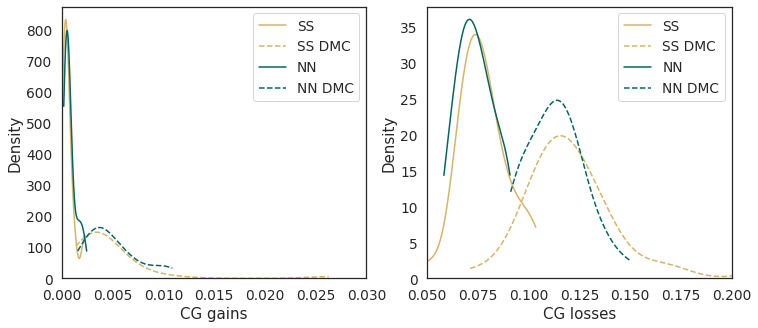

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'BB', "deviation_0_nonpoly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[1], ax=axs.flat[0], label = "SS" )
sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'BB', "deviation_0_poly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[1], ax=axs.flat[0], label = "SS DMC", ls = "--")

sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'AA', "deviation_0_nonpoly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[6], ax=axs.flat[0], label = "NN" )
sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'AA', "deviation_0_poly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[6], ax=axs.flat[0], label = "NN DMC", ls = "--")

axs.flat[0].set_xlabel("CG gains")
axs.flat[0].set_xlim((0, 0.03))
axs.flat[0].legend()


sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'BB', "deviation_1_nonpoly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[1], ax=axs.flat[1], label = "SS" )
sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'BB', "deviation_1_poly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[1], ax=axs.flat[1], label = "SS DMC", ls = "--")

sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'AA', "deviation_1_nonpoly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[6], ax=axs.flat[1], label = "NN" )
sns.kdeplot( req_mc_data['dev'].deviations.loc[req_mc_data['dev'].deviations['subpop'] == 'AA', "deviation_1_poly"], cut = 0, color=cb.diverging.BrBG_7.hex_colors[6], ax=axs.flat[1], label = "NN DMC", ls = "--")

axs.flat[1].set_xlabel("CG losses")
axs.flat[1].set_xlim((0.05, 0.2))
axs.flat[1].legend()


plt.savefig("epimutation_dmc.pdf", bbox_inches='tight')

plt.show()


In [7]:
mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb_rep2.csv", index_col = 0)
# mc_data = mc_data[pd.Series(mc_data.index).str.startswith("T16").values]
# mc_data = mc_data[pd.Series(mc_data.index).str.startswith("T4").values]

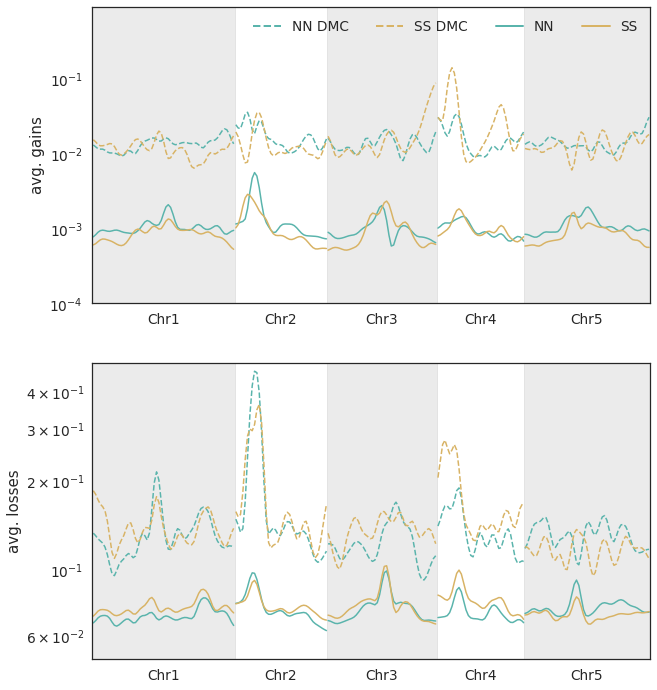

CPU times: user 1.2 s, sys: 206 ms, total: 1.41 s
Wall time: 1.14 s


In [18]:
%%time

fig, axs = plt.subplots(figsize = (10, 12), nrows = 2, ncols = 1)

plt_options = dict(line=True, nsmooth = 5, gap=0, ylim = (0.0001, 0.9))

ef_data_sub = mc_data.loc[:,mc_data.columns.str.startswith("subpop:")]
ef_data_sub.columns =ef_data_sub.columns.str.replace("subpop:", "")

ef_data_nonpoly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")]
ef_data_nonpoly.columns = ef_data_nonpoly.columns.str.replace("deviation_0_nonpoly:", "")
ef_data_nonpoly = ef_data_nonpoly.loc[:,ef_data_sub.columns]

ef_data_poly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_poly")]
ef_data_poly.columns = ef_data_poly.columns.str.replace("deviation_0_poly:", "")
ef_data_poly = ef_data_poly.loc[:,ef_data_sub.columns]


ef_data = ef_data_poly[ef_data_sub == 'AA'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['AA'], patch = "#bdbdbd", linestyle='--', label = "NN DMC"), axs = axs.flat[0] )
ef_data = ef_data_poly[ef_data_sub == 'BB'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['BB'], linestyle='--', label = "SS DMC"), axs = axs.flat[0] )

ef_data = ef_data_nonpoly[ef_data_sub == 'AA'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['AA'], linestyle='-', label = "NN"), axs = axs.flat[0] )
ef_data = ef_data_nonpoly[ef_data_sub == 'BB'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['BB'], linestyle='-', label = "SS"), axs = axs.flat[0] )


axs.flat[0].set(yscale = "log")
axs.flat[0].set_ylabel("avg. gains")

axs.flat[0].legend(handles = axs.flat[0].custum_legend[0], labels= axs.flat[0].custum_legend[1], ncol = 4, frameon = False)



#_____________________________________
plt_options = dict(line=True, nsmooth = 5, gap=0, ylim = (0.05, 0.5))

ef_data_sub = mc_data.loc[:,mc_data.columns.str.startswith("subpop:")]
ef_data_sub.columns =ef_data_sub.columns.str.replace("subpop:", "")

ef_data_nonpoly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")]
ef_data_nonpoly.columns = ef_data_nonpoly.columns.str.replace("deviation_1_nonpoly:", "")
ef_data_nonpoly = ef_data_nonpoly.loc[:,ef_data_sub.columns]

ef_data_poly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_poly")]
ef_data_poly.columns = ef_data_poly.columns.str.replace("deviation_1_poly:", "")
ef_data_poly = ef_data_poly.loc[:,ef_data_sub.columns]



ef_data = ef_data_poly[ef_data_sub == 'AA'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['AA'], patch = "#bdbdbd", linestyle='--'), axs = axs.flat[1])
ef_data = ef_data_poly[ef_data_sub == 'BB'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['BB'], linestyle='--'), axs = axs.flat[1])

ef_data = ef_data_nonpoly[ef_data_sub == 'AA'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['AA'], linestyle='-'), axs = axs.flat[1])
ef_data = ef_data_nonpoly[ef_data_sub == 'BB'].mean(0)
ef_data[ef_data.isna()] = ef_data.mean()
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.index) ), y_ind= ef_data.values, plt_options = dict(**plt_options, color = geno_color['BB'], linestyle='-'), axs = axs.flat[1] )

axs.flat[1].set(yscale = "log")
axs.flat[1].set_ylabel("avg. losses")

plt.savefig("mc_gains_losses_dmcs.pdf",bbox_inches='tight' )

plt.show()

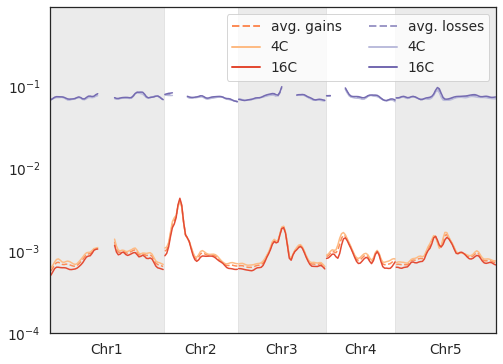

In [21]:
plt_options = dict(line=True, nsmooth = 3, gap=0, ylim = (0.0001, 0.9))

fig, axs = plt.subplots(figsize = (8, 6))


ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")]
ef_data.columns = ef_data.columns.str.replace("deviation_0_nonpoly:", "")

plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.columns) ), y_ind= ef_data.mean(0), plt_options = dict(**plt_options, color = cb.sequential.OrRd_6.hex_colors[3], linestyle='--', label = 'avg. gains', patch = "#bdbdbd"), axs = axs,  )
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.columns) ), y_ind= ef_data[ef_data.index.str.startswith("T4")].mean(0), plt_options = dict(**plt_options, color = cb.sequential.OrRd_6.hex_colors[2], linestyle='-', label = '4C'), axs = axs, )
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.columns) ), y_ind= ef_data[ef_data.index.str.startswith("T16")].mean(0), plt_options = dict(**plt_options, color = cb.sequential.OrRd_6.hex_colors[4], linestyle='-', label = '16C'), axs = axs )


ef_data = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")]
ef_data.columns = ef_data.columns.str.replace("deviation_1_nonpoly:", "")

plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.columns) ), y_ind= ef_data.mean(0), plt_options = dict(**plt_options, color = cb.sequential.Purples_6.hex_colors[3], linestyle='--', label = 'avg. losses'), axs = axs,  )
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.columns) ), y_ind= ef_data[ef_data.index.str.startswith("T4")].mean(0), plt_options = dict(**plt_options, color = cb.sequential.Purples_6.hex_colors[2], linestyle='-', label = '4C'), axs = axs  )
plotting_along_genome.manhattan_plot( x_ind=tair10.get_genomewide_inds( pd.Series(ef_data.columns) ), y_ind= ef_data[ef_data.index.str.startswith("T16")].mean(0), plt_options = dict(**plt_options, color = cb.sequential.Purples_6.hex_colors[4], linestyle='-', label = '16C'), axs = axs )


axs.legend(handles = axs.custum_legend[0], labels = axs.custum_legend[1], ncol = 2)

axs.set(yscale = "log")

plt.show()

In [16]:
ef_data_sub = mc_data.loc[:,mc_data.columns.str.startswith("subpop:")]
ef_data_sub.columns =ef_data_sub.columns.str.replace("subpop:", "")

ef_data_nonpoly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")]
ef_data_nonpoly.columns = ef_data_nonpoly.columns.str.replace("deviation_0_nonpoly:", "")
ef_data_nonpoly = ef_data_nonpoly.loc[:,ef_data_sub.columns]

ef_data_poly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_poly")]
ef_data_poly.columns = ef_data_poly.columns.str.replace("deviation_0_poly:", "")
ef_data_poly = ef_data_poly.loc[:,ef_data_sub.columns]


print( "AA nonpoly", pd.Series(ef_data_nonpoly[ef_data_sub == 'AA'].values.flatten()).dropna().describe() )

print( "AA poly", pd.Series(ef_data_poly[ef_data_sub == 'AA'].values.flatten()).dropna().describe() )


print( "BB nonpoly", pd.Series(ef_data_nonpoly[ef_data_sub == 'BB'].values.flatten()).dropna().describe() )

print( "BB poly", pd.Series(ef_data_poly[ef_data_sub == 'BB'].values.flatten()).dropna().describe() )


AA nonpoly count    18232.000000
mean         0.001109
std          0.002736
min          0.000000
25%          0.000224
50%          0.000685
75%          0.001361
max          0.224138
dtype: float64
AA poly count    17007.000000
mean         0.013913
std          0.036023
min          0.000000
25%          0.000000
50%          0.000000
75%          0.015013
max          1.033584
dtype: float64
BB nonpoly count    16980.000000
mean         0.000935
std          0.002241
min          0.000000
25%          0.000143
50%          0.000506
75%          0.001125
max          0.122807
dtype: float64
BB poly count    16045.000000
mean         0.015104
std          0.050976
min          0.000000
25%          0.000000
50%          0.003509
75%          0.013093
max          1.215087
dtype: float64


In [15]:
ef_data_sub = mc_data.loc[:,mc_data.columns.str.startswith("subpop:")]
ef_data_sub.columns =ef_data_sub.columns.str.replace("subpop:", "")

ef_data_nonpoly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")]
ef_data_nonpoly.columns = ef_data_nonpoly.columns.str.replace("deviation_1_nonpoly:", "")
ef_data_nonpoly = ef_data_nonpoly.loc[:,ef_data_sub.columns]

ef_data_poly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_poly")]
ef_data_poly.columns = ef_data_poly.columns.str.replace("deviation_1_poly:", "")
ef_data_poly = ef_data_poly.loc[:,ef_data_sub.columns]


print( "AA nonpoly", pd.Series(ef_data_nonpoly[ef_data_sub == 'AA'].values.flatten()).dropna().describe() )

print( "AA poly", pd.Series(ef_data_poly[ef_data_sub == 'AA'].values.flatten()).dropna().describe() )


print( "BB nonpoly", pd.Series(ef_data_nonpoly[ef_data_sub == 'BB'].values.flatten()).dropna().describe() )

print( "BB poly", pd.Series(ef_data_poly[ef_data_sub == 'BB'].values.flatten()).dropna().describe() )



AA nonpoly count    7482.000000
mean        0.073833
std         0.019076
min         0.000000
25%         0.063054
50%         0.072417
75%         0.082878
max         0.307692
dtype: float64
AA poly count    7223.000000
mean        0.142883
std         0.086710
min         0.000000
25%         0.093564
50%         0.130863
75%         0.176165
max         1.359298
dtype: float64
BB nonpoly count    7014.000000
mean        0.075306
std         0.019942
min         0.000000
25%         0.063855
50%         0.073817
75%         0.084591
max         0.344262
dtype: float64
BB poly count    6740.000000
mean        0.155885
std         0.129563
min         0.000000
25%         0.065342
50%         0.132214
75%         0.216027
max         1.510388
dtype: float64


In [16]:
pd.Series(ef_data_poly[ef_data_sub == 'AA'].values.flatten()).dropna().describe()

count    7703.000000
mean        0.001053
std         0.001923
min         0.000000
25%         0.000234
50%         0.000657
75%         0.001310
max         0.066964
dtype: float64

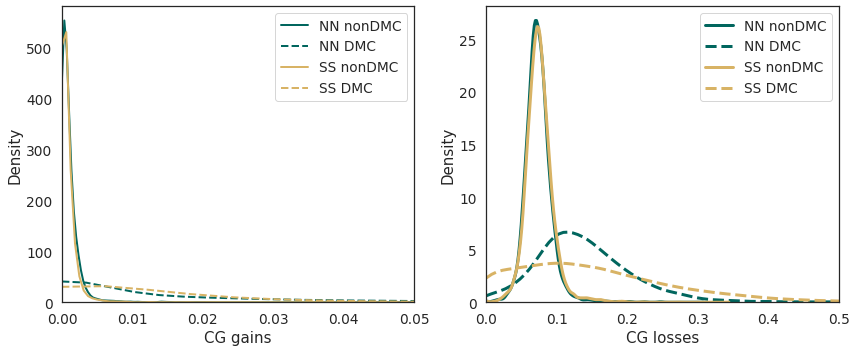

In [42]:
ef_data_sub = mc_data.loc[:,mc_data.columns.str.startswith("subpop:")]
ef_data_sub.columns =ef_data_sub.columns.str.replace("subpop:", "")

ef_data_nonpoly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_nonpoly")]
ef_data_nonpoly.columns = ef_data_nonpoly.columns.str.replace("deviation_0_nonpoly:", "")
ef_data_nonpoly = ef_data_nonpoly.loc[:,ef_data_sub.columns]

ef_data_poly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_0_poly")]
ef_data_poly.columns = ef_data_poly.columns.str.replace("deviation_0_poly:", "")
ef_data_poly = ef_data_poly.loc[:,ef_data_sub.columns]



fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

sns.kdeplot( x = pd.Series(ef_data_nonpoly[ef_data_sub == 'AA'].values.flatten()).dropna(), label = "NN nonDMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=2, cut = 0)

sns.kdeplot( x = pd.Series(ef_data_poly[ef_data_sub == 'AA'].values.flatten()).dropna(), label = "NN DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=2, cut = 0, ls = "--")

sns.kdeplot( x = pd.Series(ef_data_nonpoly[ef_data_sub == 'BB'].values.flatten()).dropna(), label = "SS nonDMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=2, cut = 0)

sns.kdeplot( x = pd.Series(ef_data_poly[ef_data_sub == 'BB'].values.flatten()).dropna(), label = "SS DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=2, cut = 0, ls = "--")


axs.flat[0].set_xlabel("CG gains")
axs.flat[0].set_xlim((0, 0.05))
axs.flat[0].legend()

ef_data_nonpoly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_nonpoly")]
ef_data_nonpoly.columns = ef_data_nonpoly.columns.str.replace("deviation_1_nonpoly:", "")
ef_data_nonpoly = ef_data_nonpoly.loc[:,ef_data_sub.columns]

ef_data_poly = mc_data.loc[:,mc_data.columns.str.startswith("deviation_1_poly")]
ef_data_poly.columns = ef_data_poly.columns.str.replace("deviation_1_poly:", "")
ef_data_poly = ef_data_poly.loc[:,ef_data_sub.columns]



sns.kdeplot( x = pd.Series(ef_data_nonpoly[ef_data_sub == 'AA'].values.flatten()).dropna(), label = "NN nonDMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=3, cut = 0)

sns.kdeplot( x = pd.Series(ef_data_poly[ef_data_sub == 'AA'].values.flatten()).dropna(), label = "NN DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=3, cut = 0, ls = "--")

sns.kdeplot( x = pd.Series(ef_data_nonpoly[ef_data_sub == 'BB'].values.flatten()).dropna(), label = "SS nonDMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=3, cut = 0)

sns.kdeplot( x = pd.Series(ef_data_poly[ef_data_sub == 'BB'].values.flatten()).dropna(), label = "SS DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=3, cut = 0, ls = "--")


axs.flat[1].set_xlabel("CG losses")
axs.flat[1].set_xlim((0, 0.5))
axs.flat[1].legend()



fig.tight_layout()

plt.show()


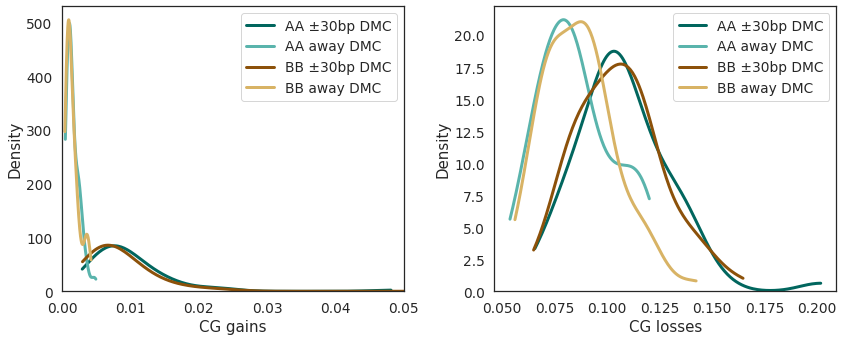

In [219]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))


sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_0_dmc", label = "AA ±30bp DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_0_nodmc", label = "AA away DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[5], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_0_dmc", label = "BB ±30bp DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[0], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_0_nodmc", label = "BB away DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=3, cut = 0)

axs.flat[0].set_xlabel("CG gains")
axs.flat[0].set_xlim((0, 0.05))
axs.flat[0].legend()


sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_1_dmc", label = "AA ±30bp DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_1_nodmc", label = "AA away DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[5], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_1_dmc", label = "BB ±30bp DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[0], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_1_nodmc", label = "BB away DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=3, cut = 0)

axs.flat[1].set_xlabel("CG losses")
# axs.flat[1].set_xlim((0, 0.05))
axs.flat[1].legend()



fig.tight_layout()

plt.show()

how about sites which are methylated in North and unmethylated in South

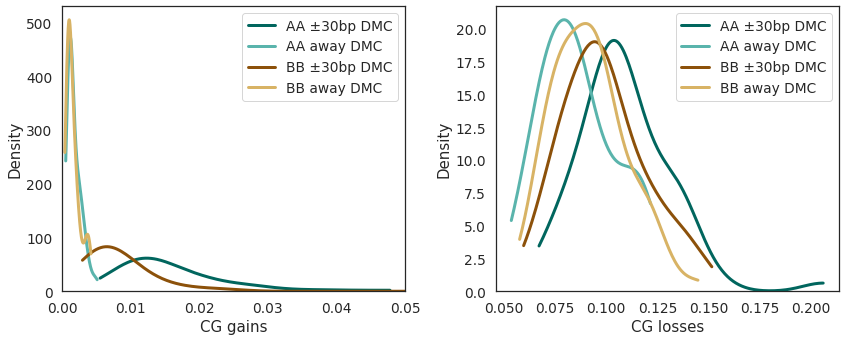

In [221]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))


sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_0_dmc", label = "AA ±30bp DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_0_nodmc", label = "AA away DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[5], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_0_dmc", label = "BB ±30bp DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[0], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_0_nodmc", label = "BB away DMC", ax = axs.flat[0], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=3, cut = 0)

axs.flat[0].set_xlabel("CG gains")
axs.flat[0].set_xlim((0, 0.05))
axs.flat[0].legend()


sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_1_dmc", label = "AA ±30bp DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[6], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'AA'], x = "deviation_1_nodmc", label = "AA away DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[5], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_1_dmc", label = "BB ±30bp DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[0], linewidth=3, cut = 0)

sns.kdeplot( data = req_mc_data['deviations'][req_mc_data['deviations']['subpop'] == 'BB'], x = "deviation_1_nodmc", label = "BB away DMC", ax = axs.flat[1], color=cb.diverging.BrBG_7.hex_colors[1], linewidth=3, cut = 0)

axs.flat[1].set_xlabel("CG losses")
# axs.flat[1].set_xlim((0, 0.05))
axs.flat[1].legend()



fig.tight_layout()

plt.show()

## Is there a nonCG change at the CG gbM *gain* sites?


1. Go through each individual
2. Identify sites where you see a gain...
3. check the nonCG sites in the vicinity.. calculate the deviation at this individual compared to the rest


Method 2.

Compare a nonCG site in the individual with epimutation event to other individuals at the same site.



In [8]:
%%time

req_mc_data = {}

req_mc_data['bed_str'] = "Chr3,1,5000000"  #,3500000" #"Chr1,1,2000000"
# req_mc_data['bed_str'] = "Chr5,17500001,18000000"  ## region on chromosome 5 which showed increase in gains for 6046


req_mc_data['inferred_geno_dict'] = cross_data.get_genotype_dict_at_bed_str("d1_2020", req_mc_data['bed_str'])[1].reindex( combined_mcs_f2s['meths'].file_ids ).reset_index().groupby("geno").groups


req_mc_data['mcs'] = combined_mcs_f2s['meths'].get_req_pos_bed_str( req_mc_data['bed_str'], req_mc_class = "C[ATGC][ATCG]", exon_bed_df=tair10.gene_exon )
req_mc_data['mcs'] = combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['mcs'])
req_mc_data['mcs']['mc_class'] = combined_mcs_f2s['meths'].__getattr__('mc_class', req_mc_data['mcs'].index.values)

req_mc_data['mcs']['mc_context'] = ""
req_mc_data['mcs'].loc[req_mc_data['mcs']['mc_class'].str.contains("CG[ATGC]", regex = True),'mc_context'] = "CG"
req_mc_data['mcs'].loc[req_mc_data['mcs']['mc_class'].str.contains("C[ATC]G", regex = True),'mc_context'] = "CHG"
req_mc_data['mcs'].loc[req_mc_data['mcs']['mc_class'].str.contains("C[ATC][ATC]", regex = True),'mc_context'] = "CHH"

req_mc_data['mcs']['genome_ix'] = tair10.get_genomewide_inds( req_mc_data['mcs'].iloc[:,[0,1]] )
req_mc_data['mcs']['data_idx'] = req_mc_data['mcs'].index.values
req_mc_data['mcs'] = req_mc_data['mcs'].reset_index(drop = True)
req_mc_data['context_ix'] = req_mc_data['mcs'].groupby('mc_context').groups



req_mc_data['mc_count'] = combined_mcs_f2s['meths'].__getattr__('mc_count', req_mc_data['mcs']['data_idx'].values)
req_mc_data['mc_total'] = combined_mcs_f2s['meths'].__getattr__('mc_total', req_mc_data['mcs']['data_idx'].values)
req_mc_data['permeths'] = combined_mcs_f2s['meths'].__getattr__('permeths', req_mc_data['mcs']['data_idx'].values)


req_mc_data['devs'] = bshap.combinemeths.CalculateEpimutations(mc_count=req_mc_data['mc_count'][req_mc_data['context_ix']['CG'],], mc_total=req_mc_data['mc_total'][req_mc_data['context_ix']['CG'],], sub_populations=req_mc_data['inferred_geno_dict']  )
req_mc_data['devs'].deviations = req_mc_data['devs'].calculate_gain_loss_for_homozygotes(population_keys=['AA','BB'])

CPU times: user 33.1 s, sys: 32.6 s, total: 1min 5s
Wall time: 1min 11s


In [25]:
def pivot_bed_to_req_positions(postions_to_pheno, centered_positions, min_bp = 5000, start_ix = 0 ):
    """
    Function to take mean at each position based on its distance from another start file
    """
    assert type(postions_to_pheno) is pd.DataFrame, "provide a dataframe"
    assert type(centered_positions) is pd.Series, "provide positions"
    mc_start_mat = np.tile( postions_to_pheno.iloc[:,start_ix].values, (centered_positions.shape[0], 1) ).T
    req_bed_mat = np.tile( centered_positions.values, (postions_to_pheno.shape[0], 1) )
    start_diff_mat = mc_start_mat - req_bed_mat
    postions_to_pheno['min_dist'] = start_diff_mat[np.arange(start_diff_mat.shape[0]), np.argmin(np.abs(start_diff_mat), 1)]
    postions_to_pheno = postions_to_pheno[np.abs(postions_to_pheno['min_dist']) < min_bp]
    return(postions_to_pheno)

In [65]:
%%time
updown = 1000

req_mc_data['noncg_epi'] = pd.DataFrame(0, index = np.arange(-updown, updown).astype(float), columns=['gain_cg_counts','gain_cg_total', 'gain_chg_counts','gain_chg_total','gain_chh_counts','gain_chh_total', 'loss_cg_counts','loss_cg_total','loss_chg_counts','loss_chg_total','loss_chh_counts','loss_chh_total'])


for ef_ix in pd.Series(req_mc_data['inferred_geno_dict']['BB']).sample(40):
    ef_ind_meths = req_mc_data['mcs'].copy()
    ef_ind_meths['mc'] = req_mc_data['permeths'][:,ef_ix]
    ef_ind_meths['mc_count'] = req_mc_data['mc_count'][:,ef_ix]
    ef_ind_meths['mc_total'] = req_mc_data['mc_total'][:,ef_ix]
    
    # bshap.stats.np_get_fraction(req_mc_data['mc_count'][:,ef_ix], req_mc_data['mc_total'][:,ef_ix], y_min = 5)
    gain_ix = np.where(req_mc_data['devs'].mc_meths['inherit_0_BB'].astype(bool) & (ef_ind_meths.loc[req_mc_data['context_ix']['CG'],'mc'] > 0.3).values  )[0]
    loss_ix = np.where(req_mc_data['devs'].mc_meths['inherit_1_BB'].astype(bool) & (ef_ind_meths.loc[req_mc_data['context_ix']['CG'],'mc'] < 0.7).values  )[0]
    
    ef_gain_closest = pivot_bed_to_req_positions(ef_ind_meths, ef_ind_meths.loc[req_mc_data['context_ix']['CG'][gain_ix],"start"], min_bp=updown, start_ix=1  )
    ef_loss_closest = pivot_bed_to_req_positions(ef_ind_meths, ef_ind_meths.loc[req_mc_data['context_ix']['CG'][loss_ix],"start"], min_bp=updown, start_ix=1  )
    
    t_cg_gain_ix = req_mc_data['context_ix']['CG'].values[np.where(req_mc_data['devs'].mc_meths['inherit_0_BB'].astype(bool))[0]]
    t_cg_loss_ix = req_mc_data['context_ix']['CG'].values[np.where(req_mc_data['devs'].mc_meths['inherit_1_BB'].astype(bool))[0]]
    
    ef_gain_cg = ef_gain_closest.reindex(t_cg_gain_ix).dropna().loc[:,['mc_count','mc_total','min_dist']].groupby('min_dist').sum()
    ef_loss_cg = ef_loss_closest.reindex(t_cg_loss_ix).dropna().loc[:,['mc_count','mc_total','min_dist']].groupby('min_dist').sum()
    ef_gain_chg = ef_gain_closest.reindex(req_mc_data['context_ix']['CHG']).dropna().loc[:,['mc_count','mc_total','min_dist']].groupby('min_dist').sum()
    ef_loss_chg = ef_loss_closest.reindex(req_mc_data['context_ix']['CHG']).dropna().loc[:,['mc_count','mc_total','min_dist']].groupby('min_dist').sum()
    ef_gain_chh = ef_gain_closest.reindex(req_mc_data['context_ix']['CHH']).dropna().loc[:,['mc_count','mc_total','min_dist']].groupby('min_dist').sum()
    ef_loss_chh = ef_loss_closest.reindex(req_mc_data['context_ix']['CHH']).dropna().loc[:,['mc_count','mc_total','min_dist']].groupby('min_dist').sum()
    
    req_mc_data['noncg_epi'].loc[:,['gain_cg_counts','gain_cg_total']] = np.nansum(np.dstack((req_mc_data['noncg_epi'].loc[:,['gain_cg_counts','gain_cg_total']].values,ef_gain_cg.reindex(req_mc_data['noncg_epi'].index).values)),2)
    req_mc_data['noncg_epi'].loc[:,['gain_chg_counts','gain_chg_total']] = np.nansum(np.dstack((req_mc_data['noncg_epi'].loc[:,['gain_chg_counts','gain_chg_total']].values,ef_gain_chg.reindex(req_mc_data['noncg_epi'].index).values)),2)
    req_mc_data['noncg_epi'].loc[:,['gain_chh_counts','gain_chh_total']] = np.nansum(np.dstack((req_mc_data['noncg_epi'].loc[:,['gain_chh_counts','gain_chh_total']].values,ef_gain_chh.reindex(req_mc_data['noncg_epi'].index).values)),2)
    req_mc_data['noncg_epi'].loc[:,['loss_cg_counts','loss_cg_total']] = np.nansum(np.dstack((req_mc_data['noncg_epi'].loc[:,['loss_cg_counts','loss_cg_total']].values,ef_loss_cg.reindex(req_mc_data['noncg_epi'].index).values)),2)
    req_mc_data['noncg_epi'].loc[:,['loss_chg_counts','loss_chg_total']] = np.nansum(np.dstack((req_mc_data['noncg_epi'].loc[:,['loss_chg_counts','loss_chg_total']].values,ef_loss_chg.reindex(req_mc_data['noncg_epi'].index).values)),2)
    req_mc_data['noncg_epi'].loc[:,['loss_chh_counts','loss_chh_total']] = np.nansum(np.dstack((req_mc_data['noncg_epi'].loc[:,['loss_chh_counts','loss_chh_total']].values,ef_loss_chh.reindex(req_mc_data['noncg_epi'].index).values)),2)


for ef_ix in ['gain_cg','gain_chg','gain_chh','loss_cg','loss_chg','loss_chh']:
    req_mc_data['noncg_epi'][ef_ix] = bshap.stats.np_get_fraction(req_mc_data['noncg_epi'][ef_ix + '_counts'].values, req_mc_data['noncg_epi'][ef_ix + '_total'].values, y_min=5)

CPU times: user 3min 9s, sys: 5min 15s, total: 8min 24s
Wall time: 8min 24s


Text(0.5, 0, 'distance to mCG gain')

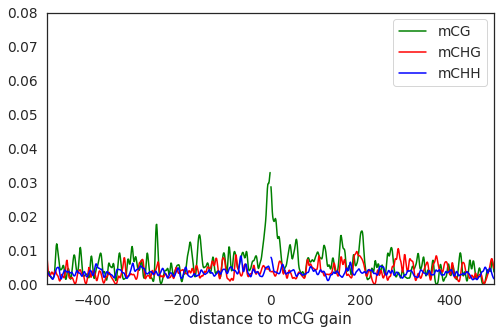

In [80]:
nsmooth = 10
fig, axs = plt.subplots(figsize = (8, 5))

ef_data = req_mc_data['noncg_epi']['gain_cg'].dropna()
sns.lineplot(x = ef_data[1:].index, y = pyquant.utils.smooth_sum(ef_data[1:], nsmooth), color = "green", ax = axs)
sns.lineplot(x = ef_data[:-1].index, y = pyquant.utils.smooth_sum(ef_data[:-1], nsmooth), color = "green", ax = axs, label = "mCG")

ef_data = req_mc_data['noncg_epi']['gain_chg'].dropna()
sns.lineplot(x = ef_data[0:].index, y = pyquant.utils.smooth_sum(ef_data[0:], nsmooth), color = "red", ax = axs)
sns.lineplot(x = ef_data[:0].index, y = pyquant.utils.smooth_sum(ef_data[:0], nsmooth), color = "red", ax = axs, label = "mCHG")

ef_data = req_mc_data['noncg_epi']['gain_chh'].dropna()
sns.lineplot(x = ef_data[0:].index, y = pyquant.utils.smooth_sum(ef_data[0:], nsmooth), color = "blue", ax = axs)
sns.lineplot(x = ef_data[:0].index, y = pyquant.utils.smooth_sum(ef_data[:0], nsmooth), color = "blue", ax = axs, label = "mCHH")


axs.set_xlim(-500, 500)
axs.set_ylim(0,0.08)
axs.set_xlabel("distance to mCG gain")

Text(0.5, 0, 'distance to mCG loss')

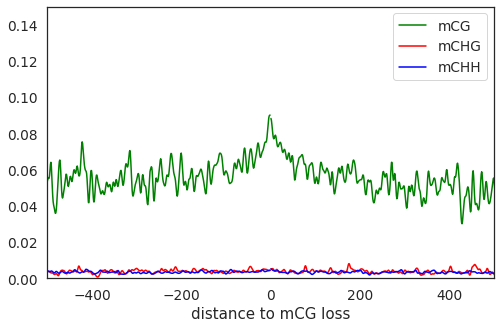

In [84]:
nsmooth = 10
fig, axs = plt.subplots(figsize = (8, 5))

ef_data = req_mc_data['noncg_epi']['loss_cg'].dropna()
sns.lineplot(x = ef_data[1:].index, y = 1 - pyquant.utils.smooth_sum(ef_data[1:], nsmooth), color = "green", ax = axs)
sns.lineplot(x = ef_data[:-1].index, y = 1 - pyquant.utils.smooth_sum(ef_data[:-1], nsmooth), color = "green", ax = axs, label = "mCG")

ef_data = req_mc_data['noncg_epi']['loss_chg'].dropna()
sns.lineplot(x = ef_data[0:].index, y = pyquant.utils.smooth_sum(ef_data[0:], nsmooth), color = "red", ax = axs)
sns.lineplot(x = ef_data[:0].index, y = pyquant.utils.smooth_sum(ef_data[:0], nsmooth), color = "red", ax = axs, label = 'mCHG')


ef_data = req_mc_data['noncg_epi']['loss_chh'].dropna()
sns.lineplot(x = ef_data[0:].index, y = pyquant.utils.smooth_sum(ef_data[0:], nsmooth), color = "blue", ax = axs)
sns.lineplot(x = ef_data[:0].index, y = pyquant.utils.smooth_sum(ef_data[:0], nsmooth), color = "blue", ax = axs, label = 'mCHH')


axs.set_xlim(-500, 500)
axs.set_ylim(0, 0.15)
axs.set_xlabel("distance to mCG loss")

In [27]:
%%time

req_mc_data['samples'] = combined_mcs_f2s['samples'].reindex(combined_mcs_f2s['meths'].file_ids).copy()

for ef_context in req_mc_data['mcs'].groupby("mc_context"):
    req_mc_data['deviations_' + ef_context[0]] = bshap.combinemeths.calculate_deviations_f2_populations(
        req_mc_data['mc_count'][ef_context[1].index.values,:],
        req_mc_data['mc_total'][ef_context[1].index.values,:],
        req_mc_data['inferred_geno_dict']
    )
    req_mc_data['deviations_' + ef_context[0]]['deviations'].index = combined_mcs_f2s['meths'].file_ids[ req_mc_data['deviations_' + ef_context[0]][ 'deviations' ].index]
    
    req_mc_data['samples'].loc[:,"deviation_0_" + ef_context[0]] = req_mc_data['deviations_' + ef_context[0]]['deviations']['deviation_0']
    req_mc_data['samples'].loc[:,"deviation_1_" + ef_context[0]] = req_mc_data['deviations_' + ef_context[0]]['deviations']['deviation_1']
    
    req_mc_data['deviations_' + ef_context[0]]['permeths_subpop']['mcs_idx'] = ef_context[1].index.values
    req_mc_data['deviations_' + ef_context[0]]['permeths_subpop']['data_idx'] = ef_context[1]['data_idx'].values
    
req_mc_data['samples'].loc[:,'subpop'] = req_mc_data['deviations_CG']['deviations']['subpop']



req_mc_data['chg_intersect_cg'] = bshap.run_bedtools.get_intersect_bed_ix( reference_bed=combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['deviations_CG']['permeths_subpop']['data_idx'].values, updown = 20 ), query_bed = req_mc_data['mcs'].iloc[req_mc_data['deviations_CHG']['permeths_subpop']['mcs_idx'].values,:].iloc[:,[0,1,2]], just_names=False )
req_mc_data['chg_intersect_cg']['data_idx'] = req_mc_data['deviations_CHG']['permeths_subpop'].loc[req_mc_data['chg_intersect_cg']['query_ix'],"data_idx"].values
req_mc_data['chg_intersect_cg']['mcs_idx'] = req_mc_data['deviations_CHG']['permeths_subpop'].loc[req_mc_data['chg_intersect_cg']['query_ix'], "mcs_idx"].values

req_mc_data['chh_intersect_cg'] = bshap.run_bedtools.get_intersect_bed_ix( reference_bed=combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['deviations_CG']['permeths_subpop']['data_idx'].values, updown = 20 ), query_bed = req_mc_data['mcs'].iloc[req_mc_data['deviations_CHH']['permeths_subpop']['mcs_idx'].values,:].iloc[:,[0,1,2]], just_names=False )
req_mc_data['chh_intersect_cg']['data_idx'] = req_mc_data['deviations_CHH']['permeths_subpop'].loc[req_mc_data['chh_intersect_cg']['query_ix'],"data_idx"].values
req_mc_data['chh_intersect_cg']['mcs_idx'] = req_mc_data['deviations_CHH']['permeths_subpop'].loc[req_mc_data['chh_intersect_cg']['query_ix'], "mcs_idx"].values

CPU times: user 28.8 s, sys: 10.8 s, total: 39.7 s
Wall time: 46.2 s


In [35]:
%%time


for ef_ind in req_mc_data['samples'].reset_index().iterrows():
    if pd.isna(ef_ind[1]['subpop']):
        continue
    ef_mcs_cg_inherit_0_idx = np.where(req_mc_data['deviations_CG']['permeths_subpop']['inherit_0_' + ef_ind[1]['subpop']].astype(bool))[0]
    ef_mcs_cg_inherit_1_idx = np.where(req_mc_data['deviations_CG']['permeths_subpop']['inherit_1_' + ef_ind[1]['subpop']].astype(bool))[0]
    with np.errstate(invalid='ignore'):
        ef_ind_denovo_ix = ef_mcs_cg_inherit_0_idx[np.where(req_mc_data['permeths'][req_mc_data['deviations_CG']['permeths_subpop']['mcs_idx'].values[ef_mcs_cg_inherit_0_idx], ef_ind[0]] >= 0.4)[0]]
    if len(ef_ind_denovo_ix) <= 1:
        continue
    ef_mcs_chg_denovo_ix = req_mc_data['chg_intersect_cg']['mcs_idx'].values[ np.where(np.isin(req_mc_data['chg_intersect_cg']['ref_ix'], ef_ind_denovo_ix))[0] ]
    ef_mcs_chh_denovo_ix = req_mc_data['chh_intersect_cg']['mcs_idx'].values[ np.where(np.isin(req_mc_data['chh_intersect_cg']['ref_ix'], ef_ind_denovo_ix))[0] ]
    
    ef_mcs_chg_random = np.sort(np.random.choice(req_mc_data['deviations_CHG']['permeths_subpop']['mcs_idx'].values, ef_mcs_chg_denovo_ix.shape))
    ef_mcs_chh_random = np.sort(np.random.choice(req_mc_data['deviations_CHH']['permeths_subpop']['mcs_idx'].values, ef_mcs_chh_denovo_ix.shape))
    

    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHG_at_gain_CG'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chg_denovo_ix,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chg_denovo_ix,ef_ind[0]].sum(), y_min=20))
    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHG_gain_rand'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chg_random,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chg_random,ef_ind[0]].sum(), y_min=20))
    
    
    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHH_at_gain_CG'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chh_denovo_ix,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chh_denovo_ix,ef_ind[0]].sum(), y_min=20))
    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHH_gain_rand'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chh_random,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chh_random,ef_ind[0]].sum(), y_min=20))
    

CPU times: user 3.08 s, sys: 19.2 ms, total: 3.1 s
Wall time: 3.1 s


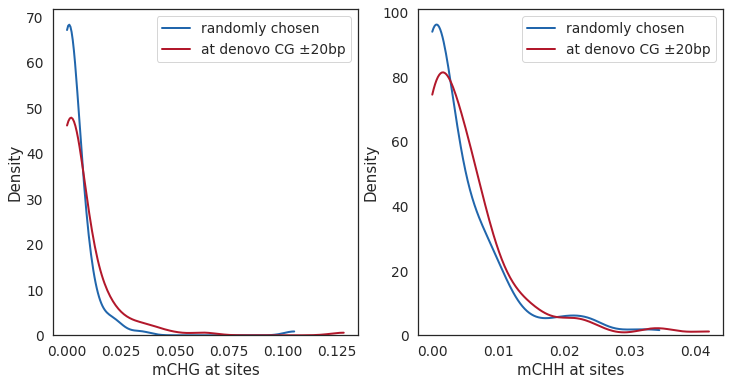

In [36]:
fig, axs = plt.subplots(ncols=2, figsize = (12,6))


sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHG_gain_rand", color = cb.diverging.RdBu_7.hex_colors[6], linewidth = 2, cut = 0, label = "randomly chosen", ax=axs[0] )
sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHG_at_gain_CG", color = cb.diverging.RdBu_7.hex_colors[0],cut = 0, label = "at denovo CG ±20bp", ax = axs[0], linewidth = 2 )
axs[0].set_xlabel("mCHG at sites")
axs[0].legend()



sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHH_gain_rand", color = cb.diverging.RdBu_7.hex_colors[6], cut = 0, label = "randomly chosen", ax = axs[1], linewidth = 2 )
sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHH_at_gain_CG", color = cb.diverging.RdBu_7.hex_colors[0], cut = 0,  label = "at denovo CG ±20bp", ax=axs[1], linewidth = 2)
axs[1].set_xlabel("mCHH at sites")
axs[1].legend()


plt.show()

In [30]:
%%time

for ef_ind in req_mc_data['samples'].reset_index().iterrows():
    if pd.isna(ef_ind[1]['subpop']):
        continue
    # print(ef_ind[1]['subpop'])
    ef_mcs_cg_inherit_0_idx = np.where(req_mc_data['deviations_CG']['permeths_subpop']['inherit_0_' + ef_ind[1]['subpop']].astype(bool))[0]
    ef_mcs_cg_inherit_1_idx = np.where(req_mc_data['deviations_CG']['permeths_subpop']['inherit_1_' + ef_ind[1]['subpop']].astype(bool))[0]
    with np.errstate(invalid='ignore'):
        ef_ind_demeth_ix = ef_mcs_cg_inherit_1_idx[np.where(req_mc_data['permeths'][req_mc_data['deviations_CG']['permeths_subpop']['mcs_idx'].values[ef_mcs_cg_inherit_1_idx], ef_ind[0]] <= 0.6)[0]]
    if len(ef_ind_denovo_ix) <= 1:
        continue
    ef_mcs_chg_denovo_ix = req_mc_data['chg_intersect_cg']['mcs_idx'].values[ np.where(np.isin(req_mc_data['chg_intersect_cg']['ref_ix'], ef_ind_demeth_ix))[0] ]
    ef_mcs_chh_denovo_ix = req_mc_data['chh_intersect_cg']['mcs_idx'].values[ np.where(np.isin(req_mc_data['chh_intersect_cg']['ref_ix'], ef_ind_demeth_ix))[0] ]
    
    ef_mcs_chg_random = np.sort(np.random.choice(req_mc_data['deviations_CHG']['permeths_subpop']['mcs_idx'].values, ef_mcs_chg_denovo_ix.shape))
    ef_mcs_chh_random = np.sort(np.random.choice(req_mc_data['deviations_CHH']['permeths_subpop']['mcs_idx'].values, ef_mcs_chh_denovo_ix.shape))
    

    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHG_at_loss_CG'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chg_denovo_ix,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chg_denovo_ix,ef_ind[0]].sum(), y_min=20))
    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHG_loss_rand'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chg_random,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chg_random,ef_ind[0]].sum(), y_min=20))
    
    
    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHH_at_loss_CG'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chh_denovo_ix,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chh_denovo_ix,ef_ind[0]].sum(), y_min=20))
    req_mc_data['samples'].loc[req_mc_data['samples'].index[ef_ind[0]], 'mCHH_loss_rand'] = float(snpmatch.snpmatch.np_get_fraction(req_mc_data['mc_count'][ef_mcs_chh_random,ef_ind[0]].sum(), req_mc_data['mc_total'][ef_mcs_chh_random,ef_ind[0]].sum(), y_min=20))
    

CPU times: user 8.2 s, sys: 71.3 ms, total: 8.28 s
Wall time: 8.27 s


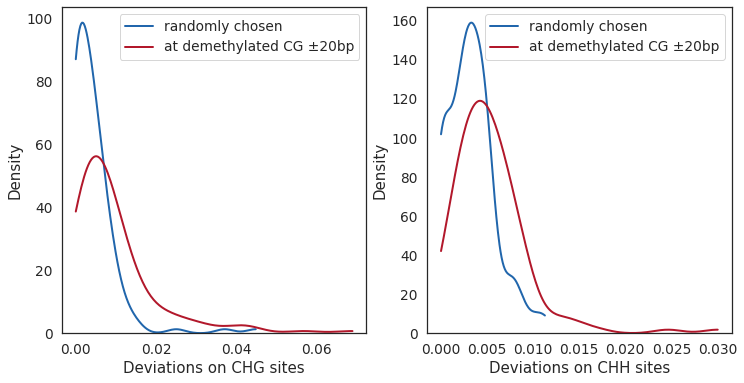

In [31]:
fig, axs = plt.subplots(ncols=2, figsize = (12,6))


sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHG_loss_rand", color = cb.diverging.RdBu_7.hex_colors[6], linewidth = 2, cut = 0, label = "randomly chosen", ax=axs[0] )
sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHG_at_loss_CG", color = cb.diverging.RdBu_7.hex_colors[0], linewidth = 2,cut = 0, label = "at demethylated CG ±20bp", ax = axs[0] )
axs[0].set_xlabel("Deviations on CHG sites")
axs[0].legend()



sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHH_loss_rand", color = cb.diverging.RdBu_7.hex_colors[6], linewidth = 2, cut = 0, label = "randomly chosen", ax = axs[1] )
sns.kdeplot( data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'], x = "mCHH_at_loss_CG", color = cb.diverging.RdBu_7.hex_colors[0], linewidth = 2, cut = 0,  label = "at demethylated CG ±20bp", ax=axs[1] )
axs[1].set_xlabel("Deviations on CHH sites")
axs[1].legend()


plt.show()

CHH_random vs. CHH_gainedCG: Mann-Whitney-Wilcoxon test two-sided, P_val:8.027e-02 U_stat=6.849e+03
CHG_random vs. CHG_gainedCG: Mann-Whitney-Wilcoxon test two-sided, P_val:2.087e-02 U_stat=4.940e+03
CHH_random vs. CHH_lostCG: Mann-Whitney-Wilcoxon test two-sided, P_val:2.715e-07 U_stat=6.422e+03
CHG_random vs. CHG_lostCG: Mann-Whitney-Wilcoxon test two-sided, P_val:6.802e-09 U_stat=5.800e+03


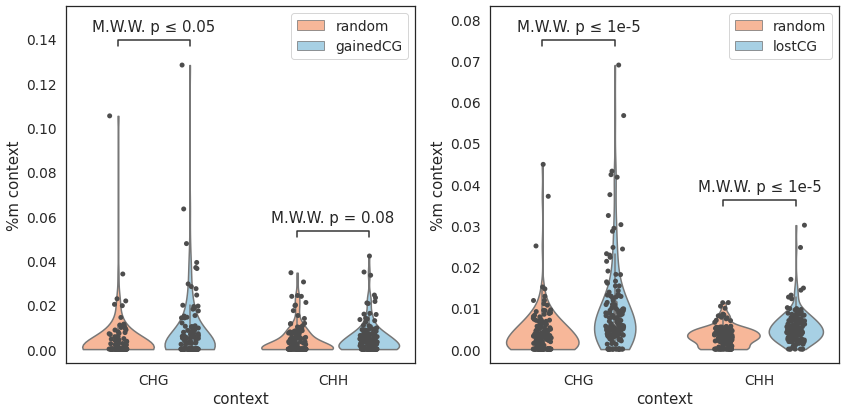

In [37]:
ef_data = req_mc_data['samples'][req_mc_data['samples']['subpop'] != 'AB'].dropna(how = "all")
ef_data = ef_data.loc[:,ef_data.columns.str.startswith("mCH")]

ef_data = pd.melt(ef_data).dropna()
ef_data.loc[ef_data['variable'].str.contains("loss"), 'sites'] = "loss"
ef_data.loc[ef_data['variable'].str.contains("gain"), 'sites'] = "gain"
ef_data.loc[ef_data['variable'].str.contains("CHG"), 'context'] = "CHG"
ef_data.loc[ef_data['variable'].str.contains("CHH"), 'context'] = "CHH"
ef_data.loc[ef_data['variable'].str.contains("rand"), 'hue'] = "random"
ef_data.loc[ef_data['variable'].str.contains("CG") & ef_data['variable'].str.contains("gain"), 'hue'] = "gainedCG"
ef_data.loc[ef_data['variable'].str.contains("CG") & ef_data['variable'].str.contains("loss"), 'hue'] = "lostCG"


configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}

fig, axs = plt.subplots(ncols=2, figsize = (12, 6))


fig_args = {
    "data": ef_data[ef_data['sites'] == "gain"],
    "x": "context",
    "y": "value",
    "hue": "hue",
    "ax": axs.flat[0],
    "dodge": True,
    "hue_order": ['random', 'gainedCG']
}

sns.violinplot(**fig_args, palette = "RdBu", cut = 0, saturation = 1 )
sns.stripplot(**fig_args, palette=[".3"] * 4)
annotator = Annotator.Annotator(**fig_args, pairs = [ (('CHG', 'gainedCG'), ('CHG', 'random')), (('CHH', 'gainedCG'), ('CHH', 'random')) ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()
handles, labels = axs.flat[0].get_legend_handles_labels()
axs.flat[0].legend(handles[0:2], labels[0:2])
axs.flat[0].set_ylabel( "%m context" )

# bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.



fig_args = {
    "data": ef_data[ef_data['sites'] == "loss"],
    "x": "context",
    "y": "value",
    "hue": "hue",
    "ax": axs.flat[1],
    "dodge": True,
    "hue_order": ['random', 'lostCG']
}
sns.violinplot(**fig_args, palette = "RdBu", cut = 0, saturation = 1 )
sns.stripplot(**fig_args, palette=[".3"] * 4)
annotator = Annotator.Annotator(**fig_args, pairs = [ (('CHG', 'lostCG'), ('CHG', 'random')), (('CHH', 'lostCG'), ('CHH', 'random')) ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()
handles, labels = axs.flat[1].get_legend_handles_labels()
axs.flat[1].legend(handles[0:2], labels[0:2])
axs.flat[1].set_ylabel( "%m context" )


fig.tight_layout()
plt.show()

## Stable inheritace of mCG over generations. 

mendelian segregation for mCG


In [7]:
# %%time


# ### Taking a big ass matrix for all the samples.
# req_mc_data = {}
# req_mc_data['samples'] = combined_mcs_all['samples'].copy()
# req_mc_data['bed_str'] = "Chr5,1,5000000"
# # req_mc_data['bed_str'] = "Chr4,5000001,5500000"
# # req_mc_data['bed_str'] = "Chr1,21000001,23000000"
# # req_mc_data['bed_str'] = "Chr5,16750001,18750000"

# req_mc_data['samples']['geno'] = pd.concat([cross_data.get_genotype_dict_at_bed_str("d1_2020", req_mc_data['bed_str'] )[1]['geno'], cross_data.get_genotype_dict_at_bed_str("d2_2020", req_mc_data['bed_str'] )[1]['geno']])
# req_mc_data['mcs_exon'] = combined_mcs_all['meths'].get_req_pos_bed_str(req_mc_data['bed_str'], req_mc_class = "C[ATGC][ATCG]", exon_bed_df=tair10.gene_exon )
# req_mc_data['mcs_exon'] = pd.DataFrame({'mc_class': combined_mcs_all['meths'].__getattr__("mc_class", req_mc_data['mcs_exon']) }, index = req_mc_data['mcs_exon'] )
# req_mc_data['mcs_exon']['CG'] = req_mc_data['mcs_exon']['mc_class'].str.contains( "CG[ATGC]" )
# req_mc_data['mcs_exon']['CHG'] = req_mc_data['mcs_exon']['mc_class'].str.contains( "C[ATC]G" )
# req_mc_data['mcs_exon']['CHH'] = req_mc_data['mcs_exon']['mc_class'].str.contains( "C[ATC][ATC]" )
# req_mc_data['mcs_exon'] = pd.merge( combined_mcs_all['meths'].get_bed_pos_ix( req_mc_data['mcs_exon'].index.values, updown = None), req_mc_data['mcs_exon'], right_index=True, left_index=True)


# req_mc_data['req_acc_ix'] = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["P_6046", "P_6191", "F1_D1", "F1_D2"]}
# req_mc_data['req_acc_ix'].update( {ef: req_mc_data['samples'].reset_index().groupby((req_mc_data['samples']['geno_dir'] + "_" + req_mc_data['samples']['geno']).values).groups[ef] for ef in ["F2_D1_AA", "F2_D1_AB", "F2_D1_BB","F2_D2_AA", "F2_D2_BB", "F2_D2_AB"]} )

# req_mc_data['deviations'] = combined_mcs_all['meths'].calculate_per_meths_per_population( req_mc_data['req_acc_ix'], req_mc_data['mcs_exon'].index[req_mc_data['mcs_exon']['CG']].values  )
# req_mc_data['deviations'].mc_meths = pd.merge(req_mc_data['mcs_exon'][req_mc_data['mcs_exon']['CG']], req_mc_data['deviations'].mc_meths, right_index=True, left_index=True  )

In [8]:
def get_deviations_all(samples, bed_str, combined_mcs, qtl_map, calc= False):
    req_samples = samples.copy()
    req_samples['geno'] = pd.concat([qtl_map.get_genotype_dict_at_bed_str("d1_2020", bed_str )[1]['geno'], qtl_map.get_genotype_dict_at_bed_str("d2_2020", bed_str )[1]['geno']])
    mcg_gbm_ix = combined_mcs_all['meths'].get_req_pos_bed_str(bed_str, req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )
    
    req_acc_ix = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["P_6046", "P_6191", "F1_D1", "F1_D2"]}
    req_acc_ix.update( {ef: req_samples.reset_index().groupby((req_samples['geno_dir'] + "_" + req_samples['geno'].fillna('')).values).groups[ef] for ef in ["F2_D1_AA", "F2_D1_AB", "F2_D1_BB","F2_D2_AA", "F2_D2_AB", "F2_D2_BB"]} )
    
    # req_acc_ix = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["6046_T4", "6191_T4", "F1_D1", "F1_D2"]}
    # req_acc_ix.update( {ef: req_samples.reset_index().groupby((req_samples['dir_temp'] + "_" + req_samples['geno'].fillna('')).values).groups[ef] for ef in ["D1_T4_AA", "D1_T4_AB", "D1_T4_BB","D2_T4_AA", "D2_T4_AB", "D2_T4_BB"]} )
    
    mc_data = combined_mcs.calculate_per_meths_per_population( sub_populations=req_acc_ix, filter_cg_pos_ix = mcg_gbm_ix, params_meths = dict(prop_y_min = 10), calc_deviations=calc )
    return(mc_data)

In [97]:
plotting_along_genome.chr_info

chr       len       mid  chr_ind_start  chr_ind_end
0  Chr1  30427671  15213835              0     30427671
1  Chr2  19698289   9849144       30427671     50125960
2  Chr3  23459830  11729915       50125960     73585790
3  Chr4  18585056   9292528       73585790     92170846
4  Chr5  26975502  13487751       92170846    119146348

In [131]:
%%time
req_mc_data = {}

# req_mc_data['bed_str'] = "Chr5,1,1000000"
# req_mc_data['deviations'] = get_deviations_all(combined_mcs_all['samples'], req_mc_data['bed_str'], combined_mcs_all['meths'], cross_data )


# req_mc_data['chr'] = 'Chr1'
# req_mc_data['mc_meths'] = pd.DataFrame()
# for ef_bin in np.arange(1,30427671, 1000000):
#     ef_data = get_deviations_all(combined_mcs_all['samples'], req_mc_data['chr'] + ',' + str(ef_bin) + ',' + str(ef_bin + 1000000)  , combined_mcs_all['meths'], cross_data )
#     req_mc_data['mc_meths'] = pd.concat([req_mc_data['mc_meths'], ef_data.mc_meths], ignore_index=False)
    
# ### DO not do this unless you check
# req_mc_data['mc_meths'] = req_mc_data['mc_meths'].reset_index()
# req_mc_data['mc_meths'].to_hdf('cache_data/mc_meths.chr5.h5', mode = 'w', key = 'mcs') 
# req_mc_data['mc_meths'].to_hdf('cache_data/mc_meths.chr1.h5', mode = 'w', key = 'mcs') 

req_mc_data['mc_meths'] = pd.read_hdf('cache_data/mc_meths.chr5.h5', mode = 'r' )
# req_mc_data['mc_meths'] = pd.read_hdf('cache_data/mc_meths.chr1.h5', mode = 'r' )

# req_mc_data['mc_meths'] = req_mc_data['mc_meths'].reset_index()

ef_data = req_mc_data['mc_meths'].copy()
req_mc_data['mc_meths'] = req_mc_data['mc_meths'].iloc[ef_data.loc[:,['P_6046','P_6191','F2_D1_AA','F2_D2_AA', 'F2_D1_AB', 'F2_D2_AB','F2_D1_BB','F2_D2_BB']].dropna().index,:]

CPU times: user 249 ms, sys: 223 ms, total: 471 ms
Wall time: 503 ms


In [132]:
def find_mcg_homo(counts, total):
    inherit_0 = bshap.stats.np_binom_test(counts, total, 0.2, alternative='less' ) < 0.05
    inherit_1 = bshap.stats.np_binom_test(counts, total, 0.7, alternative='greater' ) < 0.05
    return( (inherit_0 | inherit_1) )


def find_mcg_het(counts, total):
    return( bshap.stats.np_binom_test(counts, total, 0.5, alternative='two-sided' ) < 0.05 )

ef_data = req_mc_data['mc_meths'].copy()
ef_data = ef_data[find_mcg_homo(ef_data['mc_count_P_6046'].values, ef_data['mc_total_P_6046'].values)]
ef_data = ef_data[find_mcg_homo(ef_data['mc_count_P_6191'].values, ef_data['mc_total_P_6191'].values)]
req_mc_data['req_meths'] = ef_data.loc[:,['P_6046','P_6191','F2_D1_AA','F2_D2_AA','F2_D1_BB','F2_D2_BB']].dropna()


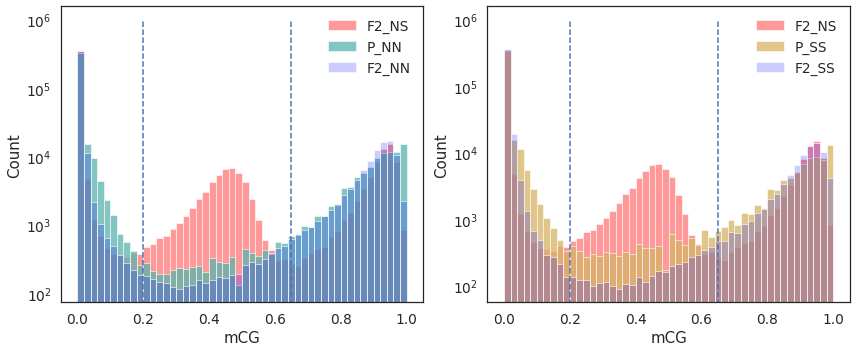

In [12]:
ef_data = req_mc_data['mc_meths'].copy()

fig, axs = plt.subplots(figsize = (12,5), ncols = 2)

sns.histplot(ef_data['F2_D1_AB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = "red", label = 'F2_NS', alpha = 0.4)
sns.histplot(ef_data['P_6046'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = geno_color['AA'], label = 'P_NN')
sns.histplot(ef_data['F2_D1_AA'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = 'blue', label = 'F2_NN', alpha = 0.2)

axs.flat[0].vlines((0.2, 0.65), ymin = 0, ymax = 10**6, linestyle = '--')
axs.flat[0].legend(frameon = False)
axs.flat[0].set_yscale('log')
axs.flat[0].set_xlabel('mCG')


sns.histplot(ef_data['F2_D1_AB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = "red", label = 'F2_NS', alpha = 0.4)
sns.histplot(ef_data['P_6191'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = geno_color['BB'], label = 'P_SS')
sns.histplot(ef_data['F2_D1_BB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = "blue", label = 'F2_SS', alpha = 0.2)
axs.flat[1].vlines((0.2, 0.65), ymin = 0, ymax = 10**6, linestyle = '--')
axs.flat[1].legend(frameon = False)
axs.flat[1].set_yscale('log')
axs.flat[1].set_xlabel('mCG')

fig.tight_layout()
plt.show()

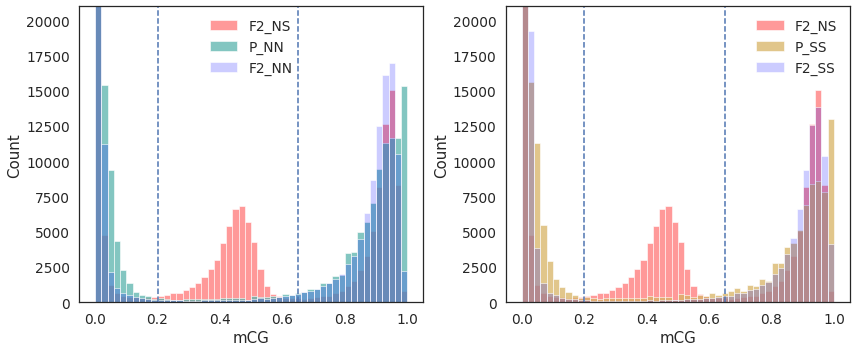

In [30]:
ef_data = req_mc_data['mc_meths'].copy()

fig, axs = plt.subplots(figsize = (12,5), ncols = 2)

sns.histplot(ef_data['F2_D1_AB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = "red", label = 'F2_NS', alpha = 0.4)
sns.histplot(ef_data['P_6046'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = geno_color['AA'], label = 'P_NN')
sns.histplot(ef_data['F2_D1_AA'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = 'blue', label = 'F2_NN', alpha = 0.2)

axs.flat[0].vlines((0.2, 0.65), ymin = 0, ymax = 21000, linestyle = '--')
axs.flat[0].set_ylim(0, 21000)
axs.flat[0].legend(frameon = False)
# axs.flat[0].set_yscale('log')
axs.flat[0].set_xlabel('mCG')


sns.histplot(ef_data['F2_D1_AB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = "red", label = 'F2_NS', alpha = 0.4)
sns.histplot(ef_data['P_6191'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = geno_color['BB'], label = 'P_SS')
sns.histplot(ef_data['F2_D1_BB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = "blue", label = 'F2_SS', alpha = 0.2)
axs.flat[1].vlines((0.2, 0.65), ymin = 0, ymax = 21000, linestyle = '--')
axs.flat[1].set_ylim(0, 21000)
axs.flat[1].legend(frameon = False)
# axs.flat[1].set_yscale('log')
axs.flat[1].set_xlabel('mCG')

fig.tight_layout()
plt.show()

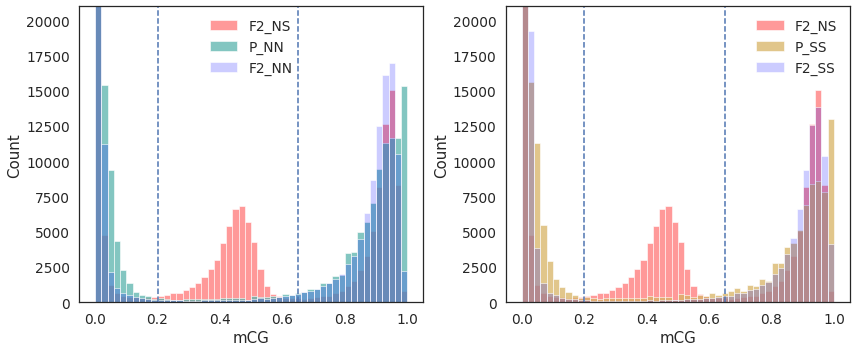

In [30]:
ef_data = req_mc_data['mc_meths'].copy()

fig, axs = plt.subplots(figsize = (12,5), ncols = 2)

sns.histplot(ef_data['F2_D1_AB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = "red", label = 'F2_NS', alpha = 0.4)
sns.histplot(ef_data['P_6046'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = geno_color['AA'], label = 'P_NN')
sns.histplot(ef_data['F2_D1_AA'], binwidth=0.02, binrange=(0,1), ax = axs.flat[0], color = 'blue', label = 'F2_NN', alpha = 0.2)

axs.flat[0].vlines((0.2, 0.65), ymin = 0, ymax = 21000, linestyle = '--')
axs.flat[0].set_ylim(0, 21000)
axs.flat[0].legend(frameon = False)
# axs.flat[0].set_yscale('log')
axs.flat[0].set_xlabel('mCG')


sns.histplot(ef_data['F2_D1_AB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = "red", label = 'F2_NS', alpha = 0.4)
sns.histplot(ef_data['P_6191'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = geno_color['BB'], label = 'P_SS')
sns.histplot(ef_data['F2_D1_BB'], binwidth=0.02, binrange=(0,1), ax = axs.flat[1], color = "blue", label = 'F2_SS', alpha = 0.2)
axs.flat[1].vlines((0.2, 0.65), ymin = 0, ymax = 21000, linestyle = '--')
axs.flat[1].set_ylim(0, 21000)
axs.flat[1].legend(frameon = False)
# axs.flat[1].set_yscale('log')
axs.flat[1].set_xlabel('mCG')

fig.tight_layout()
plt.show()

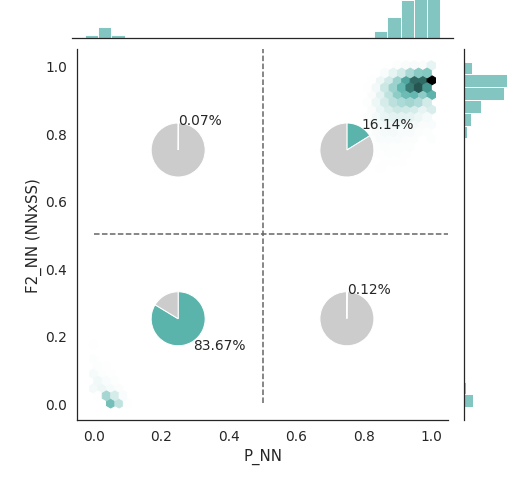

In [17]:
common_reqcond = {"annotate": False, "size": 40, "kind": "hex", 'min_sum': 0.05, 'marginal_ticks': False}
pie_options = dict(xlim=(0,2), ylim=(0,2), center = 0.5, xpie = (0.25,0.75), ypie = (0.25, 0.75), pie_rad = 0.08 ) 
ef_data = req_mc_data['req_meths'].copy()

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)


p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes = bshap.plotting.SeabornFig2Grid(p2, fig, gs[0])


plt.savefig("epimutation_NN.pdf")

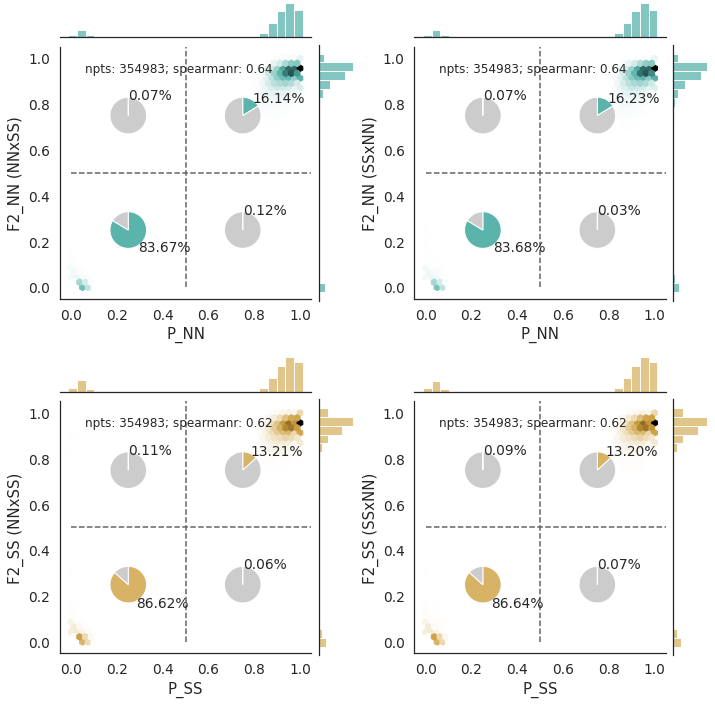

In [11]:
common_reqcond = {"annotate": True, "size": 40, "kind": "hex", 'min_sum': 0.05, 'marginal_ticks': False}
pie_options = dict(xlim=(0,2), ylim=(0,2), center = 0.5, xpie = (0.25,0.75), ypie = (0.25, 0.75), pie_rad = 0.08 ) 

# ef_data = req_mc_data['mc_meths'].loc[:,['P_6046','P_6191','F2_D1_AA','F2_D2_AA','F2_D1_BB','F2_D2_BB']].dropna()
# ef_data = ef_data[np.abs(ef_data['P_6046'] - ef_data['P_6191'] ) > 0.5]

ef_data = req_mc_data['req_meths'].copy()

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)

axes = {}

# ef_data = req_mc_data['deviations'].mc_meths.loc[:,['P_6046','P_6191']].dropna()
# p1 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {**common_reqcond, "color": cb.qualitative.Set1_6.hex_colors[1], "xlab": "P_NN", "ylab": "P_SS"}, min_sum = common_reqcond['min_sum'])
# bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], axs=p1.ax_joint, plt_options={**pie_options,"color": cb.qualitative.Set1_6.hex_colors[1] })
# axes[0] = bshap.plotting.SeabornFig2Grid(p1, fig, gs[0])


p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes[1] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[0])


p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,3], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,3], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes[2] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[1])



# p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,2], y = ef_data.iloc[:,3], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "F2_NN (NNxSS)", "ylab": "F2_NN (SSxNN)"}, min_sum = common_reqcond['min_sum'])
# bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,2], y = ef_data.iloc[:,3], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
# axes[3] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[2])



# p3 = bshap.plotting.meths_jointplot(y = ef_data['F2_D2_AA'], x = ef_data['P_6046'], reqcond = {"annotate": True, "color": cb.qualitative.Set1_6.hex_colors[4], "size": 20}, min_sum = 0.01)
# axes[2] = bshap.plotting.SeabornFig2Grid(p3, fig, gs[2])

p4 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,1], y = ef_data.iloc[:,4], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "P_SS", "ylab": "F2_SS (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,1], y = ef_data.iloc[:,4], axs=p4.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
axes[4] = bshap.plotting.SeabornFig2Grid(p4, fig, gs[2])


p4 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,1], y = ef_data.iloc[:,5], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "P_SS", "ylab": "F2_SS (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,1], y = ef_data.iloc[:,5], axs=p4.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
axes[5] = bshap.plotting.SeabornFig2Grid(p4, fig, gs[3])


# p5 = bshap.plotting.meths_jointplot(y = ef_data['F2_D2_BB'], x = ef_data['P_6046'], reqcond = {"annotate": True, "color": cb.qualitative.Set1_6.hex_colors[3], "size": 20}, min_sum = 0.01)
# axes[4] = bshap.plotting.SeabornFig2Grid(p5, fig, gs[4])

# fig.suptitle('mCGs in %s' % req_mc_data['bed_str'], size=20)
gs.tight_layout(fig)
# gs.update(top=0.9)

plt.show()

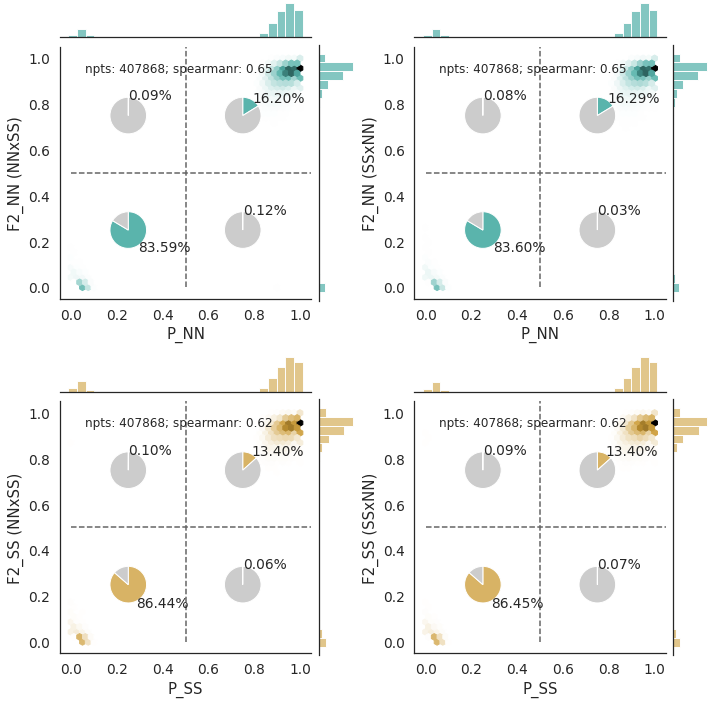

In [112]:
common_reqcond = {"annotate": True, "size": 40, "kind": "hex", 'min_sum': 0.05, 'marginal_ticks': False}
pie_options = dict(xlim=(0,2), ylim=(0,2), center = 0.5, xpie = (0.25,0.75), ypie = (0.25, 0.75), pie_rad = 0.08 ) 

# ef_data = req_mc_data['mc_meths'].loc[:,['P_6046','P_6191','F2_D1_AA','F2_D2_AA','F2_D1_BB','F2_D2_BB']].dropna()
# ef_data = ef_data[np.abs(ef_data['P_6046'] - ef_data['P_6191'] ) > 0.5]

ef_data = req_mc_data['req_meths'].copy()

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)

axes = {}

# ef_data = req_mc_data['deviations'].mc_meths.loc[:,['P_6046','P_6191']].dropna()
# p1 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {**common_reqcond, "color": cb.qualitative.Set1_6.hex_colors[1], "xlab": "P_NN", "ylab": "P_SS"}, min_sum = common_reqcond['min_sum'])
# bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], axs=p1.ax_joint, plt_options={**pie_options,"color": cb.qualitative.Set1_6.hex_colors[1] })
# axes[0] = bshap.plotting.SeabornFig2Grid(p1, fig, gs[0])


p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes[1] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[0])


p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,3], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,3], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes[2] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[1])



# p2 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,2], y = ef_data.iloc[:,3], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "F2_NN (NNxSS)", "ylab": "F2_NN (SSxNN)"}, min_sum = common_reqcond['min_sum'])
# bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,2], y = ef_data.iloc[:,3], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
# axes[3] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[2])



# p3 = bshap.plotting.meths_jointplot(y = ef_data['F2_D2_AA'], x = ef_data['P_6046'], reqcond = {"annotate": True, "color": cb.qualitative.Set1_6.hex_colors[4], "size": 20}, min_sum = 0.01)
# axes[2] = bshap.plotting.SeabornFig2Grid(p3, fig, gs[2])

p4 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,1], y = ef_data.iloc[:,4], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "P_SS", "ylab": "F2_SS (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,1], y = ef_data.iloc[:,4], axs=p4.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
axes[4] = bshap.plotting.SeabornFig2Grid(p4, fig, gs[2])


p4 = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,1], y = ef_data.iloc[:,5], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "P_SS", "ylab": "F2_SS (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,1], y = ef_data.iloc[:,5], axs=p4.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
axes[5] = bshap.plotting.SeabornFig2Grid(p4, fig, gs[3])


# p5 = bshap.plotting.meths_jointplot(y = ef_data['F2_D2_BB'], x = ef_data['P_6046'], reqcond = {"annotate": True, "color": cb.qualitative.Set1_6.hex_colors[3], "size": 20}, min_sum = 0.01)
# axes[4] = bshap.plotting.SeabornFig2Grid(p5, fig, gs[4])

# fig.suptitle('mCGs in %s' % req_mc_data['bed_str'], size=20)
gs.tight_layout(fig)
# gs.update(top=0.9)

plt.show()

In [34]:
(0.06 / (0.06 + 79.89))/2

0.000375234521575985

In [37]:
(0.28 / (0.28 + 26.23))/2

0.005281026027913995

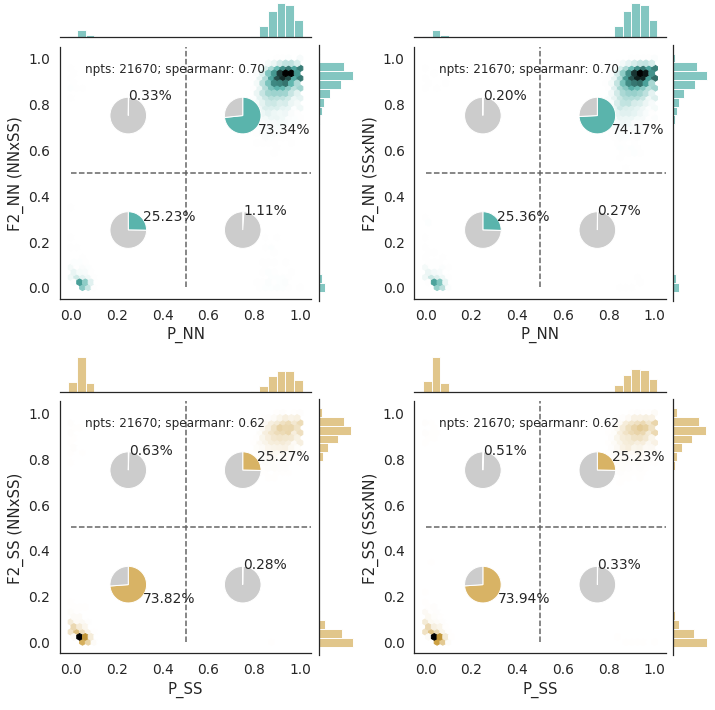

In [150]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)

axes = {}


ef_data = req_mc_data['req_meths'].copy()
ef_data = ef_data[((ef_data['P_6046'] < 0.5) & (ef_data['P_6191'] > 0.5)) | ((ef_data['P_6046'] > 0.5) & (ef_data['P_6191'] < 0.5))]

p2 = bshap.plotting.meths_jointplot(x = ef_data['P_6046'], y = ef_data['F2_D1_AA'], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data['P_6046'], y = ef_data['F2_D1_AA'], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes[1] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[0])


p2 = bshap.plotting.meths_jointplot(x = ef_data['P_6046'], y = ef_data['F2_D2_AA'], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "P_NN", "ylab": "F2_NN (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data['P_6046'], y = ef_data['F2_D2_AA'], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
axes[1] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[1])



p2 = bshap.plotting.meths_jointplot(x = ef_data['P_6191'], y = ef_data['F2_D1_BB'], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "P_SS", "ylab": "F2_SS (NNxSS)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data['P_6191'], y = ef_data['F2_D1_BB'], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
axes[2] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[2])

p2 = bshap.plotting.meths_jointplot(x = ef_data['P_6191'], y = ef_data['F2_D2_BB'], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "P_SS", "ylab": "F2_SS (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data['P_6191'], y = ef_data['F2_D2_BB'], axs=p2.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
axes[2] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[3])


gs.tight_layout(fig)

plt.show()

## Overlap of epimutations

Distribution of these sites across genome

In [113]:
req_mc_data['mc_meths'].loc[:,['chr','start','end']] = combined_mcs_all['meths'].get_bed_pos_ix( req_mc_data['mc_meths']['index'].values ).values
req_mc_data['req_meths'].loc[:,['chr','start','end']] =  req_mc_data['mc_meths'].loc[:,['chr','start','end']]

In [125]:
def calc_epimutations(req_meths):
    out = {}
    out['p_nn_00'] = (req_meths['P_6046'] < 0.5)
    out['p_nn_11'] = (req_meths['P_6046'] > 0.5)
    out['p_ss_00'] = (req_meths['P_6191'] < 0.5)
    out['p_ss_11'] = (req_meths['P_6191'] > 0.5)
    out['gain_nn_d1'] = (out['p_nn_00'] & (req_meths['F2_D1_AA'] > 0.5))
    out['gain_nn_d2'] = (out['p_nn_00'] & (req_meths['F2_D2_AA'] > 0.5))
    out['gain_ss_d1'] = (out['p_ss_00'] & (req_meths['F2_D1_BB'] > 0.5))
    out['gain_ss_d2'] = (out['p_ss_00'] & (req_meths['F2_D2_BB'] > 0.5))
    out['loss_nn_d1'] = (out['p_nn_11'] & (req_meths['F2_D1_AA'] < 0.5))
    out['loss_nn_d2'] = (out['p_nn_11'] & (req_meths['F2_D2_AA'] < 0.5))
    out['loss_ss_d1'] = (out['p_ss_11'] & (req_meths['F2_D1_BB'] < 0.5))
    out['loss_ss_d2'] = (out['p_ss_11'] & (req_meths['F2_D2_BB'] < 0.5))
    ### Considering two generations here
    out['p_gain_nn_d1']=50*bshap.stats.np_get_fraction(out['gain_nn_d1'].sum(),out['p_nn_00'].sum(),y_min=5)
    out['p_gain_nn_d2']=50*bshap.stats.np_get_fraction(out['gain_nn_d2'].sum(),out['p_nn_00'].sum(),y_min=5)
    out['p_gain_ss_d1']=50*bshap.stats.np_get_fraction(out['gain_ss_d1'].sum(),out['p_ss_00'].sum(),y_min=5)
    out['p_gain_ss_d2']=50*bshap.stats.np_get_fraction(out['gain_ss_d2'].sum(),out['p_ss_00'].sum(),y_min=5)
    out['p_loss_nn_d1']=50*bshap.stats.np_get_fraction(out['loss_nn_d1'].sum(),out['p_nn_11'].sum(),y_min=5)
    out['p_loss_nn_d2']=50*bshap.stats.np_get_fraction(out['loss_nn_d2'].sum(),out['p_nn_11'].sum(),y_min=5)
    out['p_loss_ss_d1']=50*bshap.stats.np_get_fraction(out['loss_ss_d1'].sum(),out['p_ss_11'].sum(),y_min=5)
    out['p_loss_ss_d2']=50*bshap.stats.np_get_fraction(out['loss_ss_d2'].sum(),out['p_ss_11'].sum(),y_min=5)
    return(out)

In [136]:
req_mc_data['epis'] = calc_epimutations( req_mc_data['req_meths'] )

req_mc_data['epis_dmc'] = calc_epimutations(req_mc_data['req_meths'][(((req_mc_data['req_meths']['P_6046'] > 0.5) & (req_mc_data['req_meths']['P_6191'] < 0.5)) | ((req_mc_data['req_meths']['P_6046'] < 0.5) & (req_mc_data['req_meths']['P_6191'] > 0.5)))] )

In [157]:
req_mc_data['epis_dmc']['loss_ss_d1'].sum()

61

In [153]:
(req_mc_data['epis_dmc']['gain_ss_d1'] & req_mc_data['epis_dmc']['gain_ss_d2']).sum()

20

In [146]:
req_mc_data['epis_dmc']['loss_nn_d2'].sum()

59

In [149]:
(req_mc_data['epis_dmc']['loss_nn_d1'] & req_mc_data['epis_dmc']['loss_nn_d2']).sum()

17

In [117]:
req_mc_data['epi_rates_windows'] = pd.DataFrame(columns=['chr','start','end'])

for ef_bin in tair10.iter_positions_in_windows( req_mc_data['req_meths'].loc[:,['chr','start','end']], 500000 ):
    if len(ef_bin[2]) > 0:
        ef_epis = calc_epimutations(req_mc_data['req_meths'].iloc[ef_bin[2],:])
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0],'chr'] = ef_bin[0]
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0],'start'] = ef_bin[1][0]
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0],'end'] = ef_bin[1][1]
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'gain_nn_d1'] =  ef_epis['p_gain_nn_d1']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'gain_nn_d2'] =  ef_epis['p_gain_nn_d2']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'gain_ss_d1'] =  ef_epis['p_gain_ss_d1']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'gain_ss_d2'] =  ef_epis['p_gain_ss_d2']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'loss_nn_d1'] =  ef_epis['p_loss_nn_d1']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'loss_nn_d2'] =  ef_epis['p_loss_nn_d2']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'loss_ss_d1'] =  ef_epis['p_loss_ss_d1']
        req_mc_data['epi_rates_windows'].loc[ef_bin[1][0], 'loss_ss_d2'] =  ef_epis['p_loss_ss_d2']

/users/rahul.pisupati/.conda/envs/py3_quant/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/users/rahul.pisupati/.conda/envs/py3_quant/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 2.0)

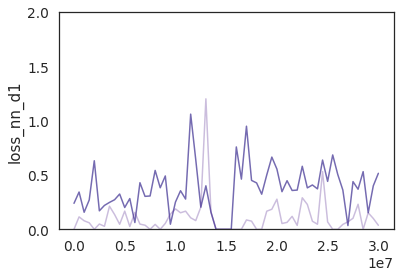

In [118]:

sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_nn_d1'], color = cb.sequential.Purples_5.hex_colors[3] )
sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_nn_d2'], color = cb.sequential.Purples_5.hex_colors[4], alpha = 0.3 )

# sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d1'], color = cb.sequential.Blues_5.hex_colors[3], alpha = 0.8 )
# sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d2'], color = cb.sequential.Blues_5.hex_colors[4], alpha = 0.3 )
plt.ylim(0, 2)

/users/rahul.pisupati/.conda/envs/py3_quant/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/users/rahul.pisupati/.conda/envs/py3_quant/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 2.0)

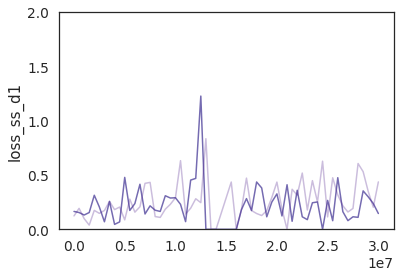

In [124]:

sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d1'], color = cb.sequential.Purples_5.hex_colors[3] )
sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d2'], color = cb.sequential.Purples_5.hex_colors[4], alpha = 0.3 )

# sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d1'], color = cb.sequential.Blues_5.hex_colors[3], alpha = 0.8 )
# sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d2'], color = cb.sequential.Blues_5.hex_colors[4], alpha = 0.3 )
plt.ylim(0, 2)

/users/rahul.pisupati/.conda/envs/py3_quant/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/users/rahul.pisupati/.conda/envs/py3_quant/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 2.0)

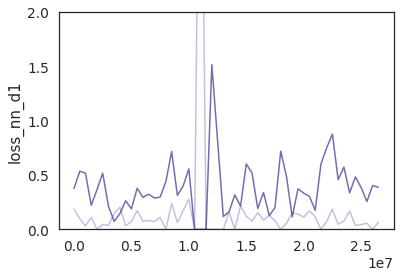

In [96]:

sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_nn_d1'], color = cb.sequential.Purples_5.hex_colors[3] )
sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_nn_d2'], color = cb.sequential.Purples_5.hex_colors[4], alpha = 0.3 )

# sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d1'], color = cb.sequential.Blues_5.hex_colors[3], alpha = 0.8 )
# sns.lineplot( req_mc_data['epi_rates_windows'].index, req_mc_data['epi_rates_windows']['loss_ss_d2'], color = cb.sequential.Blues_5.hex_colors[4], alpha = 0.3 )
plt.ylim(0, 2)

In [ ]:
## peak coordinates.
## Plot the P(epimutation) along the chromosome -- and peak should go away
# 

Text(0.5, 0, '')

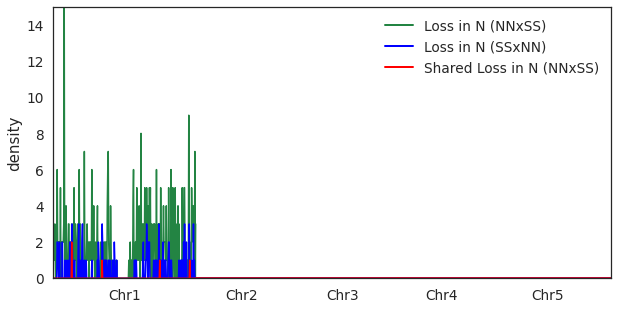

In [122]:
fig, axs = plt.subplots(figsize = (10,5))

plotting_along_genome.density_line_plot_positions( req_mc_data['req_meths'].loc[req_mc_data['epis']['loss_nn_d1'],['chr','start','end']], plt_options=dict(gap = 0, label = 'Loss in N (NNxSS)'), axs = axs )
plotting_along_genome.density_line_plot_positions( req_mc_data['req_meths'].loc[req_mc_data['epis']['loss_nn_d2'],['chr','start','end']], plt_options=dict(gap = 0, color = "blue", label = 'Loss in N (SSxNN)'), axs = axs )

plotting_along_genome.density_line_plot_positions( req_mc_data['req_meths'].loc[(req_mc_data['epis']['loss_nn_d1'] & req_mc_data['epis']['loss_nn_d2']),['chr','start','end']], plt_options=dict(gap = 0, color = "red", label = 'Shared Loss in N (NNxSS)'), axs = axs )

axs.legend(axs.custum_legend[0], axs.custum_legend[1], frameon = False)
axs.set_ylim(0, 15)

axs.set_xlabel("")
# axs.set_xlim(92170846, 119146348 )

(92170846.0, 119146348.0)

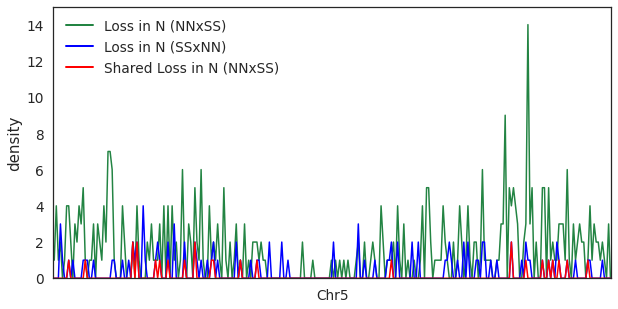

In [67]:
fig, axs = plt.subplots(figsize = (10,5))

plotting_along_genome.density_line_plot_positions( req_mc_data['req_meths'].loc[req_mc_data['epi_loss_nn_d1'],['chr','start','end']], plt_options=dict(gap = 0, label = 'Loss in N (NNxSS)'), axs = axs )
plotting_along_genome.density_line_plot_positions( req_mc_data['req_meths'].loc[req_mc_data['epi_loss_nn_d2'],['chr','start','end']], plt_options=dict(gap = 0, color = "blue", label = 'Loss in N (SSxNN)'), axs = axs )

plotting_along_genome.density_line_plot_positions( req_mc_data['req_meths'].loc[(req_mc_data['epi_loss_nn_d1'] & req_mc_data['epi_loss_nn_d2']),['chr','start','end']], plt_options=dict(gap = 0, color = "red", label = 'Shared Loss in N (NNxSS)'), axs = axs )

axs.legend(axs.custum_legend[0], axs.custum_legend[1], frameon = False)
axs.set_ylim(0, 15)

axs.set_xlabel("")
axs.set_xlim(92170846, 119146348 )

In [35]:
print(req_mc_data['epi_gain_nn_d1'].sum())
print(req_mc_data['epi_gain_nn_d2'].sum())
print(req_mc_data['epi_loss_nn_d1'].sum())
print(req_mc_data['epi_loss_nn_d2'].sum())

print( (req_mc_data['epi_gain_nn_d1'] & req_mc_data['epi_gain_nn_d2']).sum() )
print( (req_mc_data['epi_loss_nn_d1'] & req_mc_data['epi_loss_nn_d2']).sum() )

249
231
416
108


In [38]:
17 / 375

0.04533333333333334

In [37]:
print(req_mc_data['epi_gain_ss_d1'].sum())
print(req_mc_data['epi_gain_ss_d2'].sum())
print(req_mc_data['epi_loss_ss_d1'].sum())
print(req_mc_data['epi_loss_ss_d2'].sum())

print( (req_mc_data['epi_gain_ss_d1'] & req_mc_data['epi_gain_ss_d2']).sum() )
print( (req_mc_data['epi_loss_ss_d1'] & req_mc_data['epi_loss_ss_d2']).sum() )

375
304
223
259
17
3


### How do heterozygous sites look like in progeny?

In [48]:
%%time

test_het_data = {}
test_het_data['data'] = req_mc_data['mc_meths'].copy()
test_het_data['het_p_nn'] = ~find_mcg_homo(test_het_data['data']['mc_count_P_6046'].values, test_het_data['data']['mc_total_P_6046'].values)
test_het_data['het_p_ss'] = ~find_mcg_homo(test_het_data['data']['mc_count_P_6191'].values, test_het_data['data']['mc_total_P_6191'].values)
test_het_data['het_idx'] = test_het_data['data']['index'].iloc[np.where(test_het_data['het_p_ss'] & test_het_data['het_p_nn'] )[0]].values

test_het_data['data'] = test_het_data['data'].set_index('index').loc[test_het_data['het_idx'],:]
# test_het_data['data'] = test_het_data['data'][]
# ef_data['call_het_NN'] = find_mcg_het(ef_data['mc_count_P_6046'], ef_data['mc_total_P_6046'])
# ef_data = ef_data[~ef_data['call_het_NN']]

CPU times: user 365 ms, sys: 24.5 ms, total: 389 ms
Wall time: 388 ms


In [49]:
%%time

test_het_data['mc'] = combined_mcs_all['meths'].__getattr__('mc_count', test_het_data['het_idx'] )#[:,combined_mcs_all['accs_ix']['P_6046']]
test_het_data['mt'] = combined_mcs_all['meths'].__getattr__('mc_total', test_het_data['het_idx'] )#[:,combined_mcs_all['accs_ix']['P_6046']]

CPU times: user 1min 58s, sys: 1min 7s, total: 3min 6s
Wall time: 3min 13s


In [70]:
def test_mendel(count, total):
    lk = sp.stats.binom.logpmf(k = count, n = total,  p = 0.5 ).sum(1)
    # return(lk - lk.max())
    return( (lk - np.mean(lk) ) / lk.std() )
    

# def test_mendel(count, total):
#     inherit_0s = bshap.stats.np_binom_test(count, total, 0.1, alternative = "less") < 0.05
#     inherit_1s = bshap.stats.np_binom_test(count, total, 0.75, alternative = "greater") < 0.05
#     return(inherit_0s, inherit_1s)
#     # pm = bshap.stats.np_get_fraction(count, total, y_min=3)
#     # pt = (~np.isnan(pm)).sum(1)
#     # num_0s = (pm <= 0.2).sum(1)
#     # num_1s = (pm >= 0.6).sum(1)
#     # return((num_0s, num_1s, pt))

# def test_seg(p1, p0, pt):
#     x2 = ((p0 - (0.25 * pt))**2)/(0.25 * pt)
#     x2 += ((p1 - (0.25 * pt))**2)/(0.25 * pt)
#     x2 += ((pt - p1 - p0 - (0.5 * pt))**2)/(0.5 * pt)
#     return(x2)
#     return( sp.stats.chisquare([p0, pt - p0 - p1, p1], np.array([0.25, 0.5, 0.25]) * pt)[1] )
    


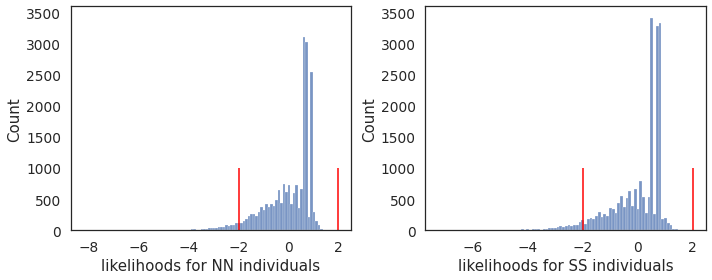

In [72]:
fig, axs = plt.subplots(figsize = (10,4), ncols = 2)


mc = test_het_data['mc'][:,combined_mcs_all['accs_ix']['P_6046']]
mt = test_het_data['mt'][:,combined_mcs_all['accs_ix']['P_6046']]
pm = test_mendel(mc, mt)

sns.histplot( pm, binwidth=0.1, ax = axs.flat[0]  )
# axs.flat[0].vlines( [-3.8], ymin = 0, ymax = 1000, color = "red" )
axs.flat[0].vlines( [-2,2], ymin = 0, ymax = 1000, color = "red" )
axs.flat[0].set_ylim(0,3600)
# axs.flat[0].set_xlim(-5,5)
axs.flat[0].set_xlabel('likelihoods for NN individuals')
# axs.set_yscale('log')



mc = test_het_data['mc'][:,combined_mcs_all['accs_ix']['P_6191']]
mt = test_het_data['mt'][:,combined_mcs_all['accs_ix']['P_6191']]
pm = test_mendel(mc, mt)

sns.histplot( pm, binwidth=0.1, ax = axs.flat[1]  )
# axs.flat[1].vlines( [-3.8], ymin = 0, ymax = 1000, color = "red" )
axs.flat[1].vlines( [-2,2], ymin = 0, ymax = 1000, color = "red" )
axs.flat[1].set_ylim(0,3600)
# axs.flat[1].set_xlim(-5,5)
axs.flat[1].set_xlabel('likelihoods for SS individuals')
# axs.set_yscale('log')


fig.tight_layout()
plt.show()



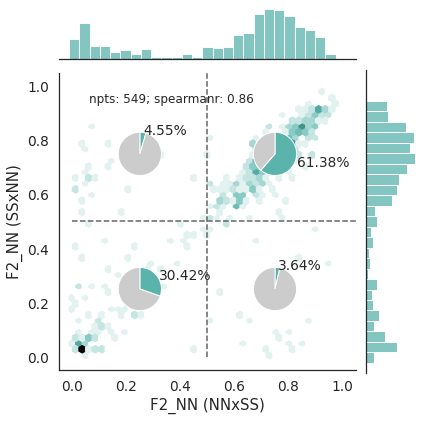

In [88]:
# ef_data = test_het_data['data'].iloc[np.where(np.abs(pm) > 1.5)[0],:]

mc = test_het_data['mc'][:,combined_mcs_all['accs_ix']['P_6046']]
mt = test_het_data['mt'][:,combined_mcs_all['accs_ix']['P_6046']]
pm = test_mendel(mc, mt)

ef_data = test_het_data['data'].iloc[np.where(np.abs(pm) > 2.5)[0],:]


p = bshap.plotting.meths_jointplot(x = ef_data['F2_D1_AA'], y = ef_data['F2_D2_AA'], reqcond = {**common_reqcond, "color": geno_color['AA'], "xlab": "F2_NN (NNxSS)", "ylab": "F2_NN (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data['F2_D1_AA'], y = ef_data['F2_D2_AA'], axs=p.ax_joint, plt_options={**pie_options,"color": geno_color['AA'] } )
# axes[1] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[0])




# bshap.plotting.meths_jointplot(  )

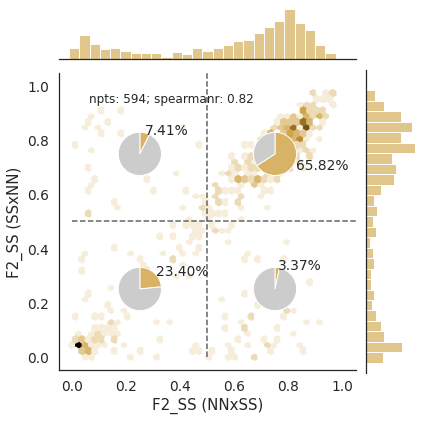

In [86]:
# ef_data = test_het_data['data'].iloc[np.where(np.abs(pm) > 1.5)[0],:]

mc = test_het_data['mc'][:,combined_mcs_all['accs_ix']['P_6191']]
mt = test_het_data['mt'][:,combined_mcs_all['accs_ix']['P_6191']]
pm = test_mendel(mc, mt)

ef_data = test_het_data['data'].iloc[np.where(np.abs(pm) > 2.5)[0],:]


p = bshap.plotting.meths_jointplot(x = ef_data['F2_D1_BB'], y = ef_data['F2_D2_BB'], reqcond = {**common_reqcond, "color": geno_color['BB'], "xlab": "F2_SS (NNxSS)", "ylab": "F2_SS (SSxNN)"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data['F2_D1_AA'], y = ef_data['F2_D2_AA'], axs=p.ax_joint, plt_options={**pie_options,"color": geno_color['BB'] } )
# axes[1] = bshap.plotting.SeabornFig2Grid(p2, fig, gs[0])




# bshap.plotting.meths_jointplot(  )

<AxesSubplot:xlabel='P_6046', ylabel='Count'>

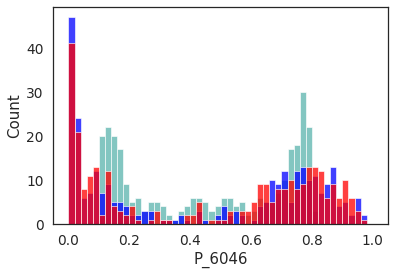

In [19]:
ef_data = test_het_data['data'].iloc[np.where(np.abs(pm) > 3.8)[0],:]

sns.histplot( ef_data['P_6046'], binwidth=0.02, binrange=(0,1), color = geno_color['AA'] )
sns.histplot( ef_data['F2_D1_AA'], binwidth=0.02, binrange=(0,1), color = "blue" )
sns.histplot( ef_data['F2_D2_AA'], binwidth=0.02, binrange=(0,1), color = "red" )



1. Can we say anything about epimutations?


1. look across the parents -- test whether they fit 1:2:1, 1:0:0, 0:0:1, 0:1:0
    1. if 1:2:1 -- then it is heterozygous! look at the F1s
    2. If not (0:1:0?), there could be CNV. If CNV, the distribution do make sense. I would distribution of these sites across the genome.
    3. or hypermutable
1. Look at the F1 classification. They would be all either methylated or unmethylated. 


distribution across genome
look at the read methylation for these sites.


In [40]:
ef_data = req_mc_data['req_meths'].copy()

mut_d1_ix = ef_data[((ef_data['P_6046'] < 0.4) & (ef_data['F2_D1_AA'] > 0.5))].index

print(mut_d1_ix.shape)

mut_d2_ix = ef_data[((ef_data['P_6046'] < 0.4) & (ef_data['F2_D2_AA'] > 0.5))].index

print(mut_d2_ix.shape)

print(np.intersect1d(mut_d1_ix, mut_d2_ix).shape)

(260,)
(240,)
(54,)


In [43]:
print( (ef_data.loc[mut_d1_ix,'P_6191'] > 0.5).sum() )

82

In [10]:
ind_1_ix = np.where(bshap.stats.np_binom_test(req_mc_data['mc_meths']['mc_count_P_6046'].values, req_mc_data['mc_meths']['mc_total_P_6046'].values, p = 0.2, alternative = "greater") < 0.05)[0]
ind_2_ix = np.where(bshap.stats.np_binom_test(req_mc_data['mc_meths']['mc_count_P_6046'].values, req_mc_data['mc_meths']['mc_total_P_6046'].values, p = 0.6, alternative = "less") < 0.05)[0]
req_mc_data['het_pos'] = req_mc_data['mc_meths'].iloc[np.intersect1d(ind_1_ix, ind_2_ix),:]

In [50]:
req_mc_data['num_0s'], req_mc_data['num_1s'], req_mc_data['num_pt'] = test_mendel(mc[:,combined_mcs_all['accs_ix']['P_6046']], mt[:,combined_mcs_all['accs_ix']['P_6046']])

<AxesSubplot:ylabel='Count'>

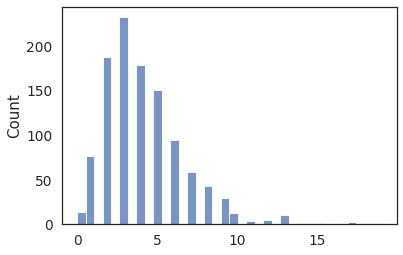

In [20]:
sns.histplot(req_mc_data['num_pt'])

<AxesSubplot:ylabel='Count'>

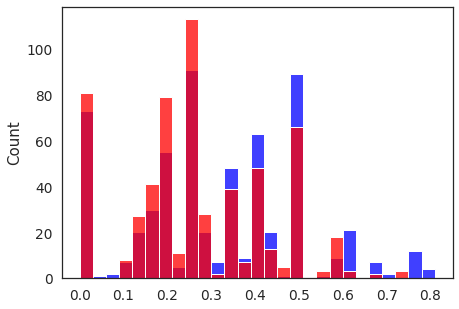

In [17]:
fig, axs = plt.subplots(figsize = (7,5))
sns.histplot(req_mc_data['num_0s'],ax = axs, binwidth=0.03, color= "blue")
sns.histplot(req_mc_data['num_1s'],ax = axs, binwidth=0.03, color= "red")

# sns.histplot(req_mc_data['num_0s'] + req_mc_data['num_1s'],ax = axs, binwidth=0.02, color= "green")




In [104]:
mc = combined_mcs_all['meths'].__getattr__('mc_count', [req_mc_data['het_pos']['index'].values[1043]] )[:,combined_mcs_all['accs_ix']['P_6046']]
mt = combined_mcs_all['meths'].__getattr__('mc_total', [req_mc_data['het_pos']['index'].values[1043]] )[:,combined_mcs_all['accs_ix']['P_6046']]

In [107]:
bshap.stats.np_get_fraction(mc, mt, 3)

array([[       nan, 0.5       ,        nan,        nan, 0.33333333,
        0.5625    ,        nan,        nan,        nan, 0.5       ,
        0.23076923, 0.2       , 0.22222222, 0.25      , 0.25      ,
               nan, 0.42857143, 0.29411765,        nan, 0.66666667,
        0.16666667, 0.75      , 0.33333333, 0.16666667, 0.27777778]])

In [106]:
test_mendel(mc, mt)

(array([1.125]), array([0.125]), array([8]))

In [ ]:
## filter for the sites which are 

In [ ]:
(0.3 / (0.3+78.9))/2

0.0018939393939393938

In [71]:
(0.7 / (0.7+83))/2

0.004181600955794504

In [70]:
(0.6 / (0.6+20.1))/2

0.014492753623188403

In [72]:
(0.3 / (0.3+16.0))/2

0.00920245398773006

### mendelian segregation

In [ ]:
# def get_deviations_all(samples, bed_str, combined_mcs, qtl_map, calc= False):
#     req_samples = samples.copy()
#     req_samples['geno'] = pd.concat([qtl_map.get_genotype_dict_at_bed_str("d1_2020", bed_str )[1]['geno'], qtl_map.get_genotype_dict_at_bed_str("d2_2020", bed_str )[1]['geno']])
#     mcg_gbm_ix = combined_mcs_all['meths'].get_req_pos_bed_str(bed_str, req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )
    
#     req_acc_ix = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["P_6046", "P_6191", "F1_D1", "F1_D2"]}
#     req_acc_ix.update( {ef: req_samples.reset_index().groupby((req_samples['geno_dir'] + "_" + req_samples['geno'].fillna('')).values).groups[ef] for ef in ["F2_D1_AA", "F2_D1_AB", "F2_D1_BB","F2_D2_AA", "F2_D2_AB", "F2_D2_BB"]} )
    
#     # req_acc_ix = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["6046_T4", "6191_T4", "F1_D1", "F1_D2"]}
#     # req_acc_ix.update( {ef: req_samples.reset_index().groupby((req_samples['dir_temp'] + "_" + req_samples['geno'].fillna('')).values).groups[ef] for ef in ["D1_T4_AA", "D1_T4_AB", "D1_T4_BB","D2_T4_AA", "D2_T4_AB", "D2_T4_BB"]} )
    
#     mc_data = combined_mcs.calculate_per_meths_per_population( sub_populations=req_acc_ix, filter_cg_pos_ix = mcg_gbm_ix, params_meths = dict(prop_y_min = 10), calc_deviations=calc )
#     return(mc_data)

In [ ]:
# req_mc_data['chr'] = 'Chr5'
# req_mc_data['mc_meths'] = pd.DataFrame()
# for ef_bin in np.arange(1,26975502, 1000000):
#     ef_data = get_deviations_all(combined_mcs_all['samples'], req_mc_data['chr'] + ',' + str(ef_bin) + ',' + str(ef_bin + 1000000)  , combined_mcs_all['meths'], cross_data )
#     req_mc_data['mc_meths'] = pd.concat([req_mc_data['mc_meths'], ef_data.mc_meths], ignore_index=False)
    
# ### DO not do this unless you check
# req_mc_data['mc_meths'] = req_mc_data['mc_meths'].reset_index()
# req_mc_data['mc_meths'].to_hdf('cache_data/mc_meths.chr5.h5', mode = 'w', key = 'mcs') 

In [58]:
%%time
req_mc_data['mc_meths'].loc[:,['chr','start','end']] = combined_mcs_all['meths'].get_bed_pos_ix( req_mc_data['mc_meths']['index'].values ).values

req_mc_data['bed_str'] = req_mc_data['mc_meths']['chr'].iloc[0] + ',' + str(req_mc_data['mc_meths']['start'].min()) + ',' + str(req_mc_data['mc_meths']['end'].max())

req_mc_data['f2_ids'] = cross_data.ids_d1_2020.sample(15, random_state=15)
req_mc_data['f2_epi_ids'] = bshap.the1001g.matching_accessions_ix(combined_mcs_all['meths'].file_ids,req_mc_data['f2_ids'].index.values, return_np=True)

# req_mc_data['sample_f2_inds_genotype'] = pd.DataFrame(columns=req_mc_data['ancestry_f2_ids'].columns)
req_mc_data['ancestry_f2_ids'] = cross_data.get_genotype_marker("d1_2020", cross_data.get_closest_marker("d1_2020",req_mc_data['bed_str'])['marker_id'] ).loc[:,req_mc_data['f2_ids'].index]
req_mc_data['ancestry_f2_ids'].index = cross_data.markers_d1_2020.loc[req_mc_data['ancestry_f2_ids'].index,'start'].values

req_mc_data['dmc_mcg_info'] = (req_mc_data['mc_meths']['F2_D1_AA'] > 0.5) & (req_mc_data['mc_meths']['F2_D1_BB'] < 0.5)
req_mc_data['dmc_mcg_info_ix'] = np.where(req_mc_data['dmc_mcg_info'])[0]

# (req_mc_data['deviations'].mc_meths['inherit_0_F2_D1_AA'].astype(bool) & req_mc_data['deviations'].mc_meths['inherit_1_F2_D1_BB'].astype(bool)) | (req_mc_data['deviations'].mc_meths['inherit_1_F2_D1_AA'].astype(bool) & req_mc_data['deviations'].mc_meths['inherit_0_F2_D1_AA'].astype(bool))


CPU times: user 730 ms, sys: 226 ms, total: 956 ms
Wall time: 1.02 s


In [78]:
%%time
req_mc_data['sample_f2_inds_epigenotype'] = pd.DataFrame(columns=req_mc_data['ancestry_f2_ids'].columns, dtype = float)

for ef_window in tair10.iter_positions_in_windows(req_mc_data['mc_meths'].loc[req_mc_data['dmc_mcg_info'],['chr','start','end']], 100000):
    # combined_mcs_all['meths'].get_bed_pos_ix( chr5_mc_meths['index'].values )
    ef_ix = np.array(ef_window[1]).mean().astype(int)
    if ef_window[2].shape[0] > 0:
        bin_ix = req_mc_data['mc_meths'].iloc[req_mc_data['dmc_mcg_info_ix'][ef_window[2]],]['index'].values
        mc = combined_mcs_all['meths'].__getattr__('mc_count', bin_ix)[:,req_mc_data['f2_epi_ids']].sum(0)
        mt = combined_mcs_all['meths'].__getattr__('mc_total', bin_ix)[:,req_mc_data['f2_epi_ids']].sum(0) 
        req_mc_data['sample_f2_inds_epigenotype'].loc[ef_ix,] = bshap.stats.np_get_fraction( mc, mt, y_min = 3)

CPU times: user 6min 38s, sys: 3min 49s, total: 10min 27s
Wall time: 11min 1s


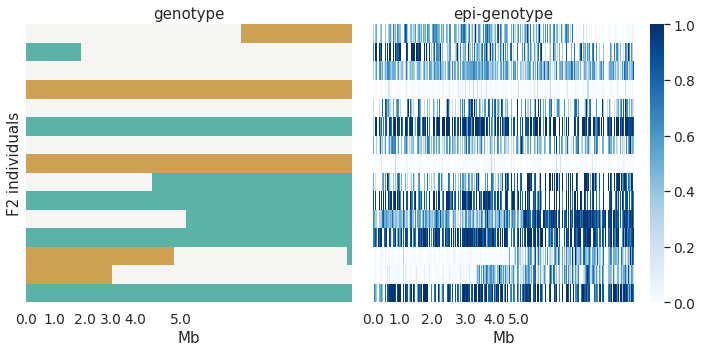

In [55]:
xticklabs = np.linspace(0, 5, 6)

fig, axs = plt.subplots(ncols=2, nrows = 1, figsize = (10, 5), sharex = False, sharey=True)

sns.heatmap( pyquant.utils.marker_to_int( req_mc_data['ancestry_f2_ids'].T, marker_ids=['AA','AB','BB'] ), cmap = "BrBG_r", ax = axs.flat[0], vmax=4, center=2, vmin = 0, cbar = False, xticklabels=False, yticklabels=False)
axs.flat[0].set_xticks(np.searchsorted(req_mc_data['ancestry_f2_ids'].index.values, xticklabs * 1000000))
axs.flat[0].set_xticklabels(xticklabs)
axs.flat[0].set_xlabel("Mb")
axs.flat[0].set_title("genotype")
axs.flat[0].set_ylabel("F2 individuals")




sns.heatmap(req_mc_data['sample_f2_inds_epigenotype'].T, cmap = "Blues", ax = axs.flat[1], xticklabels=False, yticklabels=False)
axs.flat[1].set_xticks(np.searchsorted(req_mc_data['sample_f2_inds_epigenotype'].index.values, xticklabs * 1000000))
axs.flat[1].set_xticklabels(xticklabs)
axs.flat[1].set_xlabel("Mb")
axs.flat[1].set_title("epi-genotype")

fig.tight_layout()
plt.show()


In [60]:
def plot_ancestry(x, y_pos, ax):
    for e_ans in ['AA','AB','BB']:
        ef_ans = x[x == e_ans]
        if len(ef_ans) > 0:
            e_df = pd.DataFrame({'chr': ['Chr1'], 'start': [ef_ans.index.min()], 'end': [ef_ans.index.max()], 'color': [geno_color[e_ans]]  })
            plotting_along_genome._chromosome_patch_collection(ax, yranges = y_pos, df = e_df, plt_options = dict(alpha = 0.1) )

def plot_meths(x, y_pos, ax, color = "#252525"):
    n_x = x.dropna()
    sns.lineplot(x = n_x.index, y = (y_pos[1] * pyquant.utils.smooth_sum(n_x.values, 10)) + y_pos[0], ax = ax, lw = 1.5, color = color )


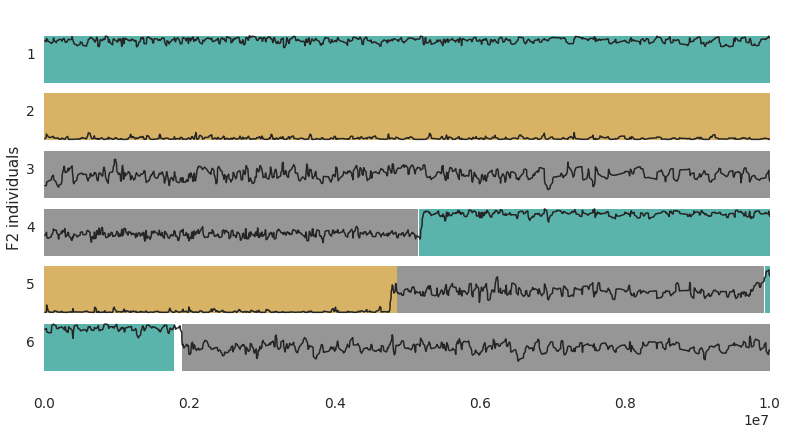

In [61]:
fig, axs = plt.subplots(ncols=1, nrows = 1, figsize = (13, 7), sharex = False)

plt_options = dict(gap = 0, color = "#D8D8D8", band_width = 0.8, axs = axs )


plt_options['axs'].spines['top'].set_visible(False)
plt_options['axs'].spines['right'].set_visible(False)
plt_options['axs'].spines['bottom'].set_visible(False)
plt_options['axs'].spines['left'].set_visible(False)

xlim = 3.5
for ef in [11,3,4,10,12,1]:
    plot_ancestry(req_mc_data['ancestry_f2_ids'].iloc[:,ef], (xlim, plt_options['band_width']), plt_options['axs'])
    plot_meths( req_mc_data['sample_f2_inds_epigenotype'].iloc[:,ef], (xlim, plt_options['band_width']), plt_options['axs']  )
    xlim = xlim - 1



plt_options['axs'].set_xlim(0, 10000000)
plt_options['axs'].set_ylim(-1.8, 4.8)
plt_options['axs'].set_yticks(np.array([4,3,2,1,0,-1]), labels= pd.Series(np.arange(6) + 1).astype(str) )
plt_options['axs'].set_ylabel("F2 individuals")


plt.savefig("mendelian_mcg.pdf")

plt.show()

## Where does methylated cytosines on chloroplast come from?

1. Non conversion rate due to bisulfite conversion
2. Chloroplast DNA is inserted into nuclear genome and these copies are silenced with DNA methylation. In the absence of reference copies, the short reads are mapped to chrloroplast DNA. 

First, I am calculating chrloroplast copy number, and number of methylated cytosines




Idea: Look at the reads, can you identify two read populations (one from chloroplast and another from nuclear genome) that differ in methylation levels.


In [6]:
%%time

req_mc_data = {}

req_mc_data['samples'] = pyquant.parsers.split_ids( plate_design.loc[ combined_mcs_f2s['meths'].file_ids.values, 'replicated_id'] ).reset_index().set_index( combined_mcs_f2s['meths'].file_ids.values )
req_mc_data['replicated_ids'] = req_mc_data['samples'].loc[ req_mc_data['samples'].index.str.startswith("mix"), 'replicated_id' ]
req_mc_data['replicated_ids'] = req_mc_data['replicated_ids'].reset_index().set_axis(['rep2', 'rep1'], axis=1, inplace=False)



# req_mc_data['mcs_chrc_bed'] = combined_mcs_f2s['meths'].get_req_pos_bed_str("ChrC,1,152000", req_mc_class = "C[ATGC][ATCG]", exon_bed_df = None)
req_mc_data['mcs_chrc_bed'] = combined_mcs_f2s['meths'].get_req_pos_bed_str("ChrC,1,152000", req_mc_class = "CG[ATCG]", exon_bed_df = None)
req_mc_data['mcs_chr1_bed'] = combined_mcs_f2s['meths'].get_req_pos_bed_str("Chr1,1,1000000", req_mc_class = "C[ATGC][ATCG]", exon_bed_df = None)
req_mc_data['samples']['depth_chr1'] = np.mean(combined_mcs_f2s['meths'].__getattr__( "mc_total", req_mc_data['mcs_chr1_bed'] ), 0)


req_mc_data['chrc_mc_total'] = combined_mcs_f2s['meths'].__getattr__( "mc_total", req_mc_data['mcs_chrc_bed'] )
req_mc_data['chrc_mc_count'] = combined_mcs_f2s['meths'].__getattr__( "mc_count", req_mc_data['mcs_chrc_bed'] )


req_mc_data['samples']['depth_chrc'] = np.mean(req_mc_data['chrc_mc_total'], 0)
req_mc_data['samples']['cnv_chrc'] = req_mc_data['samples']['depth_chrc'] / req_mc_data['samples']['depth_chr1']


# req_mc_data['samples']['conv_rate'] = 1 - pd.read_csv("/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/sample_conversion_rate_chrc.csv").groupby("sample_id").mean()['conv_rate']

# req_pos_ix = np.sort(np.random.choice(len(req_mc_data['mcs_chrc_bed']), 1000, replace=False))
req_pos_ix = np.arange(len(req_mc_data['mcs_chrc_bed']))

req_mc_data['samples']['cobs_chrc'] = bshap.combinemeths.np_get_fraction(req_mc_data['chrc_mc_count'][req_pos_ix,:].sum(0), req_mc_data['chrc_mc_total'][req_pos_ix,:].sum(0))

CPU times: user 5.23 s, sys: 3.44 s, total: 8.66 s
Wall time: 10.1 s


In [7]:
req_mc_data['samples'].loc[:,['cnv_chrc', 'cobs_chrc']].to_csv("cache_data/temp.sample_conv_rate.csv")

T16 vs. T4: Mann-Whitney-Wilcoxon test two-sided, P_val:8.584e-45 U_stat=7.196e+03
T16 vs. T4: Mann-Whitney-Wilcoxon test two-sided, P_val:4.201e-02 U_stat=2.516e+04


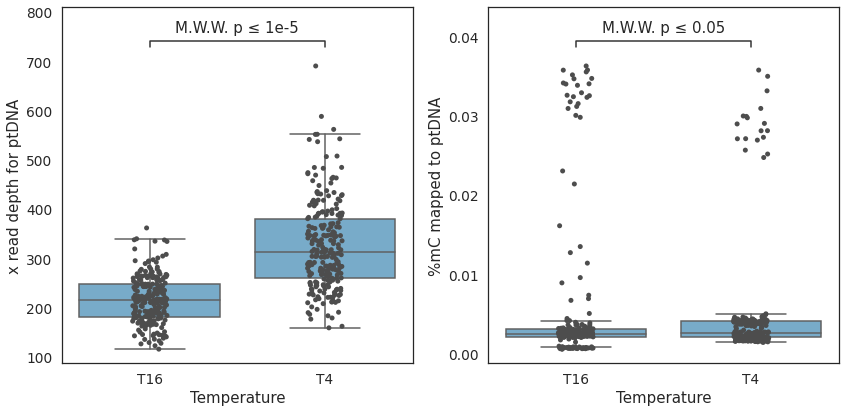

In [7]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}


fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))

fig_args = {
    "data": req_mc_data['samples'].dropna(), 
    "x": "temp",
    "y": "cnv_chrc",
    "order": ['T16', 'T4'],
    "ax": axs.flat[0]
}
sns.stripplot(**fig_args, palette=[".3"] * 2, jitter=True )
sns.boxplot(**fig_args, color = cb.sequential.Blues_5.hex_colors[2], fliersize=0)
# 
axs.flat[0].set_ylabel("x read depth for ptDNA")
axs.flat[0].set_xlabel("Temperature")
annotator = Annotator.Annotator(**fig_args, pairs = [ ('T16', 'T4') ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()


fig_args = {
    "data": req_mc_data['samples'].dropna(), 
    "x": "temp",
    "y": "cobs_chrc",
    "order": ['T16', 'T4'],
    "ax": axs.flat[1]
}
sns.stripplot(**fig_args, palette=[".3"] * 2, jitter=True )
sns.boxplot(**fig_args, color = cb.sequential.Blues_5.hex_colors[2], fliersize=0)
# 
axs.flat[1].set_ylabel("%mC mapped to ptDNA")
axs.flat[1].set_xlabel("Temperature")
# axs.flat[1].set_ylim(0, 0.01)
annotator = Annotator.Annotator(**fig_args, pairs = [ ('T16', 'T4') ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()


fig.tight_layout()


plt.show()

In [9]:
qtls_conv_rates = "Chr1:29974305"

req_mc_data['samples']['qtl_cobs'] = cross_data.get_genotype_marker( "d1_2020", qtls_conv_rates )

qtls_cnv_chrc = "Chr5:6262735"

req_mc_data['samples']['qtl_cnv_chrc'] = cross_data.get_genotype_marker( "d1_2020", qtls_cnv_chrc )

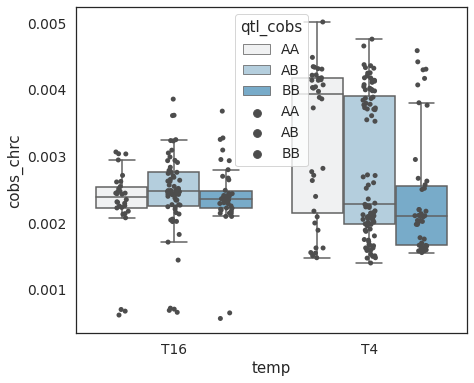

In [30]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}


fig, axs = plt.subplots(ncols = 1, figsize = (7, 6))

fig_args = {
    "data": req_mc_data['samples'].dropna(), 
    "hue": "qtl_cobs",
    "y": "cobs_chrc",
    "x": "temp",
    "order": ['T16', 'T4'],
    "hue_order": ['AA','AB','BB'],
    "ax": axs,
    "dodge": True
}
sns.stripplot(**fig_args, palette=[".3"] * 3, jitter=True )
sns.boxplot(**fig_args, color = cb.sequential.Blues_5.hex_colors[2], fliersize=0)
# 
# axs.set_ylabel("x read depth for ptDNA")
# axs.set_xlabel("Temperature")
# annotator = Annotator.Annotator(**fig_args, pairs = [ ('T16', 'T4') ], plot='stripplot')
# annotator.configure(**configuration).apply_test().annotate()



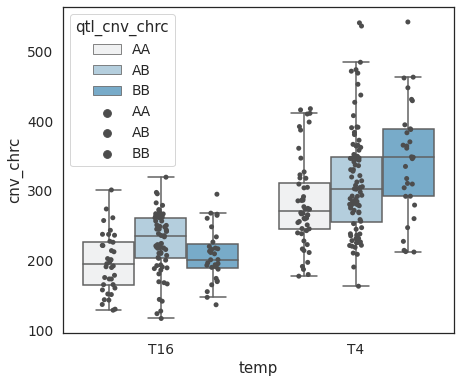

In [32]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}


fig, axs = plt.subplots(ncols = 1, figsize = (7, 6))

fig_args = {
    "data": req_mc_data['samples'].dropna(), 
    "hue": "qtl_cnv_chrc",
    "y": "cnv_chrc",
    "x": "temp",
    "order": ['T16', 'T4'],
    "hue_order": ['AA','AB','BB'],
    "ax": axs,
    "dodge": True
}
sns.stripplot(**fig_args, palette=[".3"] * 3, jitter=True )
sns.boxplot(**fig_args, color = cb.sequential.Blues_5.hex_colors[2], fliersize=0)
# 
# axs.set_ylabel("x read depth for ptDNA")
# axs.set_xlabel("Temperature")
# annotator = Annotator.Annotator(**fig_args, pairs = [ ('T16', 'T4') ], plot='stripplot')
# annotator.configure(**configuration).apply_test().annotate()



## Do our deviations change between technical replicates? 

I care less about conversion if my calculations for gains and losses do not depend on conversion rate.



In [19]:
%%time

req_mc_data = {}
# req_mc_data['bed_str'] = "Chr3,1,500000"
req_mc_data['bed_str'] = "Chr1,20000001,22000000"
# req_mc_data['bed_str'] = "Chr3,3000001,4000000"
# req_mc_data['bed_str'] = "Chr5,3000001,3500001"
# req_mc_data['bed_str'] = "Chr4,5000001,5500000"



req_mc_data['samples'] = pyquant.parsers.split_ids( plate_design.loc[ combined_mcs_f2s['meths'].file_ids.values, 'replicated_id'] ).reset_index().set_index( combined_mcs_f2s['meths'].file_ids.values )
req_mc_data['replicated_ids'] = req_mc_data['samples'].loc[ req_mc_data['samples'].index.str.startswith("mix"), 'replicated_id' ]
req_mc_data['replicated_ids'] = req_mc_data['replicated_ids'].reset_index().set_axis(['rep2', 'rep1'], axis=1, inplace=False)
# req_mc_data['replicated_ids'] = pd.melt(req_mc_data['replicated_ids'], var_name= "rep", value_name = 'id' ).set_index( "id" )

req_mc_data['geno_groups'] = cross_data.get_genotype_dict_at_bed_str("d1_2020", req_mc_data['bed_str'])[1].reindex( req_mc_data['samples']['replicated_id'] ).reset_index().groupby("geno").groups


req_mc_data['mcg_nuclear_ix'] = combined_mcs_f2s['meths'].get_req_pos_bed_str(req_mc_data['bed_str'], req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )

req_mc_data['cg_count'] = combined_mcs_f2s['meths'].__getattr__("mc_count", req_mc_data['mcg_nuclear_ix'])
req_mc_data['cg_total'] = combined_mcs_f2s['meths'].__getattr__("mc_total", req_mc_data['mcg_nuclear_ix'])




CPU times: user 13 s, sys: 4.59 s, total: 17.6 s
Wall time: 19.4 s


In [22]:
req_mc_data['cg_count'].shape

(44479, 475)

In [20]:
%%time
req_mc_data['mcs_chrc_bed'] = combined_mcs_f2s['meths'].get_req_pos_bed_str("ChrC,1,152000", req_mc_class = "CG[ATCG]", exon_bed_df = None)

req_mc_data['samples']['depth_chr1'] = req_mc_data['cg_total'].mean(0)

req_mc_data['chrc_mc_total'] = combined_mcs_f2s['meths'].__getattr__( "mc_total", req_mc_data['mcs_chrc_bed'] )
req_mc_data['chrc_mc_count'] = combined_mcs_f2s['meths'].__getattr__( "mc_count", req_mc_data['mcs_chrc_bed'] )


req_mc_data['samples']['depth_chrc'] = np.mean(req_mc_data['chrc_mc_total'], 0)
req_mc_data['samples']['cnv_chrc'] = req_mc_data['samples']['depth_chrc'] / req_mc_data['samples']['depth_chr1']

req_pos_ix = np.sort(np.random.choice(len(req_mc_data['mcs_chrc_bed']), 1000, replace=False))
# req_pos_ix = np.arange(len(req_mc_data['mcs_chrc_bed']))

req_mc_data['samples']['cobs_chrc'] = bshap.combinemeths.np_get_fraction(req_mc_data['chrc_mc_count'][req_pos_ix,:].sum(0), req_mc_data['chrc_mc_total'][req_pos_ix,:].sum(0))

CPU times: user 2.02 s, sys: 750 ms, total: 2.77 s
Wall time: 3.35 s


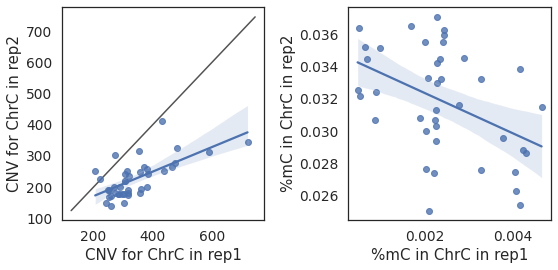

In [41]:
fig, axs = plt.subplots(figsize = (8, 4), ncols=2, nrows = 1)

sns.regplot( x = req_mc_data['samples'].loc[req_mc_data['replicated_ids']['rep1'],"cnv_chrc"], y = req_mc_data['samples'].loc[req_mc_data['replicated_ids']['rep2'],"cnv_chrc"], ax = axs.flat[0])
axs.flat[0].set_xlabel("CNV for ChrC in rep1")
axs.flat[0].set_ylabel("CNV for ChrC in rep2")
bshap.plotting.plot_y_equal_x(axs.flat[0])

sns.regplot( x = req_mc_data['samples'].loc[req_mc_data['replicated_ids']['rep1'],"cobs_chrc"], y = req_mc_data['samples'].loc[req_mc_data['replicated_ids']['rep2'],"cobs_chrc"], ax = axs.flat[1])
axs.flat[1].set_xlabel("%mC in ChrC in rep1")
axs.flat[1].set_ylabel("%mC in ChrC in rep2")

fig.tight_layout()

plt.show()

Corr for deviation at 0
SpearmanrResult(correlation=0.5643817534866362, pvalue=0.001159333348169087)
Corr for deviation at 1
SpearmanrResult(correlation=0.40511679644048937, pvalue=0.02636271851016558)


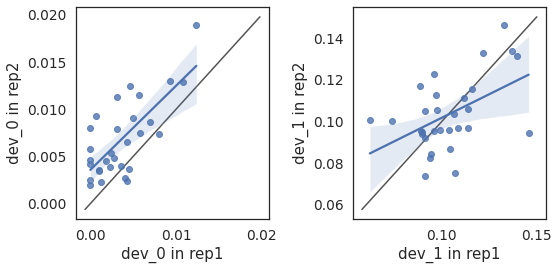

CPU times: user 5.73 s, sys: 322 ms, total: 6.06 s
Wall time: 2.06 s


In [42]:
%%time
ef_devs = bshap.combinemeths.calculate_deviations_f2_populations(req_mc_data['cg_count'], req_mc_data['cg_total'], req_mc_data['geno_groups'], params_meths = {
    "max_meth_for_gain" : 0.5,
    "min_meth_for_loss" : 0.5,
    "mc_total_min" : 3,
    "prop_y_min" : 20,
    "conv_rate": 0.06
})
ef_devs['deviations'].index = combined_mcs_f2s['meths'].file_ids[ef_devs['deviations'].index].values
req_mc_data['deviations'] = pd.merge(req_mc_data['samples'], ef_devs['deviations'], left_index=True, right_index=True)


ef_data = pd.DataFrame()
ef_data['rep_1_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_0"].values
ef_data['rep_2_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_0"].values
ef_data['rep_1_site_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["site_deviation_0"].values
ef_data['rep_2_site_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["site_deviation_0"].values

ef_data['rep_1_dev_1'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_1"].values
ef_data['rep_2_dev_1'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_1"].values
ef_data['subpop'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["subpop"].values
ef_data['temp'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["temp"].values



print("Corr for deviation at 0")
print(sp.stats.spearmanr(ef_data.dropna()['rep_1_dev_0'], ef_data.dropna()['rep_2_dev_0']  ))
print("Corr for deviation at 1")
print(sp.stats.spearmanr(ef_data.dropna()['rep_1_dev_1'], ef_data.dropna()['rep_2_dev_1']  ))

fig, axs = plt.subplots(figsize = (8, 4), ncols = 2, nrows = 1)

sns.regplot( x = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_0"].values, y = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_0"].values, ax = axs.flat[0])
axs.flat[0].set_xlabel("dev_0 in rep1")
axs.flat[0].set_ylabel("dev_0 in rep2")
bshap.plotting.plot_y_equal_x(axs.flat[0])


sns.regplot( x = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_1"].values, y = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_1"].values, ax = axs.flat[1])
axs.flat[1].set_xlabel("dev_1 in rep1")
axs.flat[1].set_ylabel("dev_1 in rep2")
bshap.plotting.plot_y_equal_x(axs.flat[1])


fig.tight_layout()
plt.show()

Corr for deviation at 0
SpearmanrResult(correlation=0.6422691879866518, pvalue=0.00013003456866118328)
Corr for deviation at 1
SpearmanrResult(correlation=0.6409343715239153, pvalue=0.00013568815316383347)


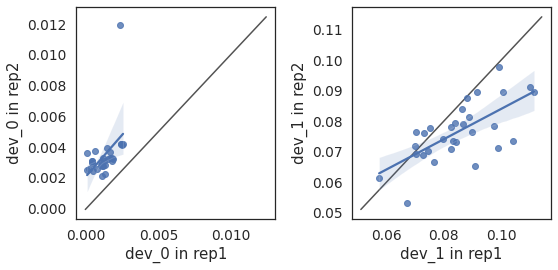

CPU times: user 12.5 s, sys: 930 ms, total: 13.5 s
Wall time: 8.45 s


In [26]:
%%time
ef_devs = bshap.combinemeths.calculate_deviations_f2_populations(req_mc_data['cg_count'], req_mc_data['cg_total'], req_mc_data['geno_groups'], params_meths = {
    "max_meth_for_gain" : 0.5,
    "min_meth_for_loss" : 0.5,
    "mc_total_min" : 3,
    "prop_y_min" : 20,
    "conv_rate": 0.06
})
ef_devs['deviations'].index = combined_mcs_f2s['meths'].file_ids[ef_devs['deviations'].index].values
req_mc_data['deviations'] = pd.merge(req_mc_data['samples'], ef_devs['deviations'], left_index=True, right_index=True)


ef_data = pd.DataFrame()
ef_data['rep_1_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_0"].values
ef_data['rep_2_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_0"].values
ef_data['rep_1_site_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["site_deviation_0"].values
ef_data['rep_2_site_dev_0'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["site_deviation_0"].values

ef_data['rep_1_dev_1'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_1"].values
ef_data['rep_2_dev_1'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_1"].values
ef_data['subpop'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["subpop"].values
ef_data['temp'] = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["temp"].values



print("Corr for deviation at 0")
print(sp.stats.spearmanr(ef_data.dropna()['rep_1_dev_0'], ef_data.dropna()['rep_2_dev_0']  ))
print("Corr for deviation at 1")
print(sp.stats.spearmanr(ef_data.dropna()['rep_1_dev_1'], ef_data.dropna()['rep_2_dev_1']  ))

fig, axs = plt.subplots(figsize = (8, 4), ncols = 2, nrows = 1)

sns.regplot( x = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_0"].values, y = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_0"].values, ax = axs.flat[0])
axs.flat[0].set_xlabel("dev_0 in rep1")
axs.flat[0].set_ylabel("dev_0 in rep2")
bshap.plotting.plot_y_equal_x(axs.flat[0])


sns.regplot( x = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_1"].values, y = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_1"].values, ax = axs.flat[1])
axs.flat[1].set_xlabel("dev_1 in rep1")
axs.flat[1].set_ylabel("dev_1 in rep2")
bshap.plotting.plot_y_equal_x(axs.flat[1])


fig.tight_layout()
plt.show()

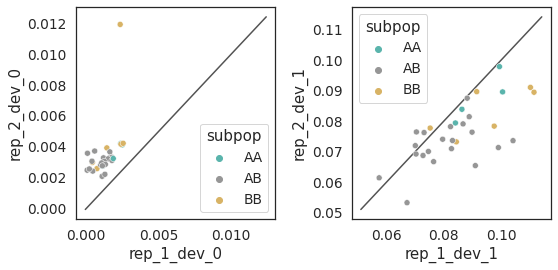

In [23]:


fig, axs = plt.subplots(ncols=2, figsize = (8, 4))

sns.scatterplot(data = ef_data.dropna(), x = "rep_1_dev_0", y = "rep_2_dev_0", hue = "subpop", ax = axs.flat[0] , palette=geno_color)
bshap.plotting.plot_y_equal_x(axs.flat[0])

sns.scatterplot(data = ef_data.dropna(), x = "rep_1_dev_1", y = "rep_2_dev_1", hue = "subpop", ax = axs.flat[1] , palette=geno_color)
bshap.plotting.plot_y_equal_x(axs.flat[1])

fig.tight_layout()


plt.show()
# # 

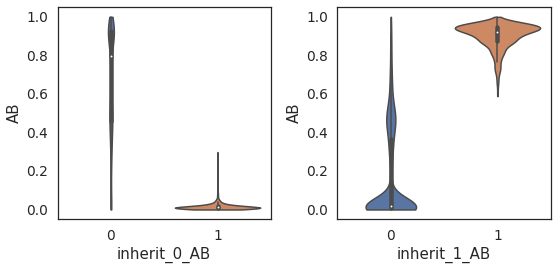

In [46]:
fig, axs = plt.subplots(figsize = (8,4), ncols=2)


sns.violinplot(data = ef_devs['permeths_subpop'], x = 'inherit_0_AB', y = "AB", ax = axs.flat[0], cut = 0)
sns.violinplot(data = ef_devs['permeths_subpop'], x = 'inherit_1_AB', y = "AB", ax = axs.flat[1], cut = 0)

fig.tight_layout()

<AxesSubplot:>

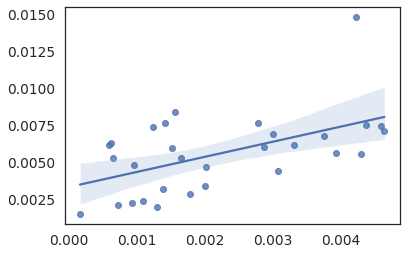

In [ ]:
sns.regplot( x = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep1'])["deviation_0"].values, y = req_mc_data['deviations'].reindex(req_mc_data['replicated_ids']['rep2'])["deviation_0"].values)

## What happens to hemi-methylated sites? Is there paramutation?



In [41]:
%%time

req_mc_data = {}

req_mc_data['bed_str'] = "Chr3,1,2000000"

req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)
req_mc_data['mc_data_d2'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths_d2'], cross_data, "d2_2020", return_all = True)

CPU times: user 25 s, sys: 4.1 s, total: 29.1 s
Wall time: 45.5 s


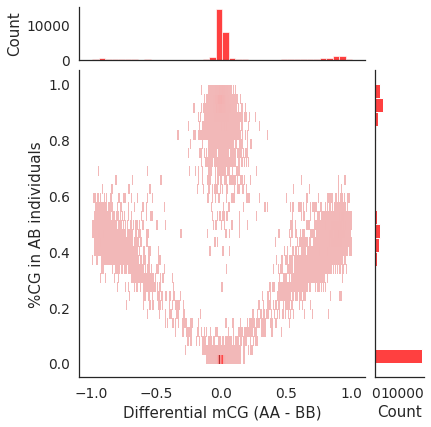

In [32]:
ef_data = req_mc_data['mc_data']['permeths_subpop'].copy().dropna()
ef_data = ef_data[np.abs(ef_data['AA'] - ef_data['BB']) > 0.001]


p = sns.jointplot( x = ef_data['AA'] - ef_data['BB'], y = ef_data['AB'], kind = "hist", marginal_kws={"binwidth": 0.05}, marginal_ticks=True, color = "red")
p.ax_joint.set_xlabel( "Differential mCG (AA - BB)" )
p.ax_joint.set_ylabel( "%CG in AB individuals" )
plt.show()

In [42]:
%%time
req_mc_data['dmcs_ix'] = req_mc_data['mc_data']['permeths_subpop'].index[np.abs(req_mc_data['mc_data']['permeths_subpop']['AA'] - req_mc_data['mc_data']['permeths_subpop']['BB']) > 0.7].values

ef_counts = combined_mcs_f2s['meths'].__getattr__("mc_count", req_mc_data['dmcs_ix'])
ef_total = combined_mcs_f2s['meths'].__getattr__("mc_total", req_mc_data['dmcs_ix'])

ef_hetero_inds = np.where(req_mc_data['mc_data']['deviations'].reindex( combined_mcs_f2s['meths'].file_ids )['subpop'] == 'AB')[0]

req_mc_data['mc_data']['deviations'].loc[combined_mcs_f2s['meths'].file_ids[ef_hetero_inds], "deviation_hemi"] = 0.5 - snpmatch.snpmatch.np_get_fraction( ef_counts[:,ef_hetero_inds].sum(0), ef_total[:,ef_hetero_inds].sum(0), y_min = 100 )

CPU times: user 4.22 s, sys: 840 ms, total: 5.06 s
Wall time: 5.04 s


In [43]:
req_mc_data['mc_data']['deviations']['conv_rate'] = combined_mcs_f2s['samples']['conv_rate']
# pd.merge(req_mc_data['mc_data']['deviations'], combined_mcs_f2s['samples'], left_index=True,right_index=True)
req_mc_data['mc_data']['deviations']['resid_hemi'] = calc_residuals(req_mc_data['mc_data']['deviations']['deviation_hemi'], 100 - req_mc_data['mc_data']['deviations']['conv_rate'])


req_mc_data['mc_data']['deviations'].to_csv( "cache_data/epimutation_rates_hemimeths_chr3_2mb.csv" )